# Correlated Truncation Errors in for Realistic NN Interactions in Chiral Effective Field Theory

This notebook provides the code to reproduce all of the plots from Melendez et al. (2019).
Notebook written by Jordan Melendez.
Commentary by Daniel Phillips and Dick Furnstahl, June 2019.


*Note*: Since publication we have switched the `pivoted_cholesky` function from an underlying GSL to a LAPACK routine.
Their output is generally identical but the exact results can differ very slightly depending on fine details of the input matrix.
Thus some of the PC plots may not be identical to their published versions, but the overall conclusions remain unchanged. (Currently only Fig. 7(c) has changed.)

In [1]:
import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.interpolate import interp1d
import os
import h5py
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import math
import re

import urllib
import tables

%matplotlib inline
%load_ext autoreload
%autoreload 2

In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# See: https://ianstormtaylor.com/design-tip-never-use-black/
# softblack = '#262626'
softblack = 'k'  # Looks better when printed on tex file
gray = '0.7'

mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['axes.edgecolor'] = softblack
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = softblack
mpl.rcParams['axes.linewidth']

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.color'] = softblack
mpl.rcParams['ytick.color'] = softblack
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

text_bbox = dict(boxstyle='round', fc=(1, 1, 1, 0.6), ec=softblack, lw=0.8)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='pdf')

In [3]:
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]
light_colors = [cmap(0.25) for cmap in cmaps]

edgewidth = 0.6

In [4]:
def joint_plot(ratio = 1, height = 3):
    """Taken from Seaborn JointGrid"""
    fig = plt.figure(figsize=(height, height))
    gsp = plt.GridSpec(ratio+1, ratio+1)

    ax_joint = fig.add_subplot(gsp[1:, :-1])
    ax_marg_x = fig.add_subplot(gsp[0, :-1], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gsp[1:, -1], sharey=ax_joint)

    # Turn off tick visibility for the measure axis on the marginal plots
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Turn off the ticks on the density axis for the marginal plots
    plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_marg_x.yaxis.grid(False)
    ax_marg_y.xaxis.grid(False)

    # Make the grid look nice
    from seaborn import utils
    # utils.despine(fig)
    utils.despine(ax=ax_marg_x, left=True)
    utils.despine(ax=ax_marg_y, bottom=True)
    fig.tight_layout(h_pad=0, w_pad=0)
    
    ax_marg_y.tick_params(axis='y', which='major', direction='out')
    ax_marg_x.tick_params(axis='x', which='major', direction='out')
    ax_marg_y.tick_params(axis='y', which='minor', direction='out')
    ax_marg_x.tick_params(axis='x', which='minor', direction='out')
    ax_marg_y.margins(x=0.1, y=0.)

    fig.subplots_adjust(hspace=0, wspace=0)
    
    return fig, ax_joint, ax_marg_x, ax_marg_y

In [5]:
def offset_xlabel(ax):
    ax.set_xticks([0])
    ax.set_xticklabels(labels=[0], fontdict=dict(color='w'))
    ax.tick_params(axis='x', length=0)
    return ax

## NN Scattering in Chiral EFT

In the last section of the paper we turn our attention to NN scattering in Chiral EFT. We apply the above ideas to the differential cross section vs angle at $E_{\rm lab}=150$ MeV, to the total cross section vs energy, and to the spin observable $A$ at 96 MeV.

In [6]:
# Constants: proton/neutron masses and hbar
m_p = 938.27208  # MeV/c^2
m_n = 939.56541  # MeV/c^2
hbarc = 197.33  # Mev-fm


def E_to_p(E_lab, interaction):
    """Returns p in MeV.

    Parameters
    ----------
    energy      = float
                  lab energy given in MeV.
    interaction = str
                  {"pp", "nn", "np"}
    """

    if interaction == "pp":
        m1, m2 = m_p, m_p
    if interaction == "nn":
        m1, m2 = m_n, m_n
    if interaction == "np":
        m1, m2 = m_n, m_p
    p_rel = np.sqrt(
        E_lab * m2**2 * (E_lab + 2 * m1) /
        ((m1 + m2)**2 + 2 * m2 * E_lab)
        )
    return p_rel


def Q_approx(p, Q_parametrization, Lambda_b, interaction='np', single_expansion=False):
    if single_expansion:
        m_pi = 0
    else:
        m_pi = 138  # Set to 0 to just return p/Lambda_b
    
#     p = E_to_p(E, interaction)
    
    if Q_parametrization == "poly":
        # Interpolate to smooth the transition from m_pi to p with a polynomial
        n = 8
        q = (m_pi**n + p**n) / (m_pi**(n-1) + p**(n-1)) / Lambda_b
        return q
    
    elif Q_parametrization == "max":
        # Transition from m_pi to p with a maximum function
        m_pi_eff = 200
        
        try:
            q = [max(P, m_pi_eff) / Lambda_b for P in p]
        except:
            q = max(p, m_pi_eff) / Lambda_b
        return q
    
    elif Q_parametrization == "sum":
        # Transition from m_pi to p with a simple sum
        q = (p + m_pi) / Lambda_b
        return q

def deg_to_qcm(p, deg):
    """Return the center-of-momentum momentum transfer q in MeV.

    Parameters
    ----------
    p_rel       = float
                  relative momentum given in MeV.
    degrees     = number
                  angle measure given in degrees
    """
    return p * np.sqrt( 2 * (1 - np.cos(np.radians(deg))) )

def deg_to_qcm2(p, deg):
    """Return the center-of-momentum momentum transfer q squared, in MeV^2.

    Parameters
    ----------
    p_rel       = float
                  relative momentum given in MeV.
    degrees     = number
                  angle measure given in degrees
    """
    return (p * np.sqrt( 2 * (1 - np.cos(np.radians(deg))) ))**(2)

def softmax_mom(p, q, n = 5):
    """
    Two-place softmax function.
    
    Parameters
    ----------
    p       = float
            one interpolant.
    q       = float
            another interpolant.
    n       = float
            scaling parameter.
    """
    return 1 / n * math.log(1.01**(n * p) + 1.01**(n * q), 1.01)

In [7]:
class GPHyperparameters:
    def __init__(self, ls, center, ratio, nugget = 1e-10, seed = None, df = np.inf, \
                 disp = 0, scale = 1):
        """
        Class for the hyperparameters of a Gaussian process.
        """
        self.ls = ls
        self.center = center
        self.ratio = ratio
        self.nugget = nugget
        self.seed = seed
        self.df = df
        self.disp = disp
        self.scale = scale
        
class FileNaming:
    def __init__(self, scheme, scale, Q_param):
        self.scheme = scheme
        self.scale = scale
        self.Q_param = Q_param

def find_nearest_val(array, value):
    """
    Finds the value in array closest to value and returns that entry.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    """
    Finds the value in array closest to value and returns that entry.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def mask_mapper(array_from, array_to, mask_from):
    """
    Converts from one mask to another by mapping the entries of the first to the nearest-in-
    value entries in the second.
    """
    mask_array = [( np.argwhere(array_to == find_nearest_val(array_to, i)) ) for i in array_from[mask_from]]
    mask = np.zeros(len(array_from))
    for i in range(len(mask_array)):
        mask[mask_array[i]] = 1
    return np.array(mask.astype(int), dtype = bool)

class PosteriorBounds:
    def __init__(self, x_lower, x_upper, x_n, y_lower, y_upper, y_n):
        """
        Class for the boundaries of the 2D posterior PDF plot and the mesh on which it is plotted.
        """
        self.x_vals = np.linspace(x_lower, x_upper, x_n)
        self.y_vals = np.linspace(y_lower, y_upper, y_n)

class OrderInfo:
    def __init__(self, orders_array, orders_mask, colors_array, lightcolors_array):
        """
        Class for the number of orders under consideration and the color for each.
        """
        self.nn_orders = orders_array
        self.nn_orders_mask = orders_mask
        self.colors_array = colors_array
        self.lightcolors_array = lightcolors_array

class PosteriorBounds:
    def __init__(self, x_lower, x_upper, x_n, y_lower, y_upper, y_n):
        """
        Class for the boundaries of the 2D posterior PDF plot and the mesh on which it is plotted.
        """
        self.x_vals = np.linspace(x_lower, x_upper, x_n)
        self.y_vals = np.linspace(y_lower, y_upper, y_n)

In [8]:
def versatile_train_test_split(interp_obj, n_train, n_test_inter = 1, isclose_factor = 0.01, \
            offset_train_min = 0, offset_train_max = 0, xmin_train = None, xmax_train = None, \
            offset_test_min = 0, offset_test_max = 0, xmin_test = None, xmax_test = None, \
            train_at_ends = True, test_at_ends = False):
    """
    Returns the training and testing points in the input space and the corresponding 
    (interpolated) data values

    Parameters
    ----------
    interp_obj (InterpObj) : function generated with scipy.interpolate.interp1d(x, y), plus
        x and y
    n_train (int) : number of intervals into which to split x, with training points at the 
        edges of each interval
    n_test_inter (int) : number of subintervals into which to split the intervals between 
        training points, with testing points at the edges of each subinterval
    isclose_factor (float) : fraction of the total input space for the tolerance of making
        sure that training and testing points don't coincide
    offset_train_min (float) : value above the minimum of the input space where the first 
        potential training point ought to go
    offset_train_max (float) : value below the maximum of the input space where the last 
        potential training point ought to go
    xmin_train (float) : minimum value within the input space below which there ought not to
        be training points
    xmax_train (float) : maximum value within the input space above which there ought not to
        be training points
    offset_test_min (float) : value above the minimum of the input space where the first 
        potential testing point ought to go
    offset_test_max (float) : value below the maximum of the input space where the last 
        potential testing point ought to go
    xmin_test (float) : minimum value within the input space below which there ought not to
        be testing points
    xmax_test (float) : maximum value within the input space above which there ought not to
        be testing points
    train_at_ends (bool) : whether training points should be allowed at or near the 
        endpoints of x
    test_at_ends (bool) : whether testing points should be allowed at or near the endpoints 
        of x
    """
    # gets information from the InterpObj
    x = interp_obj.x
    y = interp_obj.y
    kind_interp = interp_obj.kind
    f_interp = interp_obj.f_interp
    
    # creates initial sets of training and testing x points
    x_train = np.linspace(np.min(x) + offset_train_min, np.max(x) - offset_train_max, \
                          n_train + 1)
    x_test = np.linspace(np.min(x) + offset_test_min, np.max(x) - offset_test_max, \
                          n_train * n_test_inter + 1)
    
    # sets the xmin and xmax values to the minima and maxima, respectively, of the 
    # input space if no other value is given
    if xmin_train == None: xmin_train = np.min(x);
    if xmax_train == None: xmax_train = np.max(x);
    if xmin_test == None: xmin_test = np.min(x);
    if xmax_test == None: xmax_test = np.max(x);
        
    # eliminates, using a mask, all values for the training and testing x points outside of 
    # x
    x_train = x_train[ np.invert([(x_train[i] < np.min(x) or x_train[i] > np.max(x)) \
                        for i in range(len(x_train))]) ]
    x_test = x_test[ np.invert([(x_test[i] < np.min(x) or x_test[i] > np.max(x)) \
                        for i in range(len(x_test))]) ]
    
    # eliminates, using a mask, all values for the training and testing x points outside of 
    # the bounds specified by xmin and xmax
    x_train = x_train[ np.invert([(x_train[i] < xmin_train or x_train[i] > xmax_train) \
                        for i in range(len(x_train))]) ]
    x_test = x_test[ np.invert([(x_test[i] < xmin_test or x_test[i] > xmax_test) \
                        for i in range(len(x_test))]) ]
    
    # eliminates, using a mask, all values in the testing x points that are close enough
    # (within some tolerance) to any value in the training x points
    mask_filter_array = [[ np.isclose(x_test[i], x_train[j], \
                    atol = isclose_factor * (np.max(x) - np.min(x))) \
                    for i in range(len(x_test))] for j in range(len(x_train))]
    mask_filter_list = np.invert(np.sum(mask_filter_array, axis = 0, dtype = bool))
    x_test = x_test[mask_filter_list]
    
    # evaluates the interpolater at the training and testing x points
    y_train = f_interp(x_train)
    y_test = f_interp(x_test)
    
    # eliminates training and/or testing points if they lie at the edges of the input space
    print("test first: " + str(x[0]) + " " + str(x_test[0]))
    print("test last: " + str(x[-1]) + " " + str(x_test[-1]))
    if not train_at_ends:
        if np.isclose(x_train[0], x[0], atol = isclose_factor * (np.max(x) - np.min(x))):
            x_train = x_train[1:]
            if y_train.ndim == 3:
                y_train = y_train[:, :, 1:]
            elif y_train.ndim == 2:
                y_train = y_train[:, 1:]
        if np.isclose(x_train[-1], x[-1], atol = isclose_factor * (np.max(x) - np.min(x))):
            x_train = x_train[:-1]
            if y_train.ndim == 3:
                y_train = y_train[:, :, :-1]
            elif y_train.ndim == 2:
                y_train = y_train[:, :-1]
    if not test_at_ends:
        if np.isclose(x_test[0], x[0], atol = isclose_factor * (np.max(x) - np.min(x))):
            x_test = x_test[1:]
            print(y_test.shape)
            if y_test.ndim == 3:
                y_test = y_test[:, :, 1:]
            elif y_test.ndim == 2:
                y_test = y_test[:, 1:]
            print(y_test.shape)
        if np.isclose(x_test[-1], x[-1], atol = isclose_factor * (np.max(x) - np.min(x))):
            x_test = x_test[:-1]
            print(y_test.shape)
            if y_test.ndim == 3:
                y_test = y_test[:, :, :-1]
            elif y_test.ndim == 2:
                y_test = y_test[:, :-1]
            print(y_test.shape)

    return x_train, x_test, y_train, y_test

In [9]:
class VsAngleObj:
    def __init__(self, observable, E_lab, Lambda_b, E_lab_x, inputspace, traintestsplit, \
                 gphyperparameters, orderinfo, filenaming, constrained = False):
        """
        Class for everything involving Jordan Melendez's GSUM library for observables that 
        can be plotted against angle.
        observable (ObservableBunch) : observable being plotted
        E_lab (float) : lab energy (MeV) at which to evaluate the observable
        Lambda_b (float) : cutoff (MeV)
        E_lab_x (float array) : lab-energy (MeV) x-coordinate mesh over which the GP is calculated, plotted, and fitted
        inputspace (InputSpaceBunch) : input space against which the observable is plotted
        traintestsplit (TrainTestSplit) : training and testing masks
        gphyperparameters (GPHyperparameters) : parameters for fitted Gaussian process
        orderinfo (OrderInfo) : information about the EFT orders and their colors 
        filenaming (FileNaming) : strings for naming the save files
        constrained (boolean) : is the GP constrained?
        """
        # information on the observable
        self.observable = observable
        self.observable_name = self.observable.name
        self.data = self.observable.data
        self.ref_type = self.observable.ref_type
        
        # energy at which the observable is evaluated
        self.energy = E_lab
        
        # cutoff scale
        self.Lambda_b = Lambda_b
        
        # energy mesh
        self.t_lab = E_lab_x
        
        # information on the input space
        self.inputspace = inputspace
        self.vs_what = self.inputspace.name
        self.degrees = self.inputspace.input_space
        self.Deg = self.degrees[:, None]
        self.caption_coeffs = self.inputspace.caption
        self.title_coeffs = self.inputspace.title
        
        # information on the train/test split
        self.traintestsplit = traintestsplit
        self.train_pts_loc = self.traintestsplit.name
        self.x_train = self.traintestsplit.x_train
        self.n_train_pts = len(self.x_train)
        self.x_test = self.traintestsplit.x_test
        self.n_test_pts = len(self.x_test)
        self.y_train = self.traintestsplit.y_train
        self.y_test = self.traintestsplit.y_test
        
        # information on the GP hyperparameters
        self.gphyperparameters = gphyperparameters
        self.ls = self.gphyperparameters.ls
        self.center = self.gphyperparameters.center
        self.ratio = self.gphyperparameters.ratio
        self.nugget = self.gphyperparameters.nugget
        self.seed = self.gphyperparameters.seed
        self.df = self.gphyperparameters.df
        self.disp = self.gphyperparameters.disp
        
        # information on the orders at which the potential is evaluated
        self.orderinfo = orderinfo
        self.nn_orders = self.orderinfo.nn_orders
        self.nn_orders_mask = self.orderinfo.nn_orders_mask
        self.colors = self.orderinfo.colors_array
        self.light_colors = self.orderinfo.lightcolors_array
        
        # information for naming the file
        self.filenaming = filenaming
        self.scheme = self.filenaming.scheme
        self.scale = self.filenaming.scale
        self.Q_param = self.filenaming.Q_param
        
        # finds the energy in the energy mesh where the observable is evaluated
        self.t_lab_dsg = self.energy
        self.t_lab_idx_dsg = np.nonzero(self.t_lab_dsg == self.t_lab)[0][0]
        
        # uses E_lab to choose the right x and y data sets for training and testing
        self.dsg_vs_theta = self.data.T[:, self.t_lab_idx_dsg]
        print("dsg_vs_theta has shape " + str(self.dsg_vs_theta.shape))
        self.X_train = self.x_train[:, None]
        self.y_train = self.y_train[:, self.t_lab_idx_dsg, :]
        self.y_train = self.y_train.T
        print("X_train has shape " + str(self.x_train.shape))
        print("y_train has shape " + str(self.y_train.shape))
        self.X_test = self.x_test[:, None]
        self.y_test = self.y_test[:, self.t_lab_idx_dsg, :]
        self.y_test = self.y_test.T
        print("X_test has shape " + str(self.x_test.shape))
        print("y_test has shape " + str(self.y_test.shape))
        
        # determines the reference scale for the truncation-error model, including for 
        # training and testing
        if self.ref_type == "dimensionful":
            self.ref = self.dsg_vs_theta[:, -1]
            print("ref = " + str(self.ref) + "and has shape " + str(self.ref.shape))
            f = interp1d(self.degrees, self.ref)
            self.ref_train = f(self.x_train)
            print("ref_train = " + str(self.ref_train) + "and has shape " + str(self.ref_train.shape))
            self.ref_test = f(self.x_test)
            print("ref_test = " + str(self.ref_test) + "and has shape " + str(self.ref_test.shape))
        elif self.ref_type == "dimensionless":
            self.ref = 1
            self.ref_train = np.ones(len(self.x_train))
            self.ref_test = np.ones(len(self.x_test))
        
        # Compute the coefficients
        self.coeffs_dsg = gm.coefficients(self.dsg_vs_theta, ratio = self.ratio, \
                                          ref = self.ref, \
                                          orders = self.nn_orders)[:, self.nn_orders_mask]
        
        # uses interpolation to find the proper ratios for training and testing
        f = interp1d(self.degrees, self.ratio * np.ones(len(self.degrees)))
        self.ratio_train = f(self.x_train)
        print(self.y_train.shape)
        print(self.ratio_train.shape)
        print(self.ref_train.shape)
        self.coeffs_train = gm.coefficients(self.y_train, ratio = self.ratio_train, \
                                          ref = self.ref_train, \
                                          orders = self.nn_orders)[:, self.nn_orders_mask]
        self.ratio_test = f(self.x_test)
        self.coeffs_test = gm.coefficients(self.y_test, ratio = self.ratio_test, \
                                          ref = self.ref_test, \
                                          orders = self.nn_orders)[:, self.nn_orders_mask]
        print("coeffs_test = " + str(self.coeffs_test))
        
        # defines the kernel
        if self.t_lab_dsg < 70.1:
            self.kernel_dsg = RBF(length_scale = self.ls, \
                        length_scale_bounds = (0.25 * self.ls, 4 * self.ls)) + \
                        WhiteKernel(1e-8, noise_level_bounds = 'fixed')
        else:
            self.kernel_dsg = RBF(length_scale = self.ls, \
                        length_scale_bounds = (0.25 * self.ls, 4 * self.ls)) + \
                        WhiteKernel(1e-10, noise_level_bounds = 'fixed')
        
        # creates the ConjugateGaussianProcess for the given parameters
        self.gp_dsg = gm.ConjugateGaussianProcess(
            self.kernel_dsg, center = self.center, disp = self.disp, df = self.df,
            scale = 1, n_restarts_optimizer = 10)

    def PlotCoefficients(self):
        # optimizes the ConjugateGaussianProcess for the given parameters
        self.gp_dsg.fit(self.X_train, self.coeffs_train)
        print(self.gp_dsg.kernel_)
        self.pred, self.std = self.gp_dsg.predict(self.Deg, return_std = True)
        self.underlying_std = np.sqrt(self.gp_dsg.cov_factor_)
        
        # Compute the std-dev under the symmetry constraint
        dX_A = np.array([[0]])
        self.std_interp = np.sqrt(np.diag(
            self.gp_dsg.cov(self.Deg) -
            self.gp_dsg.cov(self.Deg, dX_A) @ \
            np.linalg.solve(self.gp_dsg.cov(dX_A, dX_A), self.gp_dsg.cov(dX_A, self.Deg))
        ))
        
        # plots the coefficients against the given input space
        fig, ax = plt.subplots(figsize=(3.2, 3.2))
        for i, n in enumerate(self.nn_orders[1:]):
            ax.fill_between(self.degrees, self.pred[:, i] + 2*self.std, \
                            self.pred[:, i] - 2*self.std, \
                            facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                            lw = edgewidth, alpha=1, zorder = 4 * i - 3)
            ax.plot(self.degrees, self.pred[:, i], c = self.colors[i], ls='--', zorder = 4 * i - 2)
            ax.plot(self.degrees, self.coeffs_dsg[:, i], c = self.colors[i], zorder = 4 * i - 1)
#             ax.plot(self.degrees[self.deg_train_mask_dsg], \
#                     self.coeffs_dsg[self.deg_train_mask_dsg, i], c = self.colors[i], \
#                     ls='', marker='o', label=r'$c_{}$'.format(n), zorder = 4 * i)
            ax.plot(self.x_train, self.coeffs_train[:, i], c = self.colors[i], \
                    ls='', marker='o', label=r'$c_{}$'.format(n), zorder = 4 * i)

        # Format
        ax.axhline(2*self.underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
        ax.axhline(-2*self.underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
        ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
        ax.set_xticks(self.x_test, minor=True)
        ax.set_xticks(self.x_train)
        ax.tick_params(which='minor', bottom=True, top=False)
        ax.set_xlabel(self.caption_coeffs)
        ax.legend(ncol=2, borderpad=0.4,# labelspacing=0.5, columnspacing=1.3,
                  borderaxespad=0.6,
                  title = self.title_coeffs)
        fig.tight_layout()

        fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \
                '_' + 'interp_and_underlying_processes' + '_' + str(self.t_lab_dsg) + 'MeVlab' + \
                '_' + self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
                '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
                self.train_pts_loc)
    
    def PlotMD(self):
        try:
            # calculates and plots the squared Mahalanobis distance
            self.gp_dsg.kernel_
            self.mean_dsg = self.gp_dsg.mean(self.X_test)
            self.cov_dsg = self.gp_dsg.cov(self.X_test)
            self.gr_dgn_dsg = gm.GraphicalDiagnostic(self.coeffs_test, \
                                                     self.mean_dsg, self.cov_dsg, \
                                                     colors = self.colors, gray=gray, \
                                                     black=softblack)

            fig, ax = plt.subplots(figsize=(1, 3.2))
            self.gr_dgn_dsg.md_squared(type = 'box', trim = False, title = None, \
                                       xlabel=r'$\mathrm{D}_{\mathrm{MD}}^2$')
            offset_xlabel(ax)
            ax.set_ylim(0, 100)
            fig.tight_layout();
            
            fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \
                        '_' + 'md' + '_' + str(self.t_lab_dsg) + 'MeVlab' + '_' + \
                        self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
                        '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
                        self.train_pts_loc)
            
        except:
            return 0
    
    def PlotPC(self):
        try:
            # calculates and plots the pivoted Cholesky decomposition
            self.gp_dsg.kernel_
            self.mean_dsg = self.gp_dsg.mean(self.X_test)
            self.cov_dsg = self.gp_dsg.cov(self.X_test)
            self.gr_dgn_dsg = gm.GraphicalDiagnostic(self.coeffs_test, \
                                                     self.mean_dsg, self.cov_dsg, \
                                                     colors = self.colors, gray=gray, black=softblack)

            with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
                fig, ax = plt.subplots(figsize=(3.2, 3.2))
                self.gr_dgn_dsg.pivoted_cholesky_errors(ax = ax, title = None)
                ax.set_xticks(np.arange(2, self.n_test_pts + 1, 2))
                ax.set_xticks(np.arange(1, self.n_test_pts + 1, 2), minor = True)
                ax.text(0.05, 0.95, r'$\mathrm{D}_{\mathrm{PC}}$', bbox = text_bbox, \
                        transform = ax.transAxes, va='top', ha='left')
                ax.set_ylim(-6, 6)
                fig.tight_layout();
                plt.show()
                
                fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \
                        '_' + 'pc_vs_index' + '_' + str(self.t_lab_dsg) + 'MeVlab' + '_' + \
                        self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
                        '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
                        self.train_pts_loc)
    
        except:
            return 0
    
    def PlotPosteriorPDF(self, posteriorgrid):
        try:
            # creates the grid over which the posterior PDF will be plotted
            self.posteriorgrid = posteriorgrid
            self.ls_vals = self.posteriorgrid.x_vals
            self.lambda_vals = self.posteriorgrid.y_vals
            
            # creates and fits the TruncationGP for the given parameters
            self.gp_dsg = gm.TruncationGP(self.kernel_dsg, ref = self.dsg_vs_theta[0, -1], \
                                        ratio = self.ratio, center = self.center, \
                                        disp = self.disp, df = self.df, scale = 1, \
                                        excluded = excluded)
            self.gp_dsg.fit(self.X_train, self.y_train, \
                            orders = self.nn_orders, dX = np.array([[0]]), dy=[0])
            self.gp_dsg.fit(self.X_train, self.y_train, \
                            orders = self.nn_orders, dX = np.array([[0]]), dy=[0])

            # Compute the log likelihood for values on this grid. 
            self.ls_lambda_loglike = np.array([[
                self.gp_dsg.log_marginal_likelihood( theta=[ls_,], \
                    ratio = Q_approx(E_to_p(self.t_lab_dsg, "np"), self.Q_param, \
                                     Lambda_b = lambd) ) \
                    for ls_ in np.log(self.ls_vals)]
                    for lambd in self.lambda_vals])

            # Makes sure that the values don't get too big or too small
            self.ls_lambda_like = np.exp(self.ls_lambda_loglike - np.max(self.ls_lambda_loglike))

            # Now compute the marginal distributions
            self.lambda_like = np.trapz(self.ls_lambda_like, x = self.ls_vals, axis = -1)
            self.ls_like = np.trapz(self.ls_lambda_like, x = self.lambda_vals, axis = 0)

            # Normalize them
            self.lambda_like /= np.trapz(self.lambda_like, x = self.lambda_vals, axis = 0)
            self.ls_like /= np.trapz(self.ls_like, x = self.ls_vals, axis = 0)
            
            with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
                cmap_name = 'Blues'
                cmap = mpl.cm.get_cmap(cmap_name)

                # Setup axes
                fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio=5, height=3.4)

                # Plot contour
                ax_joint.contour(self.ls_vals, self.lambda_vals, self.ls_lambda_like,
                                 levels=[np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                                 cmap=cmap_name, vmin=-0.05, vmax=0.8, zorder=1)

                # Now plot the marginal distributions
                ax_marg_y.plot(self.lambda_like, self.lambda_vals, c=cmap(0.8), lw=1)
                ax_marg_y.fill_betweenx(self.lambda_vals, np.zeros_like(self.lambda_like),
                                        self.lambda_like, facecolor=cmap(0.2), lw=1)
                ax_marg_x.plot(self.ls_vals, self.ls_like, c=cmap(0.8), lw=1)
                ax_marg_x.fill_between(self.ls_vals, np.zeros_like(self.ls_vals),
                                       self.ls_like, facecolor=cmap(0.2), lw=1)

                # Formatting
                ax_joint.set_xlabel(r'$\ell$')
                ax_joint.set_ylabel(r'$\Lambda$')
                ax_joint.axvline(self.ls, 0, 1, c=gray, lw=1, zorder=0)
                ax_joint.axhline(self.Lambda_b, 0, 1, c=gray, lw=1, zorder=0)
                ax_joint.margins(x=0, y=0.)
                ax_joint.set_xlim(min(self.ls_vals), max(self.ls_vals))
                ax_joint.set_ylim(min(self.lambda_vals), max(self.lambda_vals))
                ax_marg_x.set_ylim(bottom=0);
                ax_marg_y.set_xlim(left=0);
                ax_joint.text(0.95, 0.95, r'pr$(\ell, \Lambda \,|\, \vec{\mathbf{y}}_k)$', ha='right', va='top',
                              transform=ax_joint.transAxes,
                              bbox=text_bbox
                             );

                plt.show()
                
                fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \
                            'Lambda_ell_jointplot' + '_' + self.observable_name + '_' + str(self.t_lab_dsg) + 'MeVlab' + '_' + \
                            self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
                            '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
                            self.train_pts_loc)
        
        except:
            return 0

#     def PlotTruncationErrors(self, online_data):
#         # given the way the GSUM code is written and the fact that we are now evaluating 
#         # dimensionless parameters Q that do not vary with momentum, this code is defunct.
#         self.online_data = online_data
        
#         if self.observable == "A":
#             # without the constraint
#             self.gp_A = gm.TruncationGP(self.kernel_dsg, ref = 1, ratio = self.ratio, \
#                         center = self.center, disp = self.disp, df = self.df, \
#                         scale = 1, excluded = excluded)

#             self.gp_A.fit(self.degrees[self.deg_train_mask_dsg][:, None], \
#                           self.dsg_train, orders = self.nn_orders)

#             fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(2.45, 2.5))
#             fig.delaxes(axes[2,1])
#             if self.scheme == "EKM" or self.scheme == "EMN":
#                 fig.delaxes(axes[2,0])
#             if self.scheme == "Gezerlis":
#                 fig.delaxes(axes[1, 0])
#                 fig.delaxes(axes[1, 1])
#                 fig.delaxes(axes[2, 0])

#             for i, n in enumerate(self.nn_orders[1:]):
#                 _, self.std_trunc = self.gp_A.predict(self.degrees[:, None], order = n, \
#                                         return_std = True, kind = 'trunc')

#                 for j in range(i, 5):
#                     ax = axes.ravel()[j]
#                     ax.plot(self.degrees, self.dsg_vs_theta[:, i+1], zorder=i-5, c = self.colors[i])
#                     ax.fill_between(self.degrees, self.dsg_vs_theta[:, i+1] + 2*self.std_trunc, \
#                                     self.dsg_vs_theta[:, i+1] - 2*self.std_trunc, zorder=i-5, \
#                                     facecolor = self.light_colors[i], edgecolor = self.colors[i], \
#                                     lw=edgewidth)
#                 ax = axes.ravel()[i]
#                 ax.plot(self.degrees, self.online_data[self.t_lab_idx_dsg], color=softblack, \
#                         lw=1, ls='--')
#                 if self.vs_what == "deg":
#                     ax.set_xticks([60, 120])
#                 elif self.vs_what == "qcm" or self.vs_what == "qcm2":
#                     ax.set_xticks((np.linspace(max(self.degrees) / 3, max(self.degrees) - 1, 3)).astype(int))
#                 ax.set_yticks([-0.5, 0])
#                 ax.set_yticks([-0.25,], minor=True)

#             # Format
#             if self.vs_what == "deg":
#                 axes[1, 0].set_xlabel(r'$\theta$ (deg)')
#                 axes[1, 1].set_xlabel(r'$\theta$ (deg)')
#             elif self.vs_what == "qcm":
#                 axes[1, 0].set_xlabel(r'$q_{\mathrm{cm}}$ (MeV)')
#                 axes[1, 1].set_xlabel(r'$q_{\mathrm{cm}}$ (MeV)')
#             elif self.vs_what == "qcm2":
#                 axes[1, 0].set_xlabel(r'$q_{\mathrm{cm}}^{2}$ (MeV$^{2}$)')
#                 axes[1, 1].set_xlabel(r'$q_{\mathrm{cm}}^{2}$ (MeV$^{2}$)')
#             fig.tight_layout(h_pad=0.3, w_pad=0.3);

#             fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \
#                     'spin_obs_A_full_pred_unconstrained' + '_' + str(self.t_lab_dsg) + 'MeVlab' + '_' + \
#                     self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
#                     '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
#                     self.train_pts_loc)

#             # with the constraint
#             self.gp_A = gm.TruncationGP(self.kernel_dsg, ref = 1, ratio = self.ratio, \
#                         center = self.center, disp = self.disp, df = self.df, \
#                         scale = 1, excluded = excluded)
            
#             self.gp_A.fit(self.degrees[self.deg_train_mask_dsg][:, None], self.dsg_train, \
#                           orders = self.nn_orders, dX = np.array([[0]]), dy=[0])

#             fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(2.45, 2.5))
#             fig.delaxes(axes[2,1])
#             if self.scheme == "EKM" or self.scheme == "EMN":
#                 fig.delaxes(axes[2,0])
#             if self.scheme == "Gezerlis":
#                 fig.delaxes(axes[1, 0])
#                 fig.delaxes(axes[1, 1])
#                 fig.delaxes(axes[2, 0])

#             for i, n in enumerate(self.nn_orders[1:]):
#                 _, self.std_trunc = self.gp_A.predict(self.degrees[:, None], order = n, \
#                                         return_std=True, kind='trunc')

#                 for j in range(i, 5):
#                     ax = axes.ravel()[j]
#                     ax.plot(self.degrees, self.dsg_vs_theta[:, i+1], zorder=i-5, \
#                             c=self.colors[i])
#                     ax.fill_between(self.degrees, self.dsg_vs_theta[:, i+1] + 2*self.std_trunc, \
#                                     self.dsg_vs_theta[:, i+1] - 2*self.std_trunc, zorder=i-5, \
#                                     facecolor = self.light_colors[i], \
#                                     edgecolor = self.colors[i], lw=edgewidth)
#                 ax = axes.ravel()[i]
#                 ax.plot(self.degrees, self.online_data[self.t_lab_idx_dsg], color=softblack, \
#                         lw=1, ls='--')
#                 if self.vs_what == "deg":
#                     ax.set_xticks([60, 120])
#                 elif self.vs_what == "qcm" or self.vs_what == "qcm2":
#                     ax.set_xticks((np.linspace(max(self.degrees) / 3, max(self.degrees) - 1, 3)).astype(int))
#                 ax.set_yticks([-0.5, 0])
#                 ax.set_yticks([-0.25,], minor=True)

#             # Format
#             if self.vs_what == "deg":
#                 axes[1, 0].set_xlabel(r'$\theta$ (deg)')
#                 axes[1, 1].set_xlabel(r'$\theta$ (deg)')
#             elif self.vs_what == "qcm":
#                 axes[1, 0].set_xlabel(r'$q_{\mathrm{cm}}$ (MeV)')
#                 axes[1, 1].set_xlabel(r'$q_{\mathrm{cm}}$ (MeV)')
#             elif self.vs_what == "qcm2":
#                 axes[1, 0].set_xlabel(r'$q_{\mathrm{cm}}^{2}$ (MeV$^{2}$)')
#                 axes[1, 1].set_xlabel(r'$q_{\mathrm{cm}}^{2}$ (MeV$^{2}$)')
#             fig.tight_layout(h_pad=0.3, w_pad=0.3);
            
#             fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \
#                     'spin_obs_A_full_pred_constrained' + '_' + str(self.t_lab_dsg) + 'MeVlab' + '_' + \
#                     self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
#                     '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
#                     self.train_pts_loc)

In [10]:
class VsEnergyObj:
    def __init__(self, observable, Lambda_b, inputspace, traintestsplit, \
                 gphyperparameters, orderinfo, filenaming):
        """
        Class for everything involving Jordan Melendez's GSUM library for observables that can be plotted against angle.
        observable (ObservableBunch) : observable being plotted
        Lambda_b (float) : cutoff (MeV)
        inputspace (InputSpaceBunch) : input space against which the observable is plotted
        traintestsplit (TrainTestSplit) : training and testing masks
        gphyperparameters (GPHyperparameters) : parameters for fitted Gaussian process
        orderinfo (OrderInfo) : information about the EFT orders and their colors 
        filenaming (FileNaming) : strings for naming the save files
        """  
        # information on the observable
        self.observable = observable
        self.observable_name = self.observable.name
        self.data = self.observable.data
        self.ref_type = self.observable.ref_type
        
        # cutoff scale
        self.Lambda_b = Lambda_b
                
        # information on the input space
        self.inputspace = inputspace
        self.vs_what = self.inputspace.name
        self.t_lab = inputspace.input_space
        self.T_lab = self.t_lab[:, None]
        self.caption_coeffs = self.inputspace.caption
        self.title_coeffs = self.inputspace.title
        
        # information on the train/test split
        self.traintestsplit = traintestsplit
        self.train_pts_loc = self.traintestsplit.name
        self.x_train = self.traintestsplit.x_train
        self.n_train_pts = len(self.x_train)
        self.x_test = self.traintestsplit.x_test
        self.n_test_pts = len(self.x_test)
        self.y_train = self.traintestsplit.y_train
        self.y_test = self.traintestsplit.y_test
        
        # information on the GP hyperparameters
        self.gphyperparameters = gphyperparameters
        self.ls = self.gphyperparameters.ls
        self.center = self.gphyperparameters.center
        self.ratio = self.gphyperparameters.ratio
        self.nugget = self.gphyperparameters.nugget
        self.seed = self.gphyperparameters.seed
        self.df = self.gphyperparameters.df
        self.disp = self.gphyperparameters.disp
        self.scale = self.gphyperparameters.scale
        
        # information on the orders at which the potential is evaluated
        self.orderinfo = orderinfo
        self.nn_orders = self.orderinfo.nn_orders
        self.nn_orders_mask = self.orderinfo.nn_orders_mask
        self.colors = self.orderinfo.colors_array
        self.light_colors = self.orderinfo.lightcolors_array
        
        # information on naming the figures for saving purposes
        self.filenaming = filenaming
        self.scheme = self.filenaming.scheme
        self.scale = self.filenaming.scale
        self.Q_param = self.filenaming.Q_param
        
        # uses E_lab to choose the right x and y data sets for training and testing
        self.X_train = self.x_train[:, None]
        self.y_train = self.y_train.T
        print("X_train has shape " + str(self.x_train.shape))
        print("y_train has shape " + str(self.y_train.shape))
        self.X_test = self.x_test[:, None]
        self.y_test = self.y_test.T
        print("X_test has shape " + str(self.x_test.shape))
        print("y_test has shape " + str(self.y_test.shape))
        
        # determines the reference scale from the data
        self.ref = self.data[-1]
        print("ref has shape " + str(self.ref.shape))
        f = interp1d(self.t_lab, self.ref)
        self.ref_train = f(self.x_train)
        print("ref_train = " + str(self.ref_train) + "and has shape " + str(self.ref_train.shape))
        self.ref_test = f(self.x_test)
        print("ref_test = " + str(self.ref_test) + "and has shape " + str(self.ref_test.shape))
        
        # Extract the coefficients and define kernel
        self.coeffs_sgt = gm.coefficients(self.data.T, ratio = self.ratio, \
                            ref = self.ref, orders = self.nn_orders)[:, self.nn_orders_mask]
        
        # uses interpolation to find the proper ratios for training and testing
        f = interp1d(self.t_lab, self.ratio * np.ones(len(self.t_lab)))
        self.ratio_train = f(self.x_train)
        print(self.y_train.shape)
        print(self.ratio_train.shape)
        self.coeffs_train = gm.coefficients(self.y_train, ratio = self.ratio_train, \
                                          ref = self.ref_train, \
                                          orders = self.nn_orders)[:, self.nn_orders_mask]
        self.ratio_test = f(self.x_test)
        self.coeffs_test = gm.coefficients(self.y_test, ratio = self.ratio_test, \
                                          ref = self.ref_test, \
                                          orders = self.nn_orders)[:, self.nn_orders_mask]
        print("coeffs_test = " + str(self.coeffs_test))
        
        # defines the kernel
        self.kernel_sgt = RBF(length_scale = self.ls, \
                            length_scale_bounds=(60, 150)) + \
                            WhiteKernel(1e-10, noise_level_bounds='fixed')

        # Define the GP
        self.gp_sgt = gm.ConjugateGaussianProcess(
            self.kernel_sgt, center = self.center, disp = self.disp, df = self.df,
            scale = 1, n_restarts_optimizer = 10, random_state = self.seed)
    
    def PlotCoefficients(self):
        # optimizes the ConjugateGaussianProcess for the given parameters
        self.gp_sgt.fit(self.X_train, self.coeffs_train)
        print(self.gp_sgt.kernel_)
        self.pred, self.std = self.gp_sgt.predict(self.T_lab, return_std = True)
        self.underlying_std = np.sqrt(self.gp_sgt.cov_factor_)
        
        # plots the coefficients against the given input space
        fig, ax = plt.subplots(figsize=(3.2, 3.2))
        for i, n in enumerate(self.nn_orders[1:]):
            ax.plot(self.t_lab, self.pred[:, i], c = self.colors[i], zorder=i-5, ls='--')
            ax.plot(self.t_lab, self.coeffs_sgt[:, i], c=self.colors[i], zorder=i-5)
            ax.plot(self.x_train, self.coeffs_train[:, i], c=colors[i], zorder=i-5,
                    ls='', marker='o', label=r'$c_{}$'.format(n))
            ax.fill_between(self.t_lab, self.pred[:, i] + 2*self.std, \
                            self.pred[:, i] - 2*self.std, zorder=i-5, \
                            facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                            lw=edgewidth, alpha=1)


        # Format
        ax.axhline(2*self.underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
        ax.axhline(-2*self.underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
        ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
        ax.set_xticks(self.x_test, minor=True)
        ax.set_xticks(self.x_train)
        ax.tick_params(which='minor', bottom=True, top=False)
#         ax.set_xticks(self.tick_marks_coeffs)
        ax.set_xlabel(self.caption_coeffs)
        ax.legend(ncol=2, title = self.title_coeffs)
        fig.tight_layout();
        
        fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \
                    'sgt_interp_and_underlying_processes_large_tlab' + '_' + self.scheme + '_' + \
                    self.scale + '_Q' + self.Q_param + '_' + self.vs_what)
    
    def PlotMD(self):
        try:
            # calculates and plots the squared Mahalanobis distance
            self.gp_sgt.kernel_
            self.mean_sgt = self.gp_sgt.mean(self.X_test)
            self.cov_sgt = self.gp_sgt.cov(self.X_test)
            self.gr_dgn_sgt = gm.GraphicalDiagnostic(self.coeffs_test, \
                                self.mean_sgt, self.cov_sgt, colors = self.colors, gray = gray, \
                                black=softblack)
            
            fig, ax = plt.subplots(figsize=(1, 3.2))
            self.gr_dgn_sgt.md_squared(type = 'box', trim = False, title = None, \
                                       xlabel = r'$\mathrm{D}_{\mathrm{MD}}^2$')
            offset_xlabel(ax)
            ax.set_ylim(0, 50)
            fig.tight_layout();
            
            fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \
                        'sgt_md_large_tlab' + '_' + self.scheme + '_' + self.scale + '_Q' + \
                        self.Q_param + '_' + self.vs_what)
                
        except:
            return 0
    
    def PlotPC(self):
        try:
            # calculates and plots the pivoted Cholesky decomposition
            self.gp_sgt.kernel_
            self.mean_sgt = self.gp_sgt.mean(self.X_test)
            self.cov_sgt = self.gp_sgt.cov(self.X_test)
            self.gr_dgn_sgt = gm.GraphicalDiagnostic(self.coeffs_test, \
                                self.mean_sgt, self.cov_sgt, colors = self.colors, gray = gray, \
                                black=softblack)
            
            with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
                fig, ax = plt.subplots(figsize=(3.2, 3.2))
                self.gr_dgn_sgt.pivoted_cholesky_errors(ax=ax, title=None)
                ax.set_xticks([2, 4, 6], minor=True)
                ax.set_xticks([1, 3, 5, 7])
                ax.text(0.05, 0.95, r'$\mathrm{D}_{\mathrm{PC}}$', bbox=text_bbox, \
                        transform=ax.transAxes, va='top', ha='left')
                fig.tight_layout();
                plt.show()
                
                fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \
                        'sgt_pc_vs_index_large_tlab' + '_' + self.scheme + '_' + self.scale \
                            + '_Q' + self.Q_param + '_' + self.vs_what)
        
        except:
            return 0
    
    def PlotCredibleIntervals(self):
        try:
            # calculates and plots credible intervals ("weather plots")
            self.gp_sgt.kernel_
            self.mean_sgt = self.gp_sgt.mean(self.X_test)
            self.cov_sgt = self.gp_sgt.cov(self.X_test)
            self.gr_dgn_sgt = gm.GraphicalDiagnostic(self.coeffs_test, \
                                self.mean_sgt, self.cov_sgt, colors = self.colors, gray = gray, \
                                black=softblack)
            
            fig, ax = plt.subplots(figsize = (3.4, 3.2))

            self.gr_dgn_sgt.credible_interval(
                np.linspace(1e-5, 1, 100), band_perc=[0.68, 0.95], ax = ax, title = None, \
                xlabel = r'Credible Interval ($100\alpha\%$)', \
                ylabel = r'Empirical Coverage ($\%$)')

            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_xticklabels([0, 20, 40, 60, 80, 100])
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_yticklabels([0, 20, 40, 60, 80, 100])
            fig.tight_layout()

            fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \
                        'truncation_error_credible_intervals_SGT' + '_' + self.scheme + '_' + \
                        self.scale + '_Q' + self.Q_param + '_' + self.vs_what)
        
        except:
            return 0

In [11]:
# We get the NN data from a separate place in our github respository.
nn_url_box = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/'
# nn_url_file = 'scattering_observables_EKM_R-0p8fm.h5?raw=true'
nn_url_file = 'scattering_observables_EKM_R-0p9fm.h5?raw=true'
# nn_url_file = 'scattering_observables_EKM_R-1p0fm.h5?raw=true'
# nn_url_file = 'scattering_observables_EKM_R-1p1fm.h5?raw=true'
# nn_url_file = 'scattering_observables_EKM_R-1p2fm.h5?raw=true'
# nn_url_file = 'scattering_observables_EM-450MeV.h5?raw=true'
# nn_url_file = 'scattering_observables_EM-500MeV.h5?raw=true'
# nn_url_file = 'scattering_observables_EM-550MeV.h5?raw=true'
# nn_url_file = 'scattering_observables_Gezerlis-0p9fm.h5?raw=true'
# nn_url_file = 'scattering_observables_Gezerlis-1p0fm.h5?raw=true'
# nn_url_file = 'scattering_observables_Gezerlis-1p1fm.h5?raw=true'
# nn_url_file = 'scattering_observables_Gezerlis-1p2fm.h5?raw=true'
# nn_url_file = 'scattering_observables_RKE_L-400MeV.h5?raw=true'
# nn_url_file = 'scattering_observables_RKE_L-450MeV.h5?raw=true'
# nn_url_file = 'scattering_observables_RKE_L-500MeV.h5?raw=true'
# nn_url_file = 'scattering_observables_RKE_L-550MeV.h5?raw=true'
nn_url = nn_url_box + nn_url_file

response = urllib.request.urlopen(nn_url) 
h5file = tables.open_file("nn_observables_eft.h5", driver="H5FD_CORE",
                          driver_core_image=response.read(),
                          driver_core_backing_store=0)
SGT = h5file.get_node('/SGT').read()
DSG = h5file.get_node('/DSG').read()
AY = h5file.get_node('/PB').read()
A = h5file.get_node('/A').read()
D = h5file.get_node('/D').read()
AXX = h5file.get_node('/AXX').read()
AYY = h5file.get_node('/AYY').read()
q_cm = h5file.get_node('/q_cm').read()
t_lab = h5file.get_node('/t_lab').read()
degrees = h5file.get_node('/degrees').read()

q_cm *= hbarc

nn_online_pot = 'pwa93'
nn_online_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/NN-online-Observables.h5?raw=true'
nno_response = urllib.request.urlopen(nn_online_url) 
nn_online_file = tables.open_file("nn_online_example.h5", driver="H5FD_CORE",
                          driver_core_image=nno_response.read(),
                          driver_core_backing_store=0)
SGT_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/SGT').read()
DSG_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/DSG').read()[:, :-1]
AY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/PB').read()[:, :-1]
A_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/A').read()[:, :-1]
D_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/D').read()[:, :-1]
AXX_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AXX').read()[:, :-1]
AYY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AYY').read()[:, :-1]

In [12]:
# for the particular choice of scale and scheme, sets the total orders and nomenclature
if "EKM" in nn_url:
    nn_orders = np.array([0, 2, 3, 4, 5])
    cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
    
    potential_string = "EKM"
    
    if "0p8" in nn_url:
        cutoff_string = "0p8fm"
    elif "0p9" in nn_url:
        cutoff_string = "0p9fm"
    elif "1p0" in nn_url:
        cutoff_string = "1p0fm"
    elif "1p1" in nn_url:
        cutoff_string = "1p1fm"
    elif "1p2" in nn_url:
        cutoff_string = "1p2fm"

elif "RKE" in nn_url:
    nn_orders = np.array([0, 2, 3, 4, 5, 6])
    cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']]
    
    potential_string = "RKE"
    
    if "400" in nn_url:
        cutoff_string = "400MeV"
    elif "450" in nn_url:
        cutoff_string = "450MeV"
    elif "500" in nn_url:
        cutoff_string = "500MeV"
    elif "550" in nn_url:
        cutoff_string = "550MeV"

elif "EM" in nn_url:
    nn_orders = np.array([0, 2, 3, 4, 5])
    cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
    
    potential_string = "EMN"
    
    if "450" in nn_url:
        cutoff_string = "450MeV"
    elif "500" in nn_url:
        cutoff_string = "500MeV"
    elif "550" in nn_url:
        cutoff_string = "550MeV"

elif "Gezerlis" in nn_url:
    nn_orders = np.array([0, 2, 3])
    cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens']]
    
    potential_string = "Gezerlis"
    
    if "0p9" in nn_url:
        cutoff_string = "0p9fm"
    elif "1p0" in nn_url:
        cutoff_string = "1p0fm"
    elif "1p1" in nn_url:
        cutoff_string = "1p1fm"
    elif "1p2" in nn_url:
        cutoff_string = "1p2fm"

In [13]:
# This ensures we only analyze the non-trivial information at
# O(Q^2), O(Q^3), O(Q^4), and O(Q^5)
excluded = [0]
nn_orders_mask = ~ np.isin(nn_orders, excluded)
Lambdab = 600

In [14]:
# sets the colors, which are standard across all runs
colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]
light_colors = [cmap(0.25) for cmap in cmaps]

In [15]:
class InputSpaceBunch:
    """
    Class for an input space (i.e., x-coordinate)
    name (string) : (abbreviated) name for the input space
    input_space (array) : x-coordinate mesh points for evaluation
    mom (array) : momenta for the purpose of calculating the ratio
    caption (string) : caption for the x-axis of the coefficient plots for that input space
    tick_marks (array) : major tick marks for the x-axis of the coefficient plots
    title_pieces (array) : information to be concatenated into the coefficient plot's title
    """
    def __init__(self, name, input_space, mom, caption, title_pieces):
        self.name = name
        self.input_space = input_space
        self.mom = mom * np.ones(len(input_space))
        self.caption = caption
        self.title_pieces = title_pieces
        
    def make_title(self):
        """
        Concatenates the entries of title_pieces into a plot title
        """
        self.title = ''
        for piece in self.title_pieces: self.title += str(piece)
        return self.title

In [16]:
class ObservableBunch:
    """
    Class for an observable
    name (string) : (abbreviated) name for the observable
    data (array) : coefficient values at each order over the mesh
    energies (array) : energies at which the observable will be evaluated (None for observables
    plotted against energy)
    ls_guesses (array) : starting correlation-length guess for optimization for each entry in 
    energies
    title (string) : title for the coefficient plot
    ref_type (string) : tells whether the reference scale (to be divided out of the coefficient
    values) has dimension (e.g., the case of the cross section) or not (e.g., the case of the 
    spin observables). Can only be "dimensionless" or "dimensionful".
    """
    def __init__(self, name, data, energies, ls_guesses, title, ref_type):
        self.name = name
        self.data = data
        self.energies = energies
        self.ls_guesses = ls_guesses
        self.title = title
        self.ref_type = ref_type
        if (ref_type != "dimensionless") and (ref_type != "dimensionful"):
            raise Exception("ref_type must be dimensionless or dimensionful.")

In [17]:
class Interpolation:
    """
    Class for an interpolater
    x (array) : x-coordinate data
    y (array) : y-coordinate data
    kind (string) : scipy.interpolate.interp1d interpolater 'kind'
    """
    def __init__(self, x, y, kind = 'cubic'):
        self.x = x
        self.y = y
        self.kind = kind
        self.f_interp = interp1d(self.x, self.y, kind = self.kind)

In [18]:
class TrainTestSplit:
    """
    Class for an input space (i.e., x-coordinate)
    
    name (str) : (abbreviated) name for the combination of training and testing masks
    n_train (int) : number of intervals into which to split x, with training points at the 
        edges of each interval
    n_test_inter (int) : number of subintervals into which to split the intervals between 
        training points, with testing points at the edges of each subinterval
    isclose_factor (float) : fraction of the total input space for the tolerance of making
        sure that training and testing points don't coincide
    offset_train_min_factor (float) : fraction above the minimum of the input space where 
        the first potential training point ought to go
    offset_train_max_factor (float) : fraction below the maximum of the input space where 
        the last potential training point ought to go
    xmin_train_factor (float) : fraction of the input space below which there ought not to
        be training points
    xmax_train_factor (float) : fraction of the input space above which there ought not to
        be training points
    offset_test_min_factor (float) : fraction above the minimum of the input space where 
        the first potential testing point ought to go
    offset_test_max_factor (float) : fraction below the maximum of the input space where 
        the last potential testing point ought to go
    xmin_test_factor (float) : fraction of the input space below which there ought not to
        be testing points
    xmax_test_factor (float) : fraction of the input space above which there ought not to
        be testing points
    train_at_ends (bool) : whether training points should be allowed at or near the 
        endpoints of x
    test_at_ends (bool) : whether testing points should be allowed at or near the endpoints 
        of x
    """
    def __init__(self, name, n_train, n_test_inter, isclose_factor = 0.01, \
                offset_train_min_factor = 0, offset_train_max_factor = 0,\
                xmin_train_factor = 0, xmax_train_factor = 1, \
                offset_test_min_factor = 0, offset_test_max_factor = 0, \
                xmin_test_factor = 0, xmax_test_factor = 1, \
                train_at_ends = True, test_at_ends = False):
        self.name = name
        self.n_train = n_train
        self.n_test_inter = n_test_inter
        self.isclose_factor = isclose_factor
        self.offset_train_min_factor = offset_train_min_factor
        self.offset_train_max_factor = offset_train_max_factor
        self.xmin_train_factor = xmin_train_factor
        self.xmax_train_factor = xmax_train_factor
        self.offset_test_min_factor = offset_test_min_factor
        self.offset_test_max_factor = offset_test_max_factor
        self.xmin_test_factor = xmin_test_factor
        self.xmax_test_factor = xmax_test_factor
        self.train_at_ends = train_at_ends
        self.test_at_ends = test_at_ends
        
    def make_masks(self, x, y):
        """Returns the training and testing points in the input space and the corresponding 
        (interpolated) data values after calculating the actual values for xmin, xmax, and 
        offsets using the corresponding factors and the input space

        Parameters
        ----------
        x (1D array) : input space
        y (ND array) : data points at each input space value, with N>1 dimensions for N 
            orders
        """
        self.x = x
        self.y = y
        
        # calculates the actual value for each offset, xmin, and xmax
        self.offset_train_min = self.offset_train_min_factor \
                                    * (np.max(self.x) - np.min(self.x))
        self.offset_train_max = self.offset_train_max_factor \
                                    * (np.max(self.x) - np.min(self.x))
        self.xmin_train = np.min(self.x) + self.xmin_train_factor * \
                            (np.max(self.x) - np.min(self.x))
        self.xmax_train = np.min(self.x) + self.xmax_train_factor * \
                            (np.max(self.x) - np.min(self.x))
        self.offset_test_min = self.offset_test_min_factor \
                                    * (np.max(self.x) - np.min(self.x))
        self.offset_test_max = self.offset_test_max_factor \
                                    * (np.max(self.x) - np.min(self.x))
        self.xmin_test = np.min(self.x) + self.xmin_test_factor * \
                            (np.max(self.x) - np.min(self.x))
        self.xmax_test = np.min(self.x) + self.xmax_test_factor * \
                            (np.max(self.x) - np.min(self.x))
        
        self.interp_obj = Interpolation(self.x, self.y, kind = 'cubic')
        
        # creates the x and y training and testing points
        self.x_train, self.x_test, self.y_train, self.y_test = \
            versatile_train_test_split(self.interp_obj, \
                self.n_train, n_test_inter = self.n_test_inter, \
                isclose_factor = self.isclose_factor, \
                offset_train_min = self.offset_train_min, \
                offset_train_max = self.offset_train_max, \
                xmin_train = self.xmin_train, xmax_train = self.xmax_train, \
                offset_test_min = self.offset_test_min, \
                offset_test_max = self.offset_test_max, \
                xmin_test = self.xmin_test, xmax_test = self.xmax_test, \
                train_at_ends = self.train_at_ends, test_at_ends = self.test_at_ends)
        
        return self.x_train, self.x_test, self.y_train, self.y_test

In [19]:
# sets the method for parametrizing the dimensionless parameter Q
# Q_param_method_array = ["poly", "max", "sum"]
Q_param_method_array = ["poly"]

### Testing ground

In [20]:
# %%timeit
# def interp_test_fn(x):
#     return x**(0.5) * np.exp( np.sin(x)**(2) / np.exp(-(x**(0.05))) )

# def interp_test_plot(axs, x, test_fn, interp_fn, idx_list, n_pts):
#     # creates data from the input space and the test function
#     y = test_fn(x)
    
#     # uses interpolation function to generate the interpolated x and y data
#     x_interp = interp_fn(x, y, n_pts)[idx_list[0]]
#     y_interp = interp_fn(x, y, n_pts)[idx_list[1]]
    
#     # plots the "true" data (line) and the interpolated data (points)
#     axs[0].plot(x, y, color = 'blue')
#     axs[0].scatter(x_interp, y_interp, marker = 'o', color = 'red')
    
#     # plots the absolute value of the residual on a log scale
#     axs[1].scatter(x_interp, np.abs(test_fn(x_interp) - y_interp), marker = 'o', \
#                    color = 'orange')
#     axs[1].semilogy()
#     axs[1].set_ylim(1e-7, 1e-3)

# x_test = np.linspace(0, 10, 100)

# fig, axs = plt.subplots(1, 2)

# interp_test_plot(axs, x_test, interp_test_fn, versatile_train_test_split, [0, 2], 16)

### Angle-dependent observables

In [21]:
# creates the training and testing masks for the total cross section
Fullspaceanglessplit = TrainTestSplit("allangles", 6, 3, \
                                    xmin_train_factor = 0, xmax_train_factor = 1)
Forwardanglessplit = TrainTestSplit("forward", 6, 3, \
                                    xmin_train_factor = 0, xmax_train_factor = 5/6)
Backwardanglessplit = TrainTestSplit("backward", 6, 3, \
                                    xmin_train_factor = 1/6, xmax_train_factor = 1)
traintestsplit_vsangle_array = [Fullspaceanglessplit, Forwardanglessplit, Backwardanglessplit]

In [22]:
# # arrays for starting guesses for GP length scale
# E_dsg_array = [50, 100, 150, 200, 250, 300]
# length_scale_dsg_array = np.array([[40, 40, 40, 40, 40, 40], \
#                      [0.4, 0.4, 0.4, 0.4, 0.4, 0.4], \
#                      [40, 45, 50, 55, 60, 65], \
#                      [12000, 23000, 33000, 50000, 90000, 120000]])
E_dsg_array = [150]
length_scale_dsg_array = np.array([[40], \
                     [0.4], \
                     [50], \
                     [33000]])

E_a_array = [96, 192, 288]
length_scale_a_array = np.array([[30, 30, 30], \
                     [0.35, 0.35, 0.35], \
                     [35, 50, 65], \
                     [23000, 50000, 120000]])

In [23]:
# bounds for 2D posterior PDF figures
PosteriorBounds_deg = PosteriorBounds(1e-6, 100, 100, 300, 900, 300)
PosteriorBounds_cos = PosteriorBounds(1e-6, 2, 100, 300, 900, 300)

In [24]:
# creates the bunch for each observable to be plotted against angle
DSGBunch = ObservableBunch("DSG", DSG, E_dsg_array, length_scale_dsg_array, '\sigma', \
                           "dimensionful")
ABunch = ObservableBunch("A", A, E_a_array, length_scale_a_array, 'A', \
                           "dimensionless")

vsangle_observable_array = [DSGBunch, ABunch]

test first: 1 10.88888888888889
test last: 179 169.11111111111111
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338   2.81530879  2.76067007  2.70883087  2.65979737  2.61356899

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


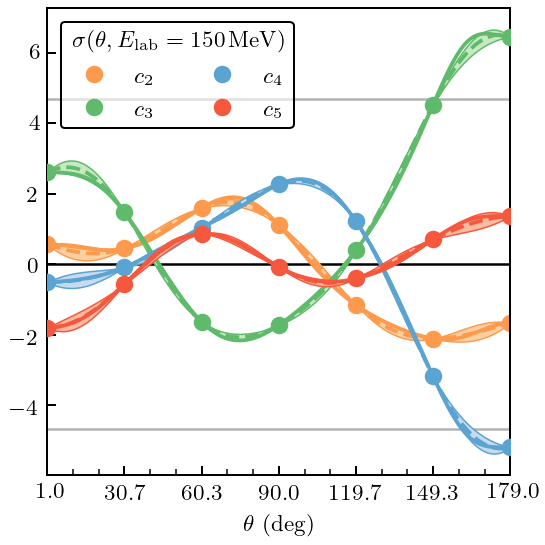

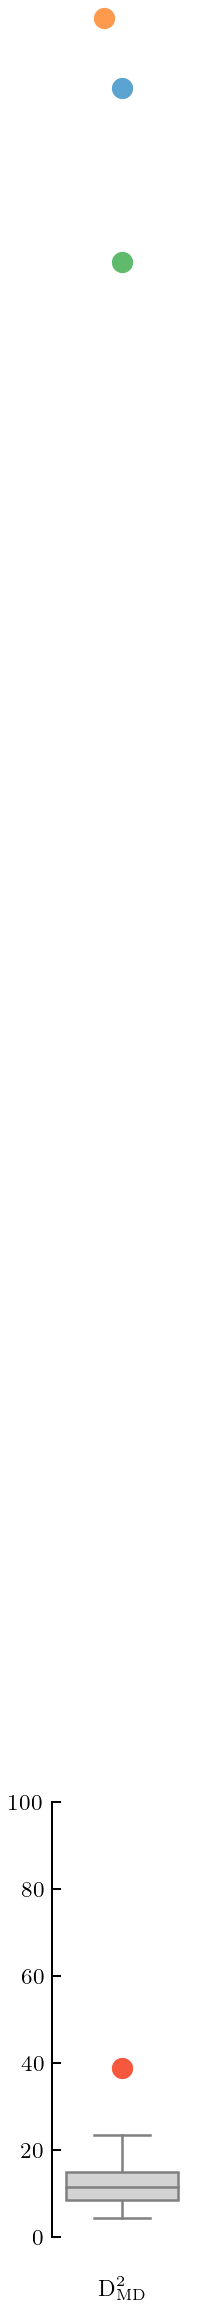

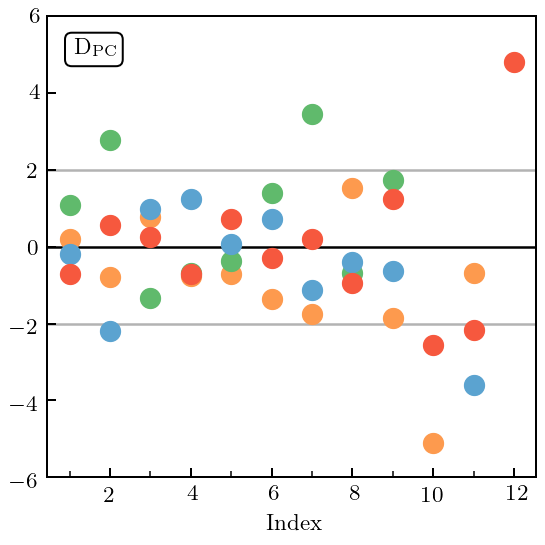

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 179.0
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338   2.81530879  2.76067007  2.70883087  2.6597973

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


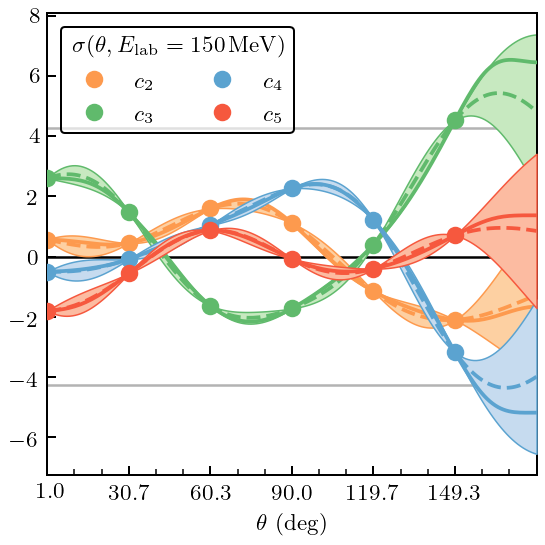

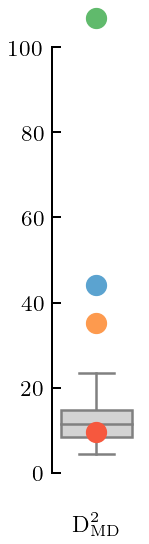

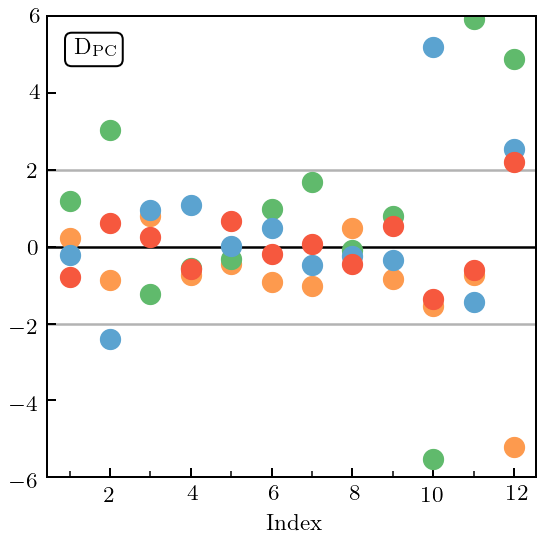

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 1.0
test last: 179 169.11111111111111
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338   2.81530879  2.76067007  2.70883087  2.65979737

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


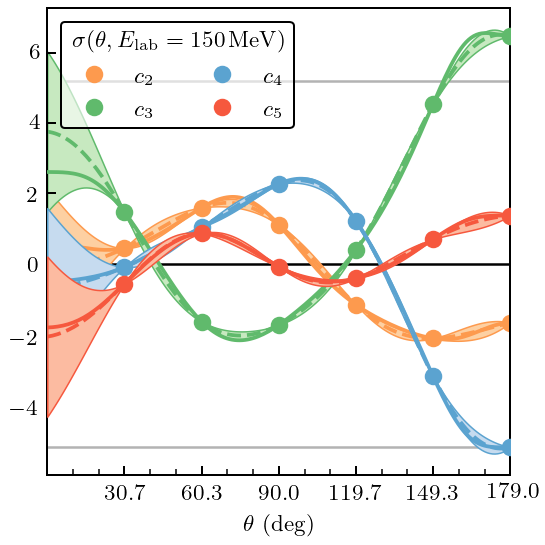

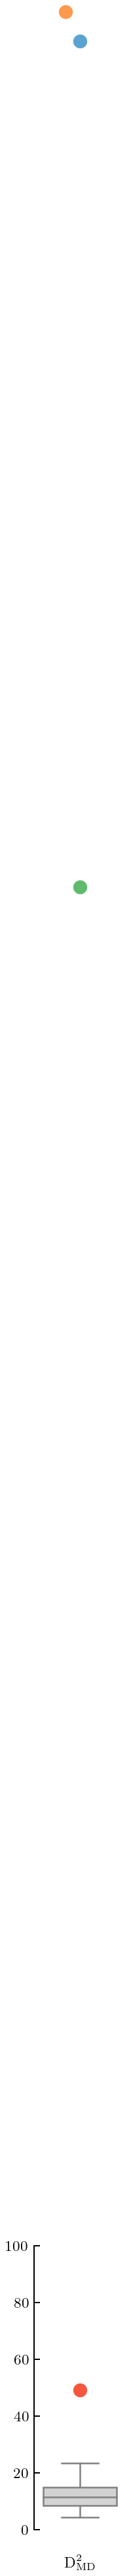

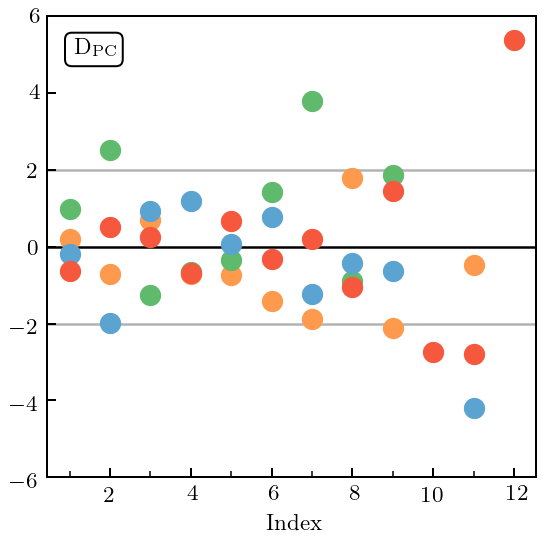

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.8887535068056811
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338   2.81530879  2.76067007 

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


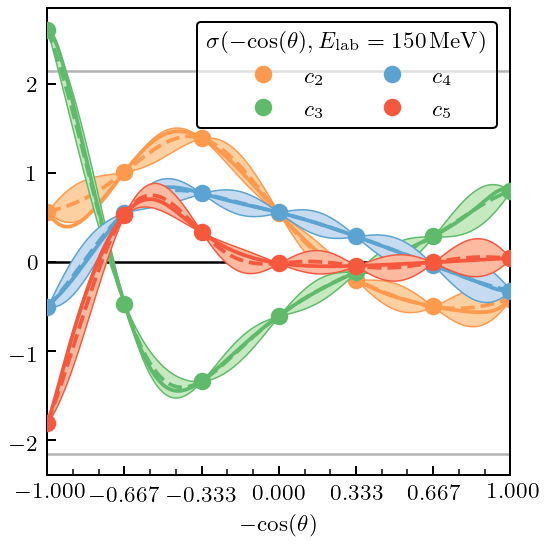

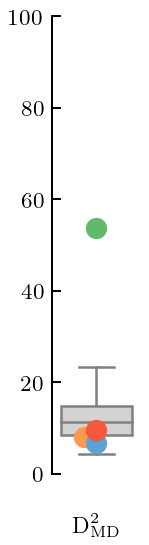

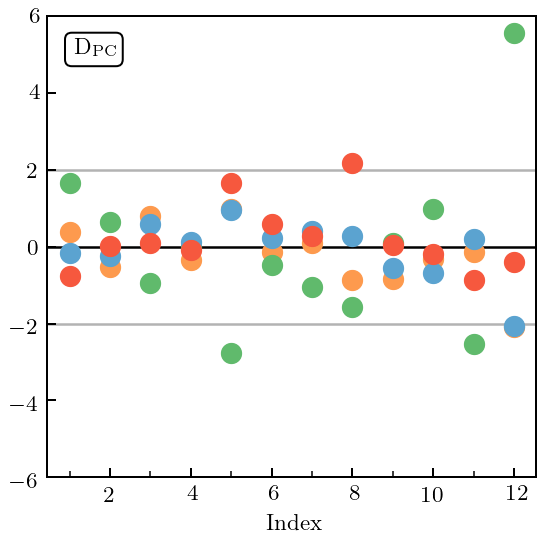

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.9998476951563913
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


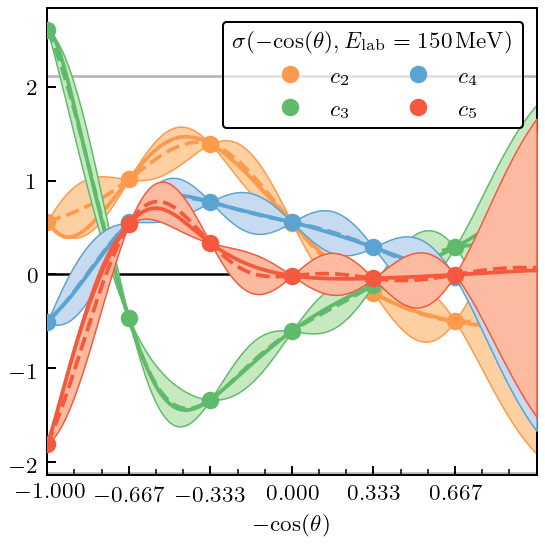

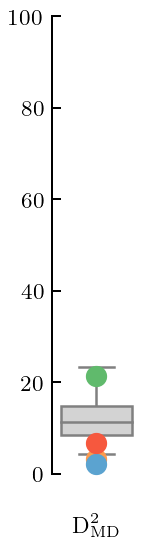

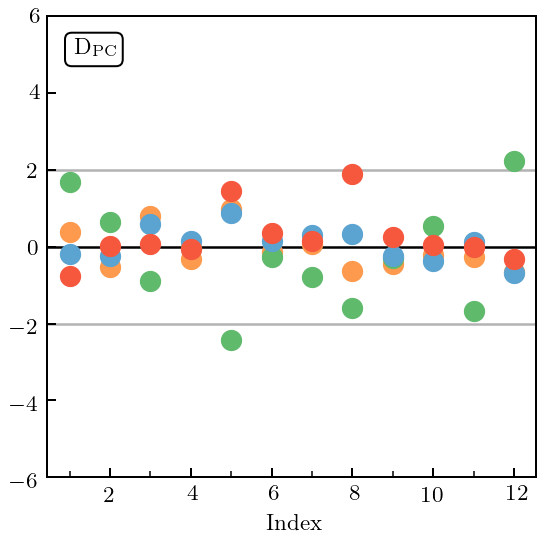

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.9998476951563913
test last: 0.9998476951563913 0.8887535068056811
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


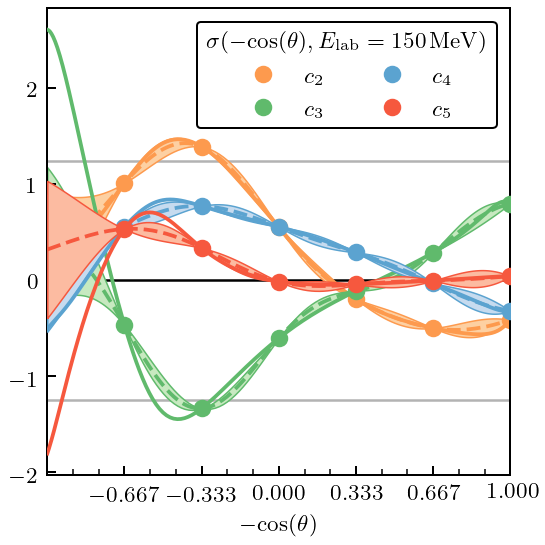

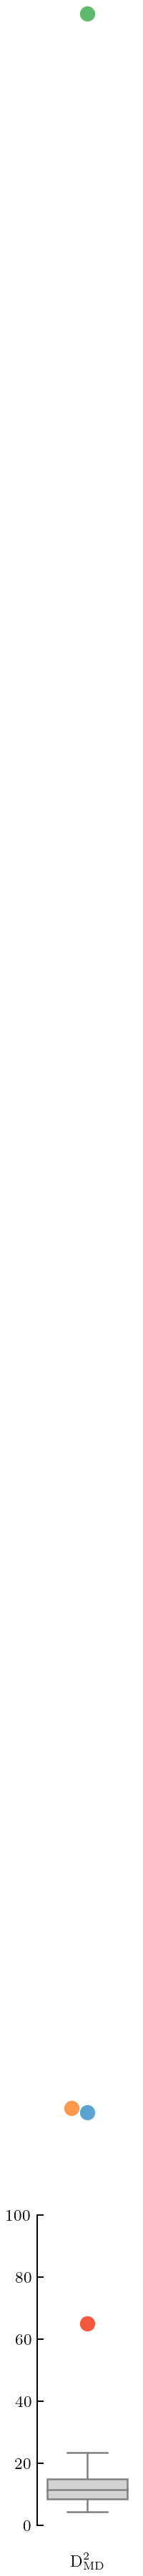

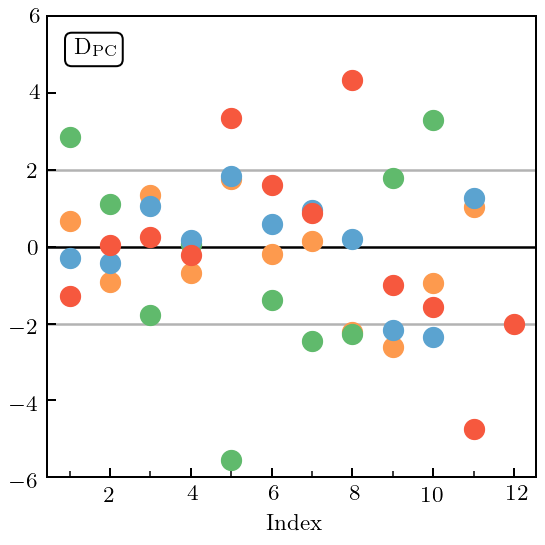

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 4.629848587659999 33.84641810851793
test last: 530.5280999631028 501.3115304422448
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338   2.81530879  2.76067007  2.708

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


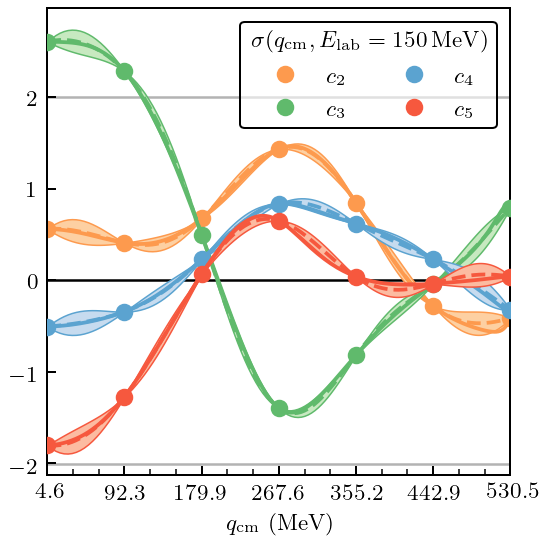

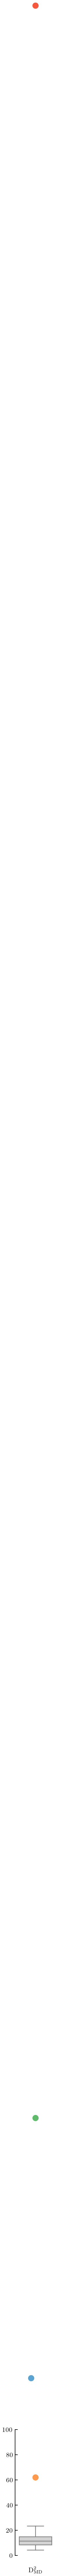

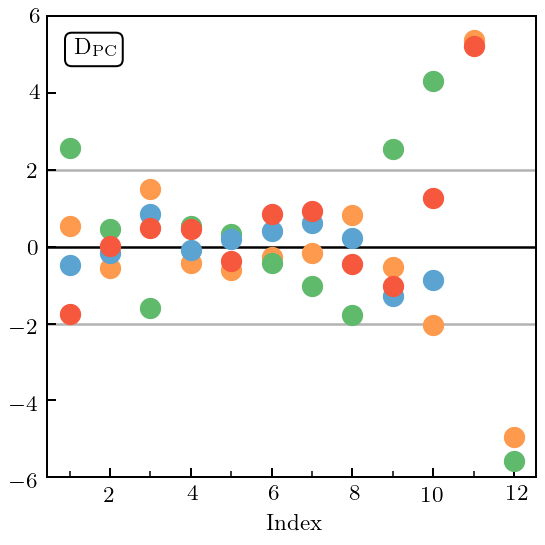

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 4.629848587659999 33.84641810851793
test last: 530.5280999631028 530.5280999631028
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338   2.8

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


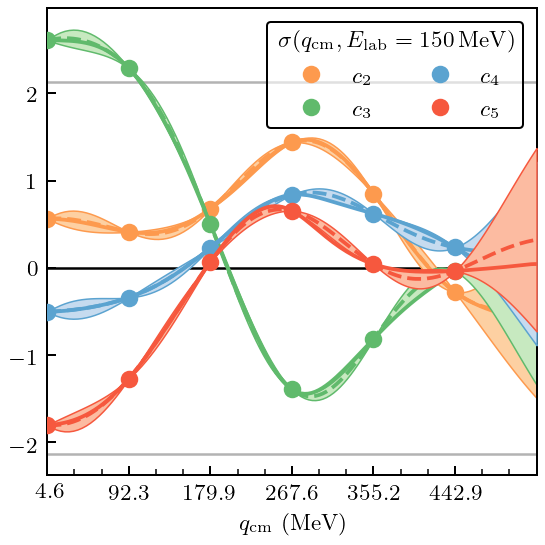

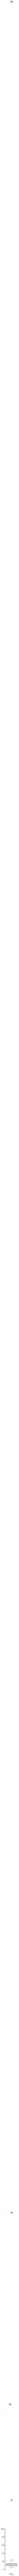

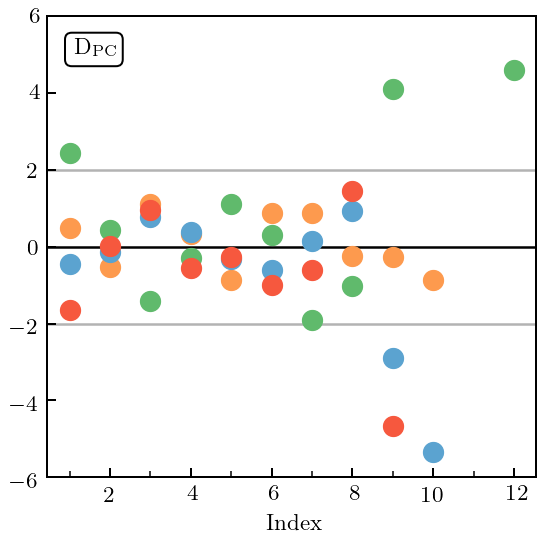

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 4.629848587659999 4.629848587659999
test last: 530.5280999631028 501.3115304422448
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338   2.8

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


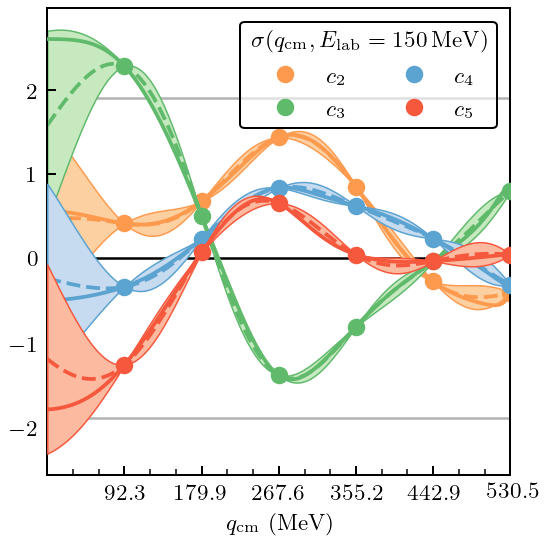

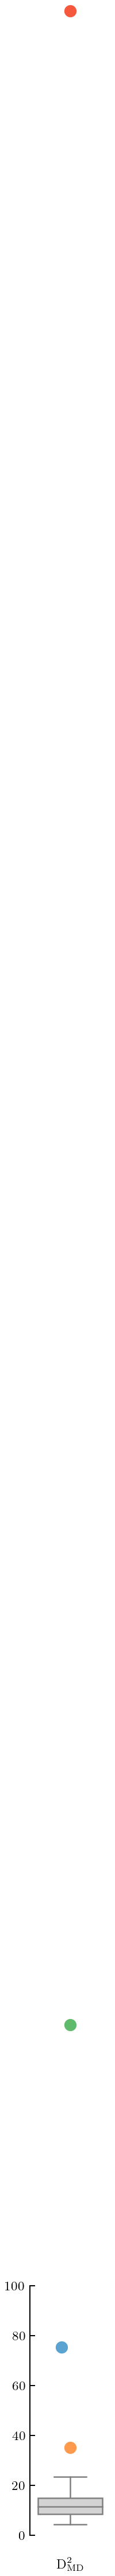

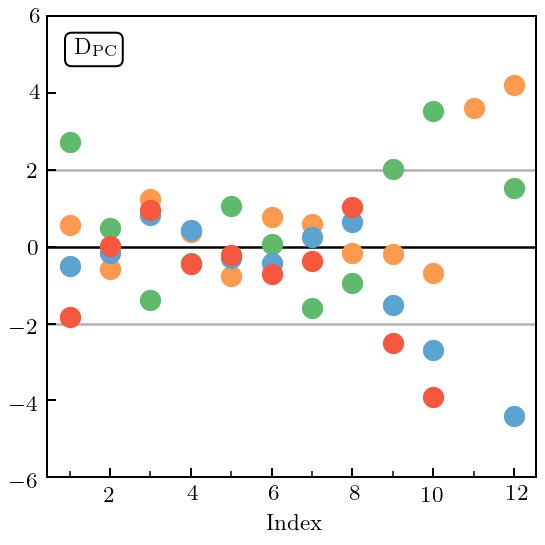

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 21.435497944657286 15656.914906417735
test last: 281460.06485046004 265824.585441987
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338   2.81530879  2.76067007  2.7

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


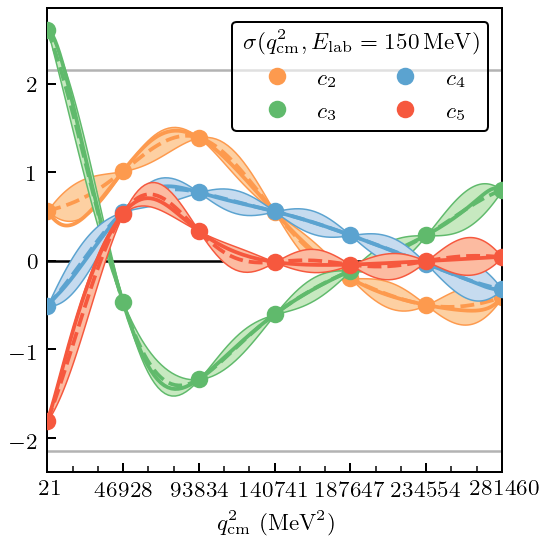

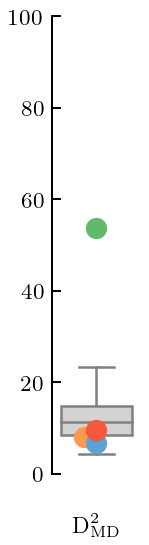

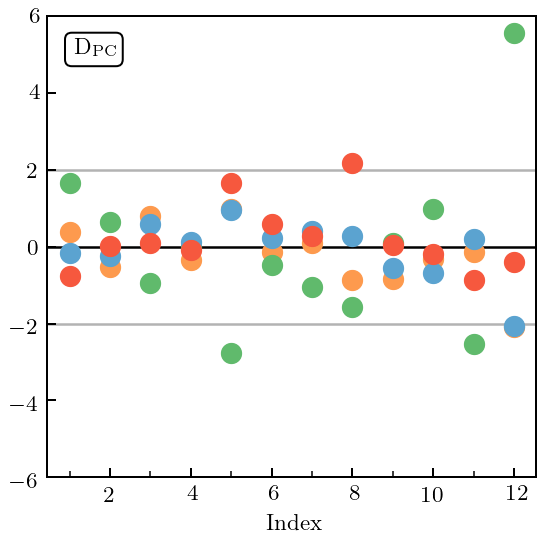

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 21.435497944657286 15656.914906417735
test last: 281460.06485046004 281460.06485046004
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338  

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


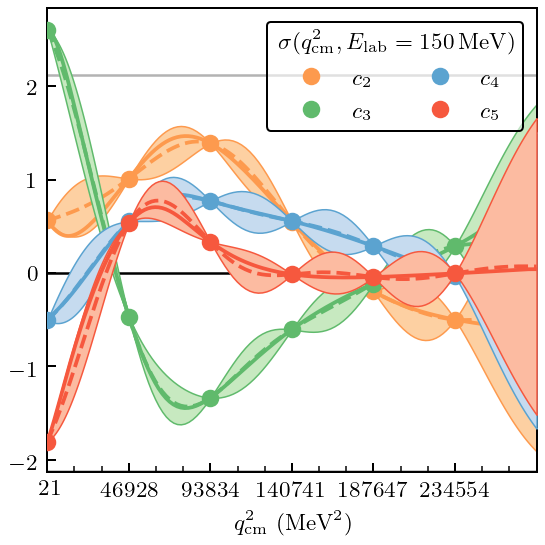

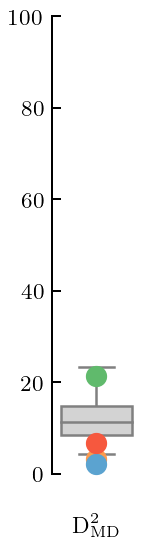

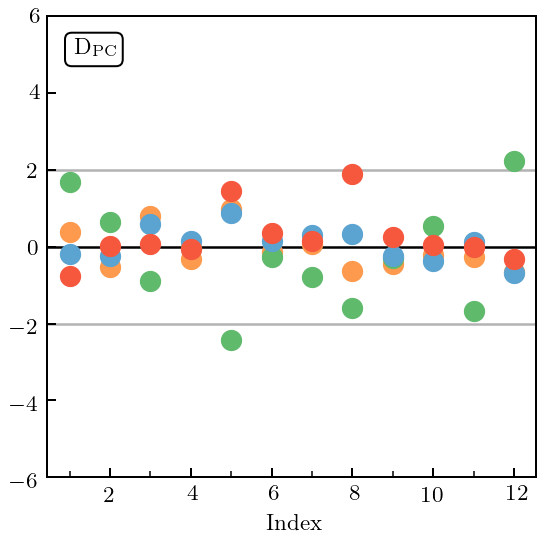

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 21.435497944657286 21.435497944657286
test last: 281460.06485046004 265824.585441987
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
ref = [ 9.14856871  9.12514976  9.08653356  9.03332692  8.96634778  8.88659573
  8.79521675  8.69346421  8.58265797  8.4641435   8.33925305  8.20927034
  8.07540027  7.93874451  7.80028369  7.66086623  7.5212038   7.3818727
  7.24332051  7.10587702  6.96976826  6.83513261  6.70203787  6.57049825
  6.44049059  6.31196896  6.18487728  6.05915966  5.93476831  5.81166908
  5.68984476  5.56929646  5.45004341  5.33212137  5.21558023  5.10048105
  4.98689278  4.87488912  4.76454558  4.65593691  4.54913518  4.44420831
  4.34121929  4.2402259   4.14128096  4.04443293  3.9497268   3.85720516
  3.76690931  3.67888027  3.59315959  3.50979003  3.42881576  3.3502824
  3.27423658  3.20072536  3.12979522  3.06149105  2.99585489  2.93292482
  2.8727338   2

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


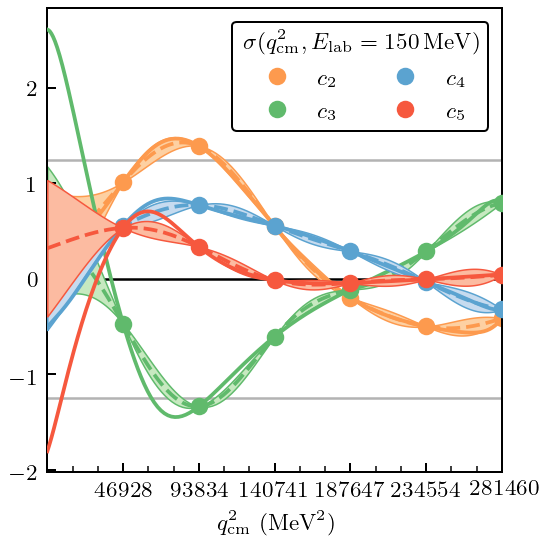

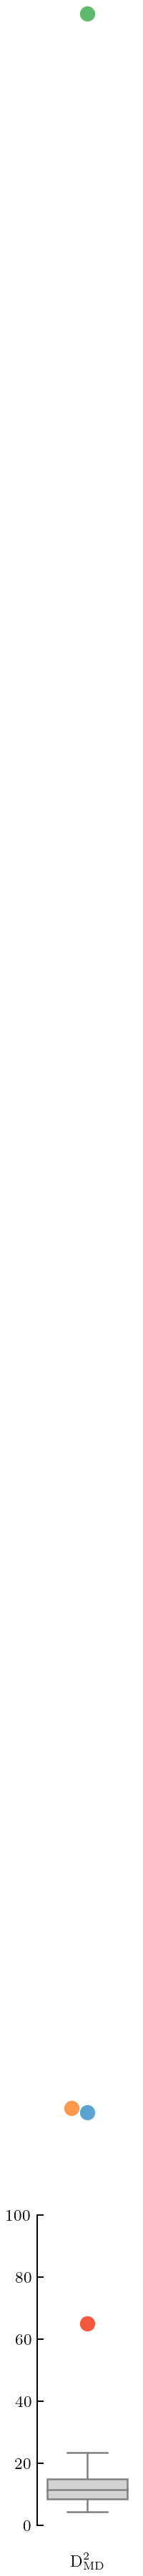

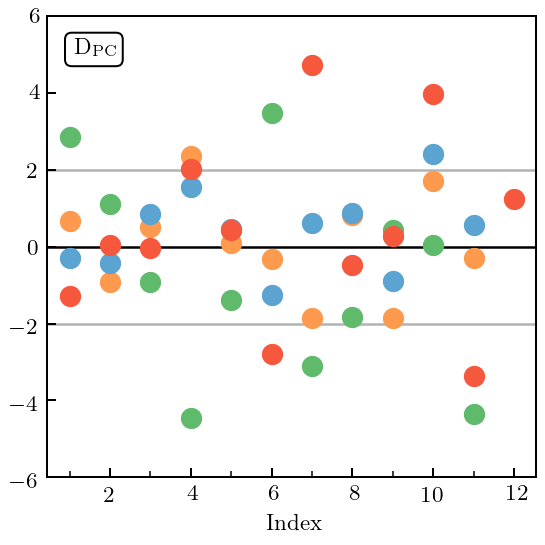

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 169.11111111111111
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[-0.10479616 -0.34680584  0.23560539 -0.29265216]
 [-0.14324303 -0.55266888  0.39737826 -0.63265872]
 [ 0.08204497 -0.0688327   0.23317986 -1.57275425]
 [ 0.34908792  0.73663378 -0.19312524 -2.08921162]
 [ 0.97122942  2.87171104 -1.2597887  -2.64375956]
 [ 1.18729577  3.52543582 -1.42659436 -2.36409082]
 [ 1.60776334  2.43674124 -0.71645319 -0.74190432]
 [ 1.95961367  0.89801958 -0.21118168  0.08835366]
 [ 2.82533235 -2.58591478  0.47947098  0.7631713 ]
 [ 3.17299852 -4.01109361  0.59219723  0.56494325]
 [ 3.12262052 -4.50994922  0.14713135 -0.14743258]
 [ 2.83121149 -3.90706867 -0.04190742 -0.34165668]]
RBF(length_scale=36.9) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


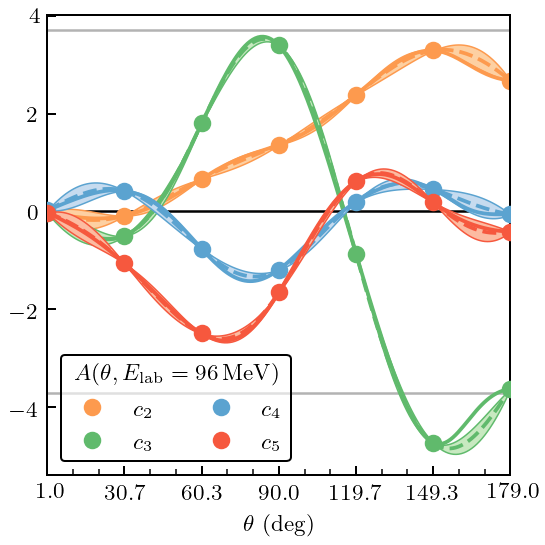

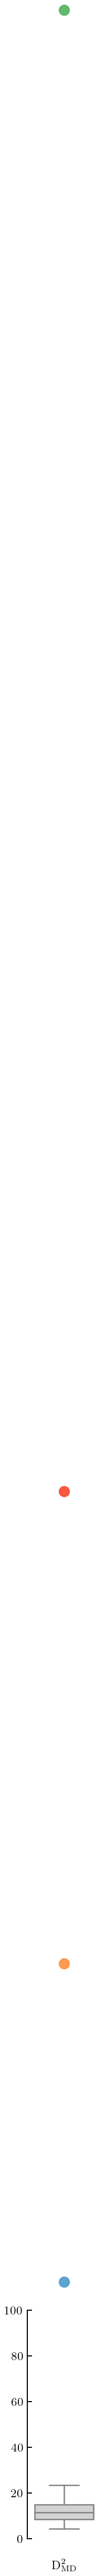

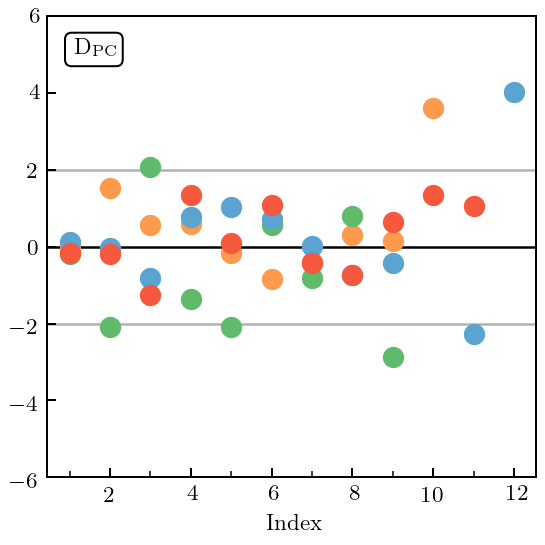

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 179.0
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[-0.10479616 -0.34680584  0.23560539 -0.29265216]
 [-0.14324303 -0.55266888  0.39737826 -0.63265872]
 [ 0.08204497 -0.0688327   0.23317986 -1.57275425]
 [ 0.34908792  0.73663378 -0.19312524 -2.08921162]
 [ 0.97122942  2.87171104 -1.2597887  -2.64375956]
 [ 1.18729577  3.52543582 -1.42659436 -2.36409082]
 [ 1.60776334  2.43674124 -0.71645319 -0.74190432]
 [ 1.95961367  0.89801958 -0.21118168  0.08835366]
 [ 2.82533235 -2.58591478  0.47947098  0.7631713 ]
 [ 3.17299852 -4.01109361  0.59219723  0.56494325]
 [ 3.12262052 -4.50994922  0.14713135 -0.14743258]
 [ 2.83121149 -3.90706867 -0.04190742 -0.34165668]]
RBF(length_scale=36.7) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


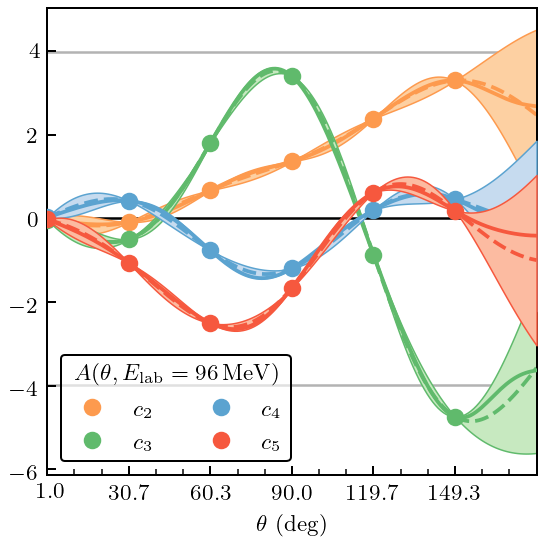

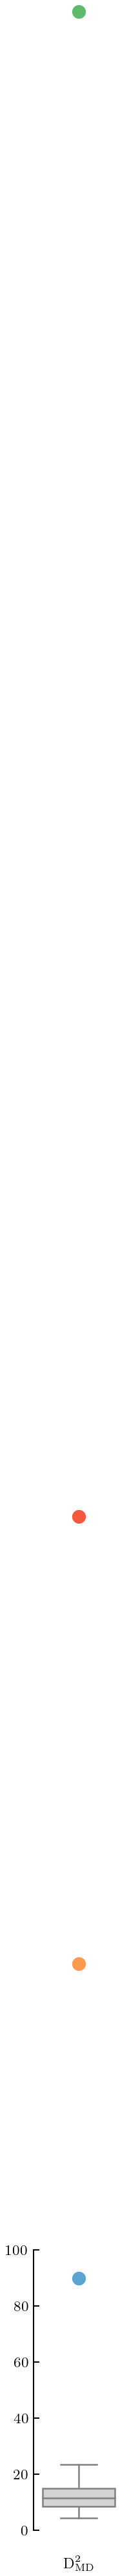

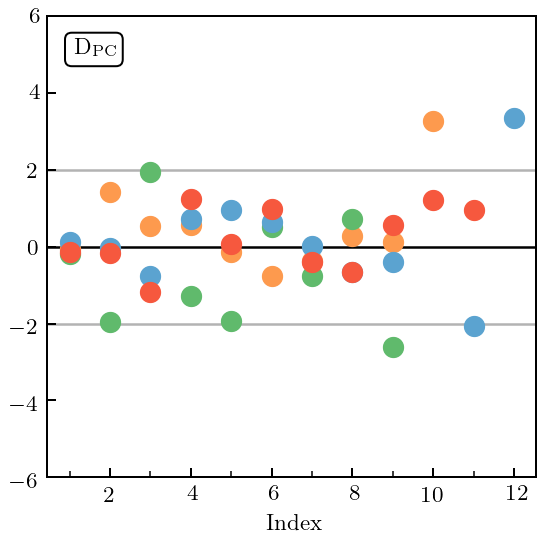

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 1.0
test last: 179 169.11111111111111
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[-0.10479616 -0.34680584  0.23560539 -0.29265216]
 [-0.14324303 -0.55266888  0.39737826 -0.63265872]
 [ 0.08204497 -0.0688327   0.23317986 -1.57275425]
 [ 0.34908792  0.73663378 -0.19312524 -2.08921162]
 [ 0.97122942  2.87171104 -1.2597887  -2.64375956]
 [ 1.18729577  3.52543582 -1.42659436 -2.36409082]
 [ 1.60776334  2.43674124 -0.71645319 -0.74190432]
 [ 1.95961367  0.89801958 -0.21118168  0.08835366]
 [ 2.82533235 -2.58591478  0.47947098  0.7631713 ]
 [ 3.17299852 -4.01109361  0.59219723  0.56494325]
 [ 3.12262052 -4.50994922  0.14713135 -0.14743258]
 [ 2.83121149 -3.90706867 -0.04190742 -0.34165668]]
RBF(length_scale=36.1) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


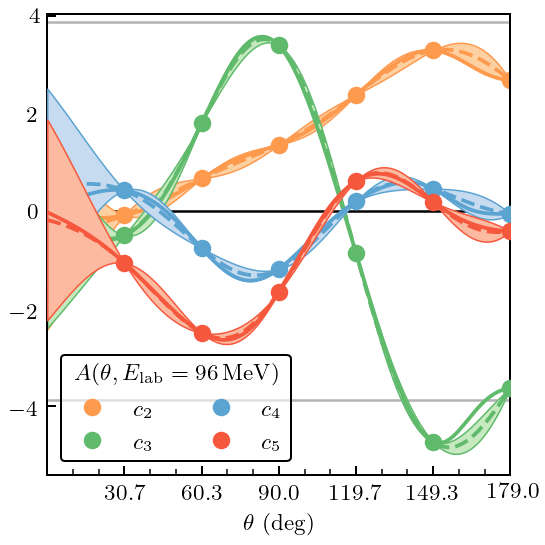

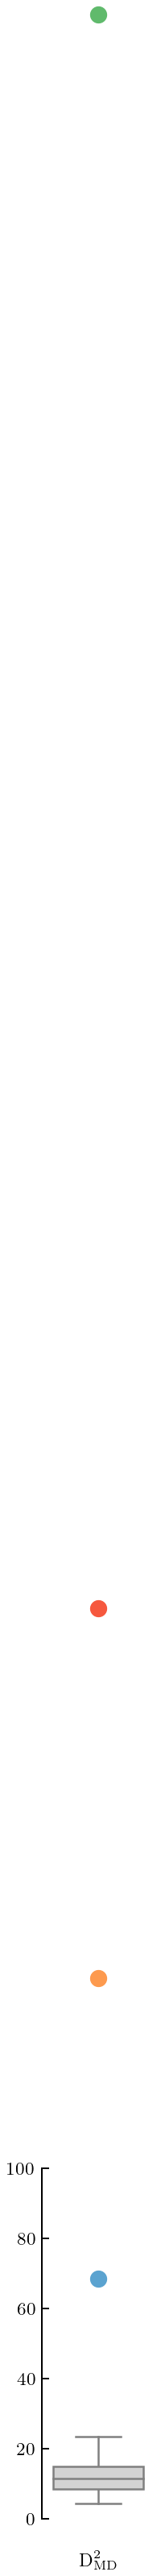

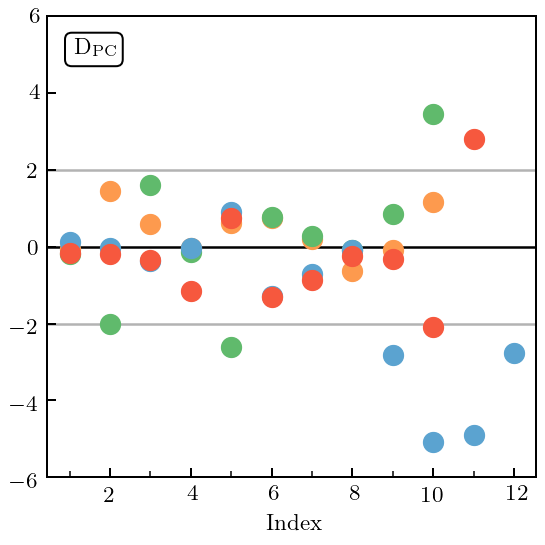

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.8887535068056811
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[-0.11777293 -0.55318341  0.43459066 -0.90625364]
 [ 0.04711011 -0.16342742  0.27719293 -1.46571205]
 [ 0.49116564  1.18143262 -0.43958297 -1.89271449]
 [ 0.63849723  1.6212339  -0.64177356 -1.58137511]
 [ 0.7028967   1.66442217 -0.5483017  -0.75934005]
 [ 0.68132895  1.44348046 -0.41222238 -0.47387428]
 [ 0.65880087  0.82595038 -0.17127557 -0.13501427]
 [ 0.67502608  0.50496269 -0.08826856 -0.04688809]
 [ 0.75175856 -0.05291888  0.00859741  0.03149145]
 [ 0.80097242 -0.27646068  0.0320935   0.03921468]
 [ 0.87479941 -0.59526778  0.04367394  0.01974035]
 [ 0.83793036 -0.61754727  0.02365166  0.00195732]]
RBF(length_scale=0.332) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


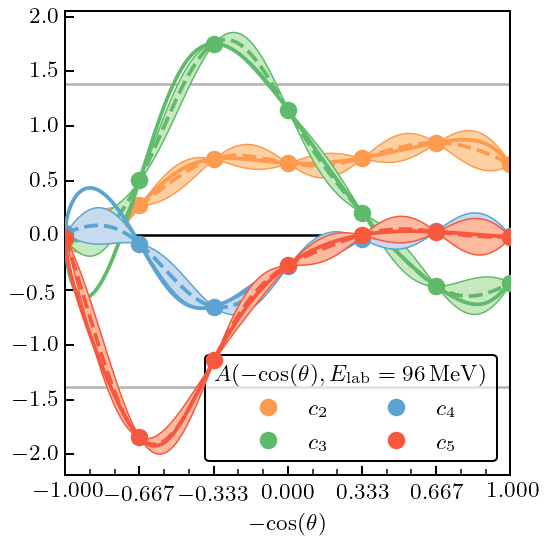

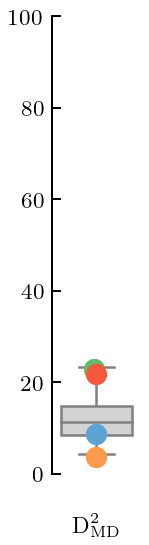

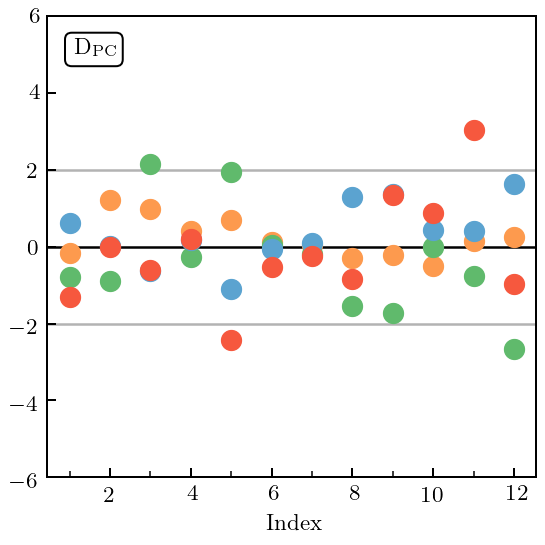

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.9998476951563913
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[-0.11777293 -0.55318341  0.43459066 -0.90625364]
 [ 0.04711011 -0.16342742  0.27719293 -1.46571205]
 [ 0.49116564  1.18143262 -0.43958297 -1.89271449]
 [ 0.63849723  1.6212339  -0.64177356 -1.58137511]
 [ 0.7028967   1.66442217 -0.5483017  -0.75934005]
 [ 0.68132895  1.44348046 -0.41222238 -0.47387428]
 [ 0.65880087  0.82595038 -0.17127557 -0.13501427]
 [ 0.67502608  0.50496269 -0.08826856 -0.04688809]
 [ 0.75175856 -0.05291888  0.00859741  0.03149145]
 [ 0.80097242 -0.27646068  0.0320935   0.03921468]
 [ 0.87479941 -0.59526778  0.04367394  0.01974035]
 [ 0.83793036 -0.61754727  0.02365166  0.00195732]]
RBF(length_scale=0.325) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


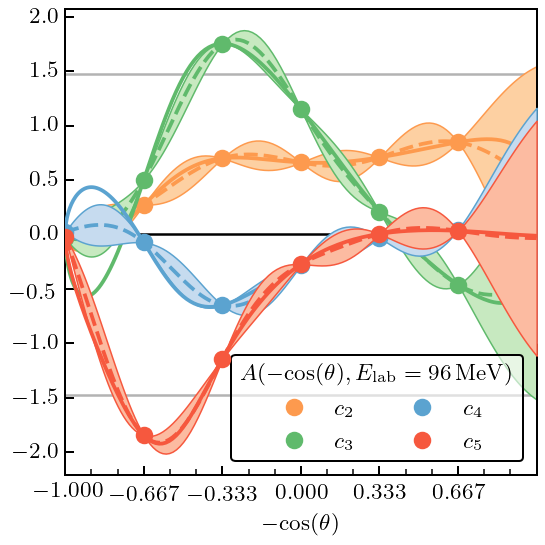

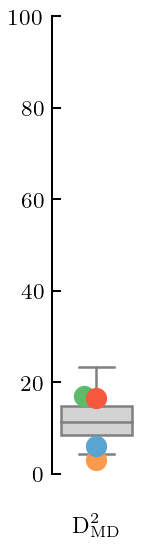

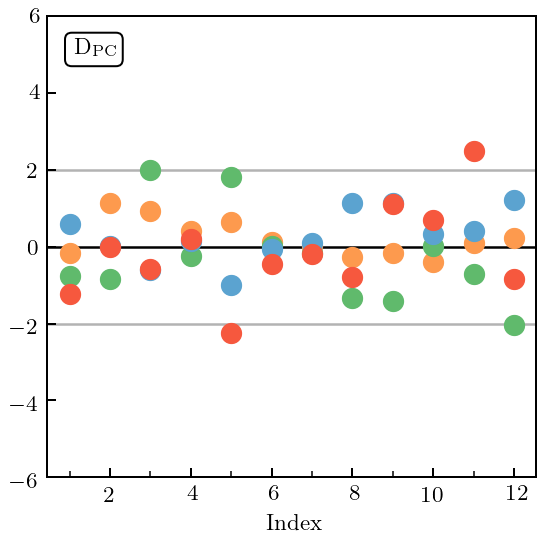

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.9998476951563913
test last: 0.9998476951563913 0.8887535068056811
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[-0.11777293 -0.55318341  0.43459066 -0.90625364]
 [ 0.04711011 -0.16342742  0.27719293 -1.46571205]
 [ 0.49116564  1.18143262 -0.43958297 -1.89271449]
 [ 0.63849723  1.6212339  -0.64177356 -1.58137511]
 [ 0.7028967   1.66442217 -0.5483017  -0.75934005]
 [ 0.68132895  1.44348046 -0.41222238 -0.47387428]
 [ 0.65880087  0.82595038 -0.17127557 -0.13501427]
 [ 0.67502608  0.50496269 -0.08826856 -0.04688809]
 [ 0.75175856 -0.05291888  0.00859741  0.03149145]
 [ 0.80097242 -0.27646068  0.0320935   0.03921468]
 [ 0.87479941 -0.59526778  0.04367394  0.01974035]
 [ 0.83793036 -0.61754727  0.02365166  0.00195732]]
RBF(length_scale=0.411) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


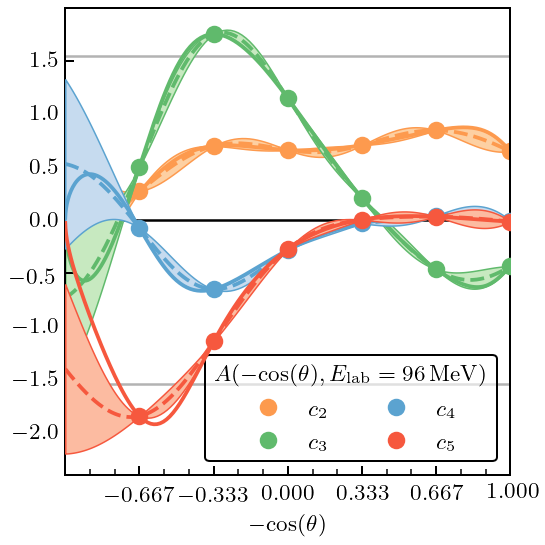

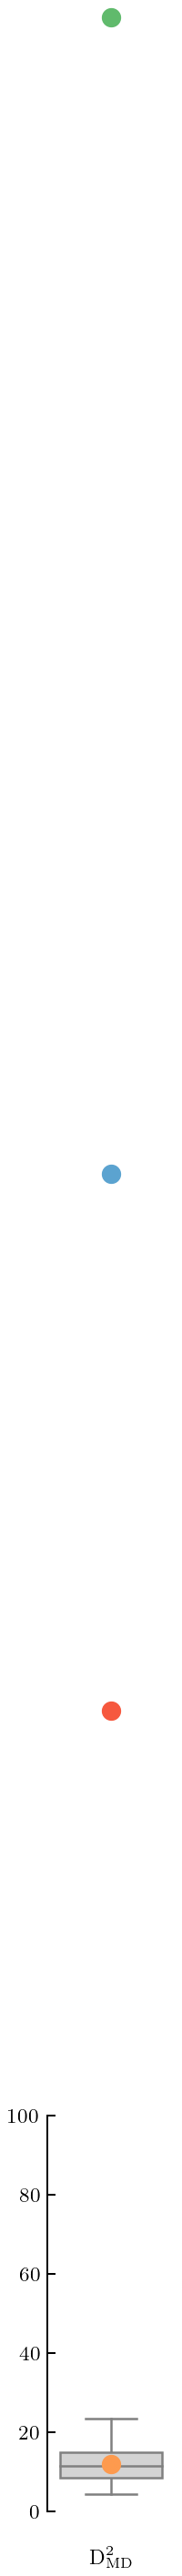

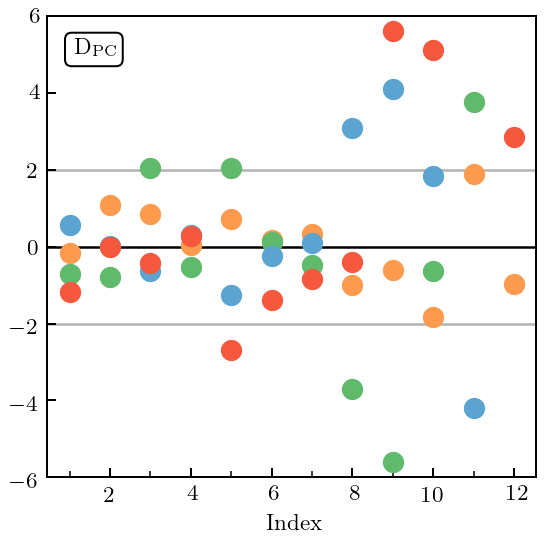

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 3.703878847885973 27.077134324214448
test last: 424.4224774217985 401.04922194547004
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[-0.0745426  -0.23902927  0.16107441 -0.19032638]
 [-0.12326005 -0.42140486  0.28910448 -0.37847139]
 [-0.12343468 -0.56075306  0.43409119 -0.87025468]
 [-0.0562506  -0.42929566  0.39803022 -1.1749136 ]
 [ 0.22617966  0.3572919   0.00534292 -1.78933116]
 [ 0.416755    0.94849384 -0.31636908 -1.92204163]
 [ 0.68624684  1.73630119 -0.66455729 -1.3026109 ]
 [ 0.70535645  1.69560144 -0.57358454 -0.82932771]
 [ 0.65811178  1.00505812 -0.22815597 -0.20317904]
 [ 0.67360516  0.52283528 -0.09232198 -0.05085435]
 [ 0.81336534 -0.32704954  0.03615422  0.03891585]
 [ 0.87517524 -0.60179909  0.04300105  0.0185057 ]]
RBF(length_scale=78.9) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


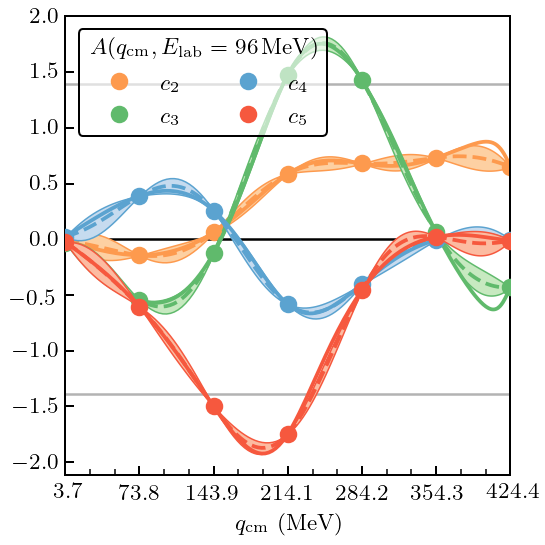

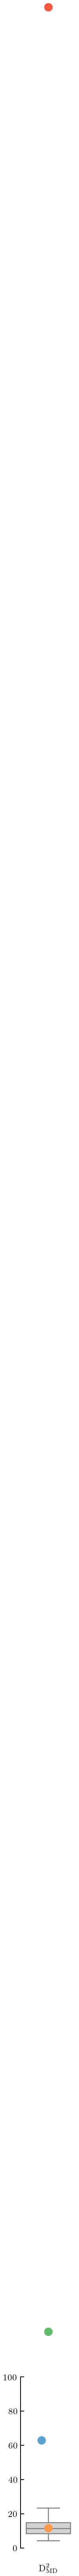

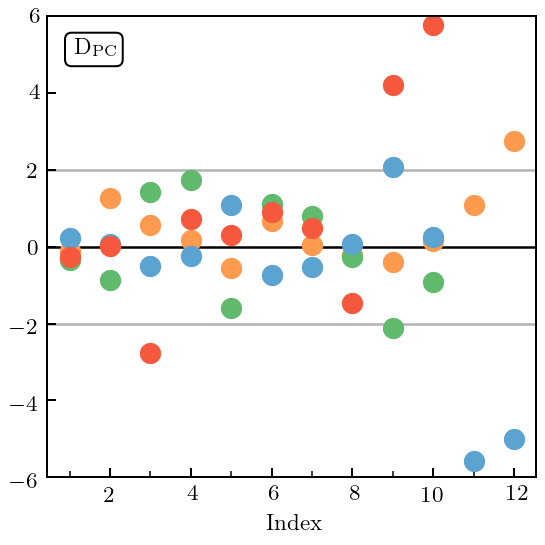

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 3.703878847885973 27.077134324214448
test last: 424.4224774217985 424.4224774217985
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[-0.0745426  -0.23902927  0.16107441 -0.19032638]
 [-0.12326005 -0.42140486  0.28910448 -0.37847139]
 [-0.12343468 -0.56075306  0.43409119 -0.87025468]
 [-0.0562506  -0.42929566  0.39803022 -1.1749136 ]
 [ 0.22617966  0.3572919   0.00534292 -1.78933116]
 [ 0.416755    0.94849384 -0.31636908 -1.92204163]
 [ 0.68624684  1.73630119 -0.66455729 -1.3026109 ]
 [ 0.70535645  1.69560144 -0.57358454 -0.82932771]
 [ 0.65811178  1.00505812 -0.22815597 -0.20317904]
 [ 0.67360516  0.52283528 -0.09232198 -0.05085435]
 [ 0.81336534 -0.32704954  0.03615422  0.03891585]
 [ 0.87517524 -0.60179909  0.04300105  0.0185057 ]]
RBF(length_scale=78.3) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


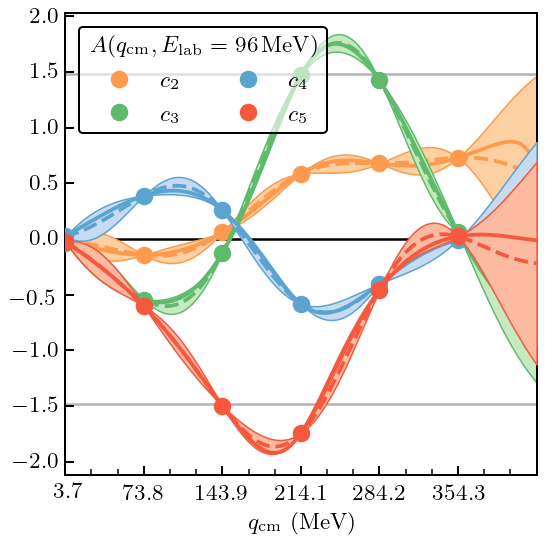

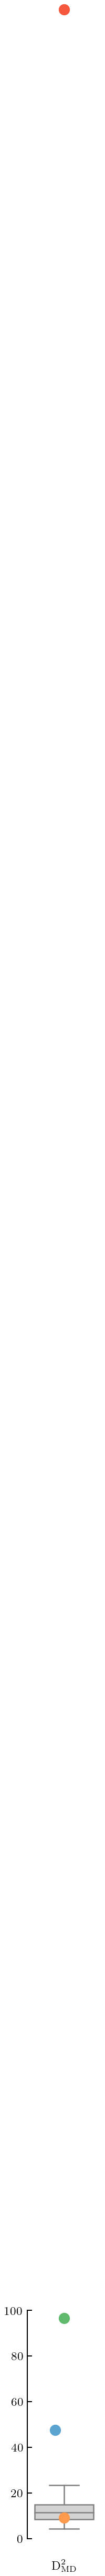

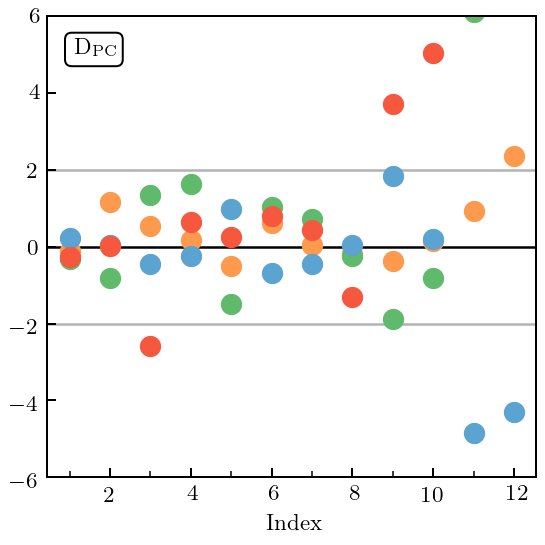

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 3.703878847885973 3.703878847885973
test last: 424.4224774217985 401.04922194547004
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[-0.0745426  -0.23902927  0.16107441 -0.19032638]
 [-0.12326005 -0.42140486  0.28910448 -0.37847139]
 [-0.12343468 -0.56075306  0.43409119 -0.87025468]
 [-0.0562506  -0.42929566  0.39803022 -1.1749136 ]
 [ 0.22617966  0.3572919   0.00534292 -1.78933116]
 [ 0.416755    0.94849384 -0.31636908 -1.92204163]
 [ 0.68624684  1.73630119 -0.66455729 -1.3026109 ]
 [ 0.70535645  1.69560144 -0.57358454 -0.82932771]
 [ 0.65811178  1.00505812 -0.22815597 -0.20317904]
 [ 0.67360516  0.52283528 -0.09232198 -0.05085435]
 [ 0.81336534 -0.32704954  0.03615422  0.03891585]
 [ 0.87517524 -0.60179909  0.04300105  0.0185057 ]]
RBF(length_scale=78.3) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


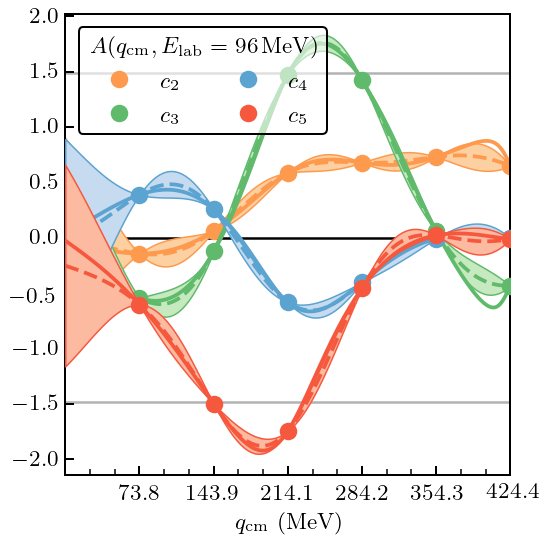

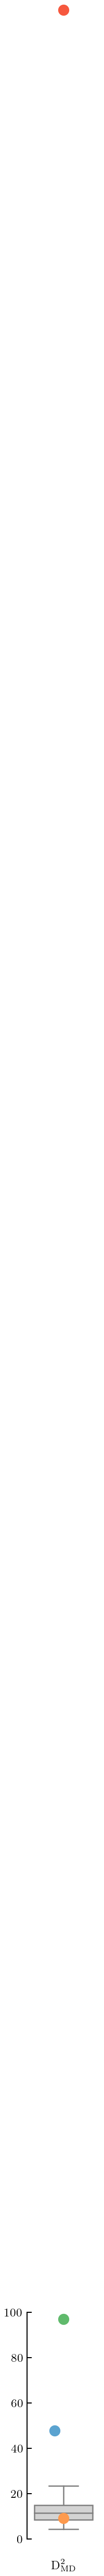

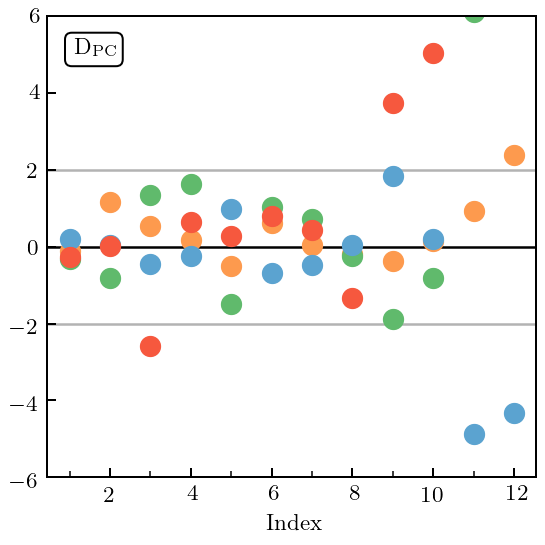

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 13.718718519817124 10020.425419760773
test last: 180134.43934085703 170127.7326396161
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[-0.11777293 -0.55318341  0.43459066 -0.90625364]
 [ 0.04711011 -0.16342742  0.27719293 -1.46571205]
 [ 0.49116564  1.18143262 -0.43958297 -1.89271449]
 [ 0.63849723  1.6212339  -0.64177356 -1.58137511]
 [ 0.7028967   1.66442217 -0.5483017  -0.75934005]
 [ 0.68132895  1.44348046 -0.41222238 -0.47387428]
 [ 0.65880087  0.82595038 -0.17127557 -0.13501427]
 [ 0.67502608  0.50496269 -0.08826856 -0.04688809]
 [ 0.75175856 -0.05291888  0.00859741  0.03149145]
 [ 0.80097242 -0.27646068  0.0320935   0.03921468]
 [ 0.87479941 -0.59526778  0.04367394  0.01974035]
 [ 0.83793036 -0.61754727  0.02365166  0.00195732]]
RBF(length_scale=2.99e+04) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


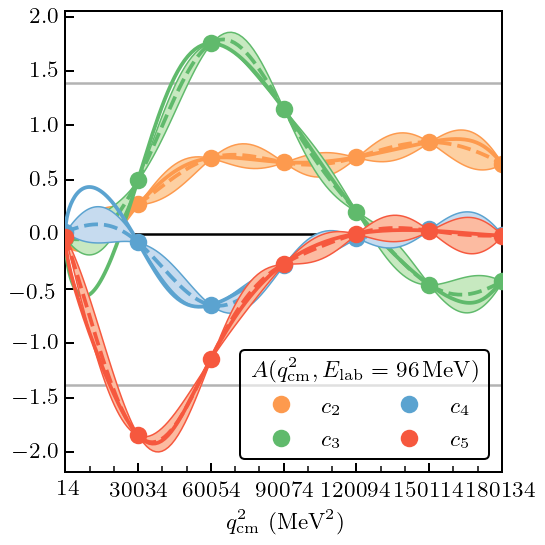

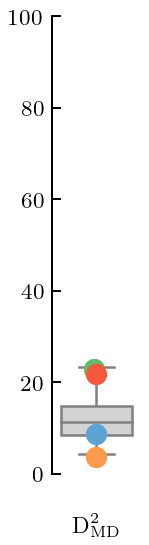

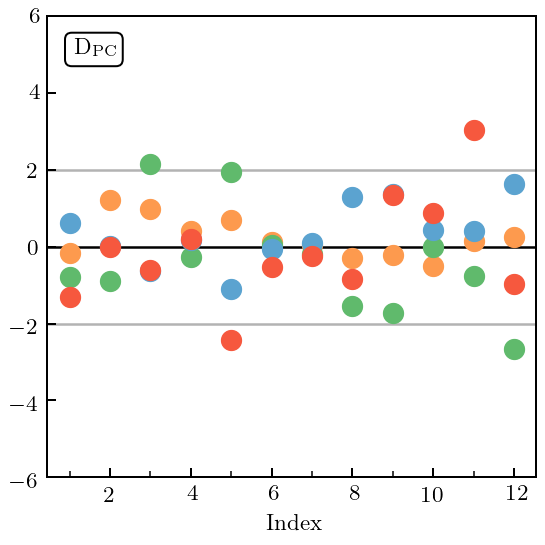

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 13.718718519817124 10020.425419760773
test last: 180134.43934085703 180134.43934085703
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[-0.11777293 -0.55318341  0.43459066 -0.90625364]
 [ 0.04711011 -0.16342742  0.27719293 -1.46571205]
 [ 0.49116564  1.18143262 -0.43958297 -1.89271449]
 [ 0.63849723  1.6212339  -0.64177356 -1.58137511]
 [ 0.7028967   1.66442217 -0.5483017  -0.75934005]
 [ 0.68132895  1.44348046 -0.41222238 -0.47387428]
 [ 0.65880087  0.82595038 -0.17127557 -0.13501427]
 [ 0.67502608  0.50496269 -0.08826856 -0.04688809]
 [ 0.75175856 -0.05291888  0.00859741  0.03149145]
 [ 0.80097242 -0.27646068  0.0320935   0.03921468]
 [ 0.87479941 -0.59526778  0.04367394  0.01974035]
 [ 0.83793036 -0.61754727  0.02365166  0.00195732]]
RBF(length_scale=2.93e+04) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


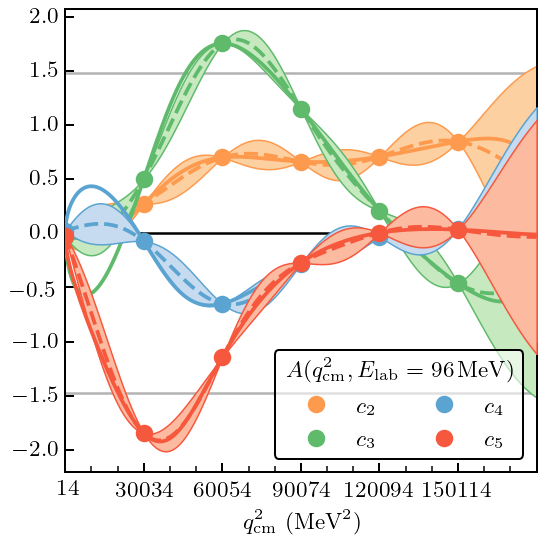

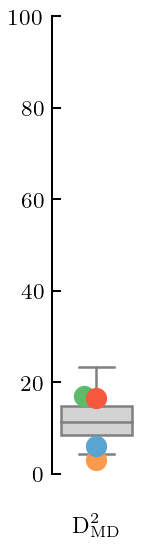

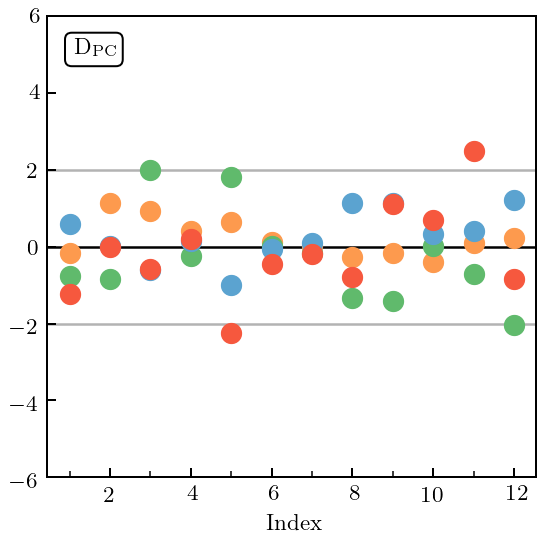

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 13.718718519817124 13.718718519817124
test last: 180134.43934085703 170127.7326396161
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[-0.11777293 -0.55318341  0.43459066 -0.90625364]
 [ 0.04711011 -0.16342742  0.27719293 -1.46571205]
 [ 0.49116564  1.18143262 -0.43958297 -1.89271449]
 [ 0.63849723  1.6212339  -0.64177356 -1.58137511]
 [ 0.7028967   1.66442217 -0.5483017  -0.75934005]
 [ 0.68132895  1.44348046 -0.41222238 -0.47387428]
 [ 0.65880087  0.82595038 -0.17127557 -0.13501427]
 [ 0.67502608  0.50496269 -0.08826856 -0.04688809]
 [ 0.75175856 -0.05291888  0.00859741  0.03149145]
 [ 0.80097242 -0.27646068  0.0320935   0.03921468]
 [ 0.87479941 -0.59526778  0.04367394  0.01974035]
 [ 0.83793036 -0.61754727  0.02365166  0.00195732]]
RBF(length_scale=3.7e+04) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


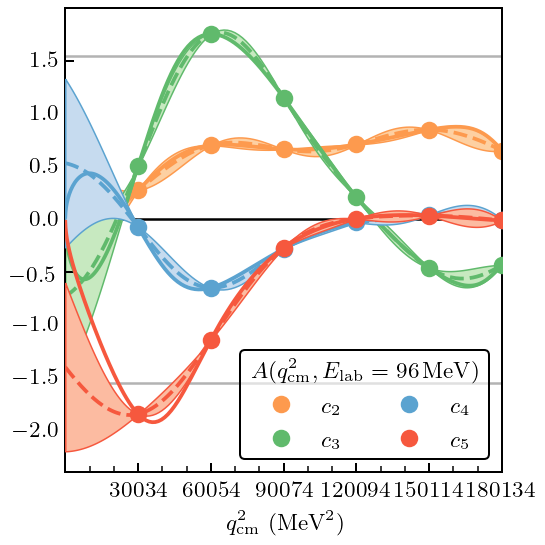

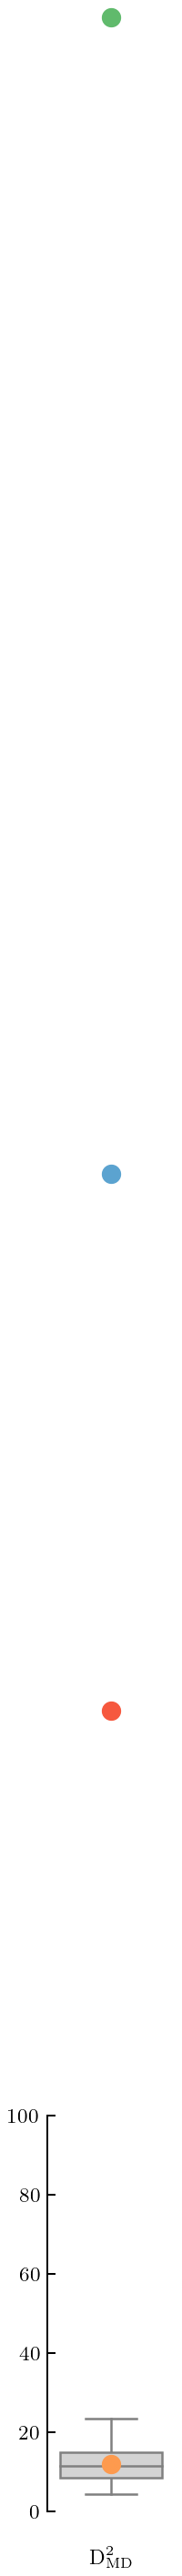

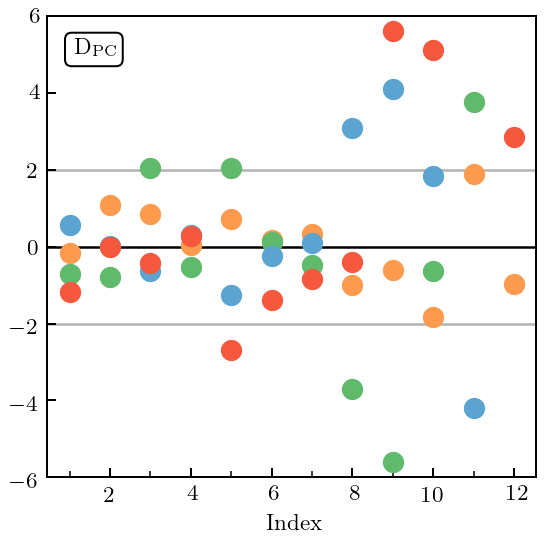

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 169.11111111111111
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[ 0.18457434 -0.75037873  0.60251062  0.21151336]
 [ 0.5010615  -1.35692682  1.26255824  0.31493681]
 [ 1.35480161 -0.75525604  2.16635137 -0.43824531]
 [ 1.88244339  0.50621506  1.90378255 -1.13660729]
 [ 2.98009009  2.85691143  0.22443649 -1.55392905]
 [ 2.95458662  2.99666006 -0.43724144 -1.16632726]
 [ 1.99693604  1.41295699 -0.67160574 -0.08279282]
 [ 1.88095678  0.31153523 -0.30986804  0.3498218 ]
 [ 2.21906687 -1.89932131  0.79476217  0.42643896]
 [ 2.61405273 -3.17141727  1.38256988  0.02859514]
 [ 3.26313352 -4.966693    1.67661598 -0.94478972]
 [ 2.60487733 -3.54124673  1.09584758 -0.94958181]]
RBF(length_scale=29.7) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


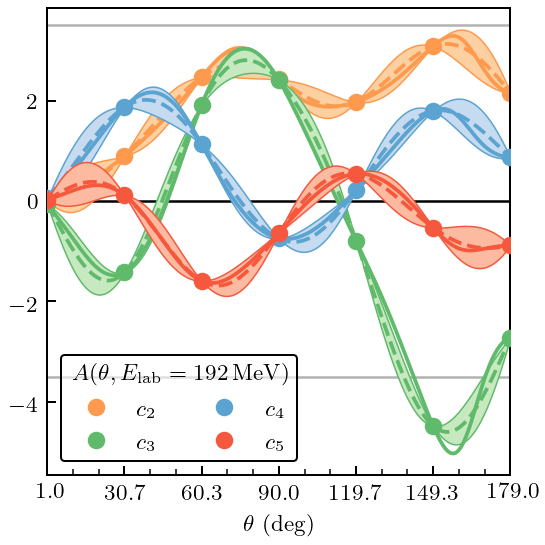

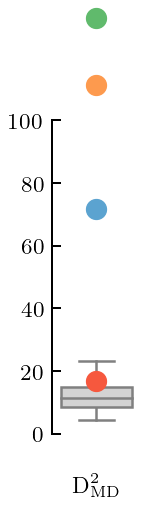

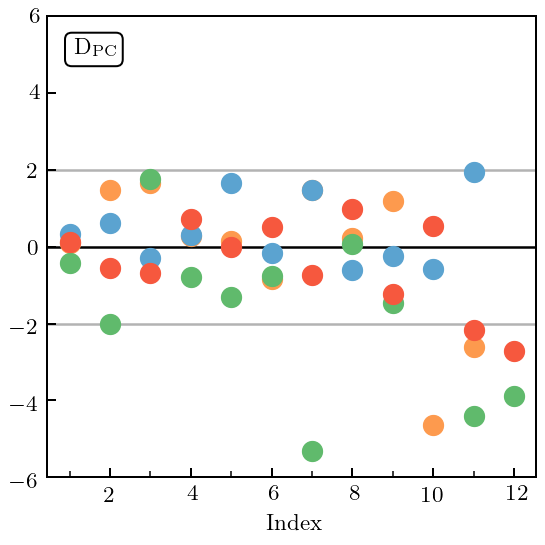

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 179.0
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 0.18457434 -0.75037873  0.60251062  0.21151336]
 [ 0.5010615  -1.35692682  1.26255824  0.31493681]
 [ 1.35480161 -0.75525604  2.16635137 -0.43824531]
 [ 1.88244339  0.50621506  1.90378255 -1.13660729]
 [ 2.98009009  2.85691143  0.22443649 -1.55392905]
 [ 2.95458662  2.99666006 -0.43724144 -1.16632726]
 [ 1.99693604  1.41295699 -0.67160574 -0.08279282]
 [ 1.88095678  0.31153523 -0.30986804  0.3498218 ]
 [ 2.21906687 -1.89932131  0.79476217  0.42643896]
 [ 2.61405273 -3.17141727  1.38256988  0.02859514]
 [ 3.26313352 -4.966693    1.67661598 -0.94478972]
 [ 2.60487733 -3.54124673  1.09584758 -0.94958181]]
RBF(length_scale=31) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


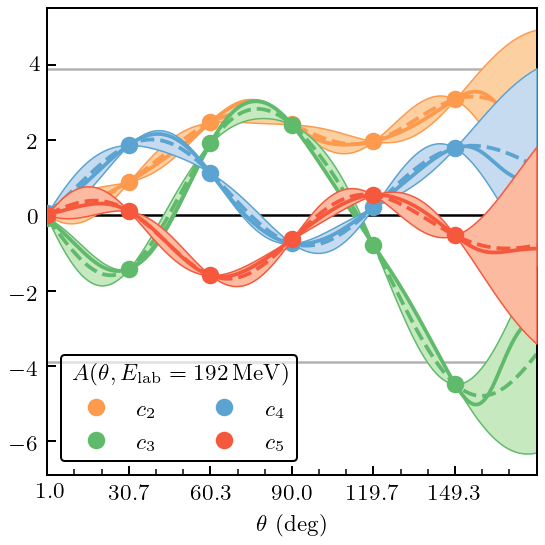

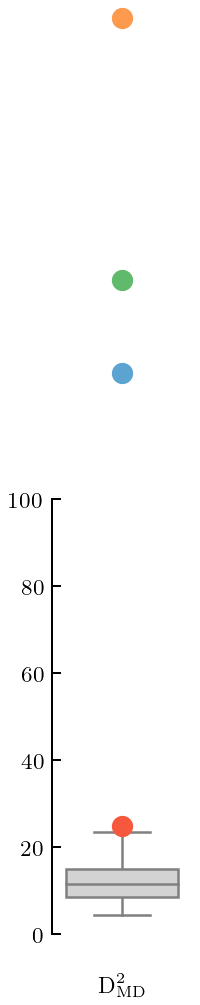

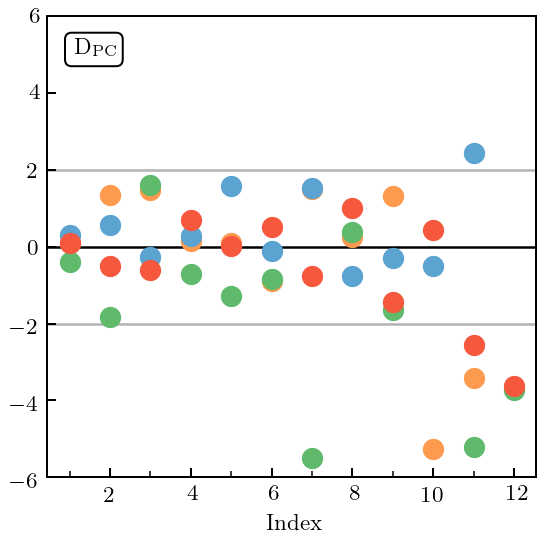

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 1.0
test last: 179 169.11111111111111
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 0.18457434 -0.75037873  0.60251062  0.21151336]
 [ 0.5010615  -1.35692682  1.26255824  0.31493681]
 [ 1.35480161 -0.75525604  2.16635137 -0.43824531]
 [ 1.88244339  0.50621506  1.90378255 -1.13660729]
 [ 2.98009009  2.85691143  0.22443649 -1.55392905]
 [ 2.95458662  2.99666006 -0.43724144 -1.16632726]
 [ 1.99693604  1.41295699 -0.67160574 -0.08279282]
 [ 1.88095678  0.31153523 -0.30986804  0.3498218 ]
 [ 2.21906687 -1.89932131  0.79476217  0.42643896]
 [ 2.61405273 -3.17141727  1.38256988  0.02859514]
 [ 3.26313352 -4.966693    1.67661598 -0.94478972]
 [ 2.60487733 -3.54124673  1.09584758 -0.94958181]]
RBF(length_scale=33.4) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


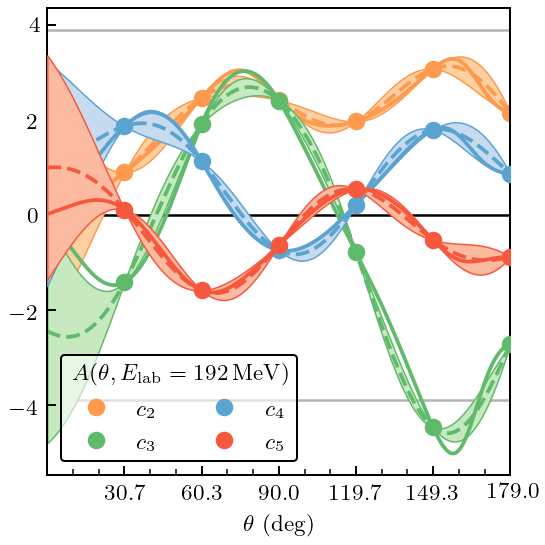

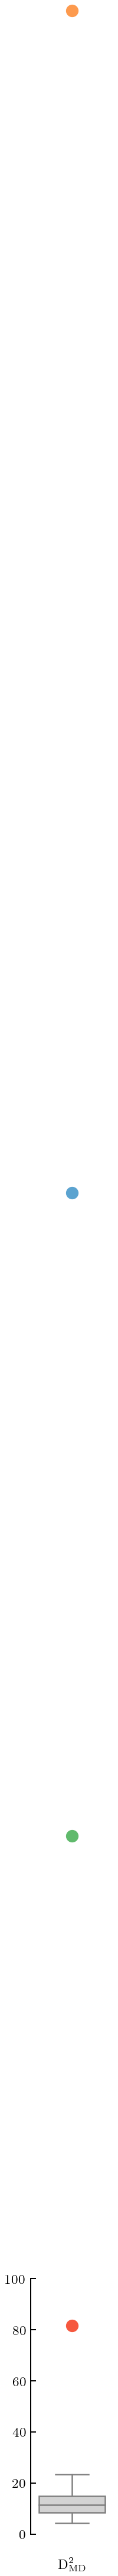

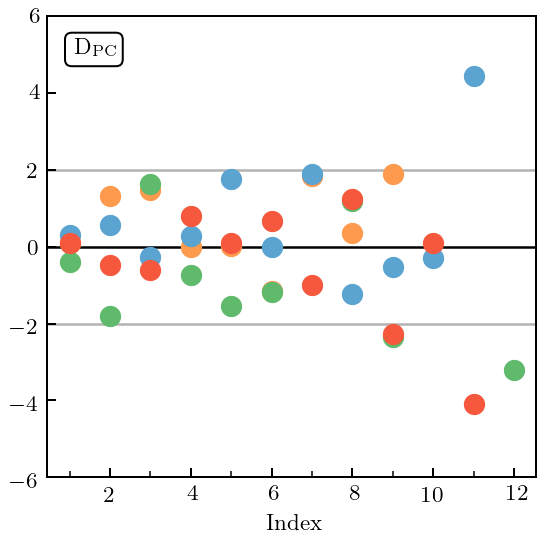

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.8887535068056811
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[ 0.75845437 -1.47880732  1.68544742  0.22570818]
 [ 1.27474822 -0.90957987  2.14877545 -0.32908094]
 [ 2.12130606  1.26318359  1.35748092 -1.29251646]
 [ 2.29109547  1.83471054  0.60269178 -1.11241569]
 [ 1.93912283  1.55094671 -0.11178491 -0.42520834]
 [ 1.56423656  1.19970867 -0.18517946 -0.23157546]
 [ 0.94606817  0.53677754 -0.14762627 -0.03631811]
 [ 0.78731608  0.28304681 -0.09786491  0.0067304 ]
 [ 0.66395882 -0.08641655  0.00412362  0.03572303]
 [ 0.65829916 -0.22338863  0.04620837  0.0308526 ]
 [ 0.75286396 -0.50211412  0.11513674 -0.00231888]
 [ 0.84868045 -0.65427987  0.12777944 -0.02527476]]
RBF(length_scale=0.276) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


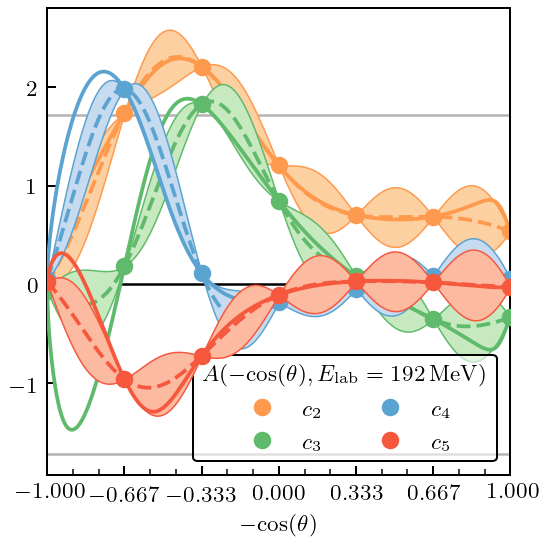

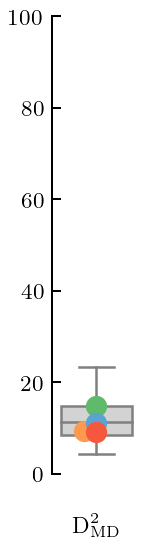

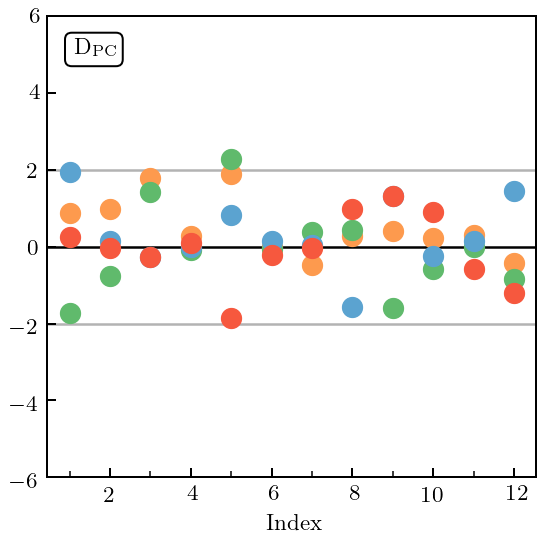

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.9998476951563913
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 0.75845437 -1.47880732  1.68544742  0.22570818]
 [ 1.27474822 -0.90957987  2.14877545 -0.32908094]
 [ 2.12130606  1.26318359  1.35748092 -1.29251646]
 [ 2.29109547  1.83471054  0.60269178 -1.11241569]
 [ 1.93912283  1.55094671 -0.11178491 -0.42520834]
 [ 1.56423656  1.19970867 -0.18517946 -0.23157546]
 [ 0.94606817  0.53677754 -0.14762627 -0.03631811]
 [ 0.78731608  0.28304681 -0.09786491  0.0067304 ]
 [ 0.66395882 -0.08641655  0.00412362  0.03572303]
 [ 0.65829916 -0.22338863  0.04620837  0.0308526 ]
 [ 0.75286396 -0.50211412  0.11513674 -0.00231888]
 [ 0.84868045 -0.65427987  0.12777944 -0.02527476]]
RBF(length_scale=0.271) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


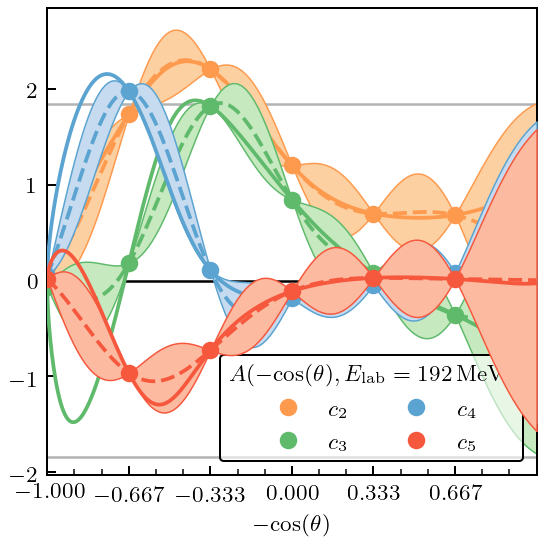

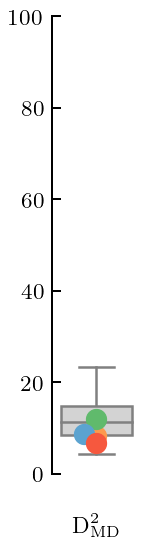

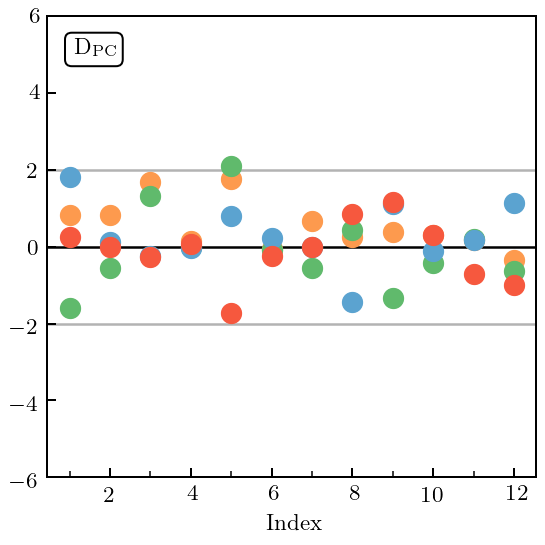

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.9998476951563913
test last: 0.9998476951563913 0.8887535068056811
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 0.75845437 -1.47880732  1.68544742  0.22570818]
 [ 1.27474822 -0.90957987  2.14877545 -0.32908094]
 [ 2.12130606  1.26318359  1.35748092 -1.29251646]
 [ 2.29109547  1.83471054  0.60269178 -1.11241569]
 [ 1.93912283  1.55094671 -0.11178491 -0.42520834]
 [ 1.56423656  1.19970867 -0.18517946 -0.23157546]
 [ 0.94606817  0.53677754 -0.14762627 -0.03631811]
 [ 0.78731608  0.28304681 -0.09786491  0.0067304 ]
 [ 0.66395882 -0.08641655  0.00412362  0.03572303]
 [ 0.65829916 -0.22338863  0.04620837  0.0308526 ]
 [ 0.75286396 -0.50211412  0.11513674 -0.00231888]
 [ 0.84868045 -0.65427987  0.12777944 -0.02527476]]
RBF(length_scale=0.351) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


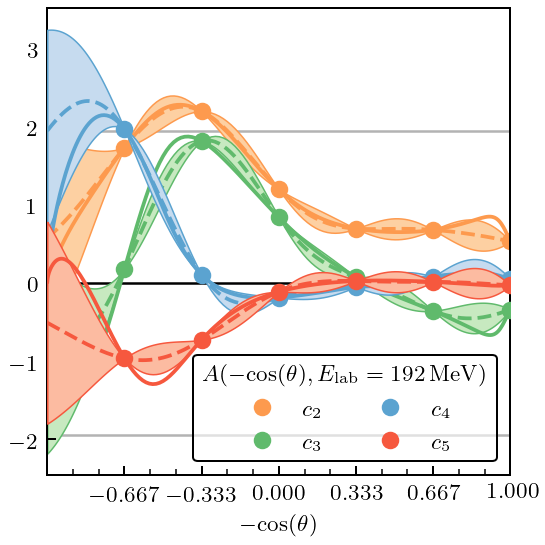

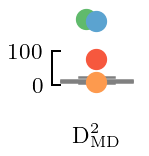

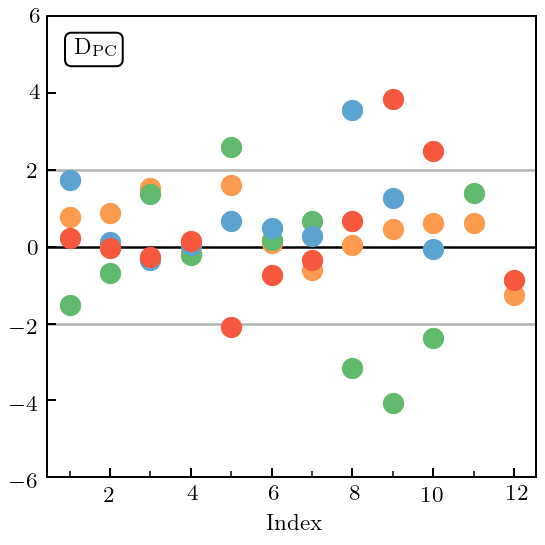

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 5.238075754853146 38.29285099201387
test last: 600.2240300237463 567.1692547865855
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[ 0.10884986 -0.49486658  0.39010342  0.14301329]
 [ 0.25812878 -0.94659139  0.77894251  0.25867621]
 [ 0.72559538 -1.48011925  1.63650987  0.24548989]
 [ 1.00056485 -1.32817008  1.98216925  0.01293101]
 [ 1.65076516 -0.05465013  2.05873885 -0.84786186]
 [ 1.99879419  0.9014861   1.62540639 -1.22919085]
 [ 2.26652905  1.87840539  0.25200157 -0.86673903]
 [ 2.00651446  1.61718475 -0.08223301 -0.47690187]
 [ 1.07536661  0.70085113 -0.17048673 -0.07228305]
 [ 0.79411997  0.29610002 -0.10085131  0.00490091]
 [ 0.66183558 -0.25599458  0.0558603   0.02816627]
 [ 0.7592444  -0.51347718  0.11704358 -0.00393287]]
RBF(length_scale=102) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


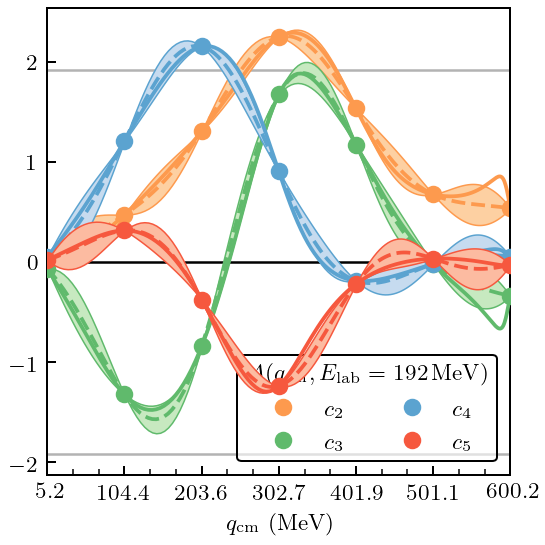

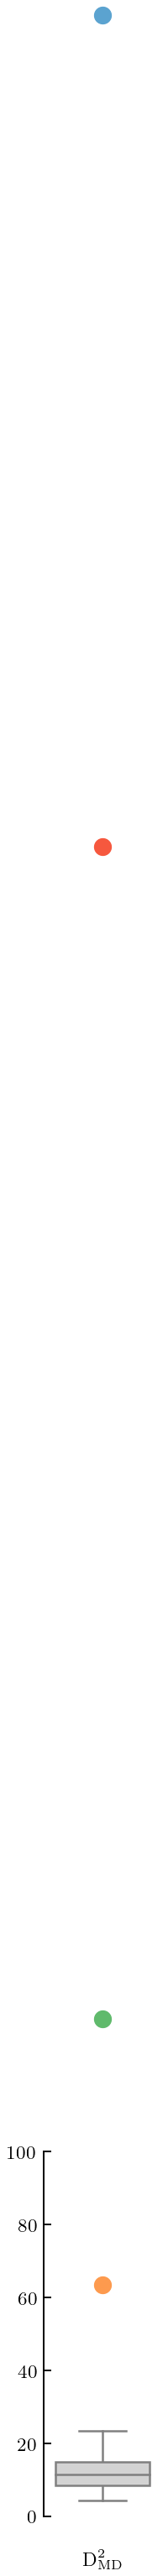

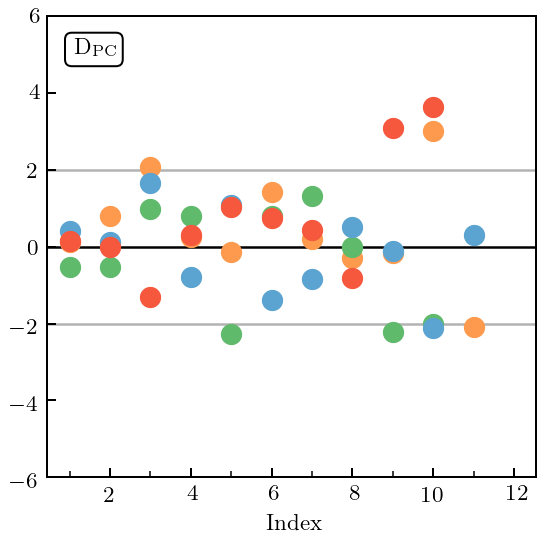

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 5.238075754853146 38.29285099201387
test last: 600.2240300237463 600.2240300237463
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 0.10884986 -0.49486658  0.39010342  0.14301329]
 [ 0.25812878 -0.94659139  0.77894251  0.25867621]
 [ 0.72559538 -1.48011925  1.63650987  0.24548989]
 [ 1.00056485 -1.32817008  1.98216925  0.01293101]
 [ 1.65076516 -0.05465013  2.05873885 -0.84786186]
 [ 1.99879419  0.9014861   1.62540639 -1.22919085]
 [ 2.26652905  1.87840539  0.25200157 -0.86673903]
 [ 2.00651446  1.61718475 -0.08223301 -0.47690187]
 [ 1.07536661  0.70085113 -0.17048673 -0.07228305]
 [ 0.79411997  0.29610002 -0.10085131  0.00490091]
 [ 0.66183558 -0.25599458  0.0558603   0.02816627]
 [ 0.7592444  -0.51347718  0.11704358 -0.00393287]]
RBF(length_scale=102) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


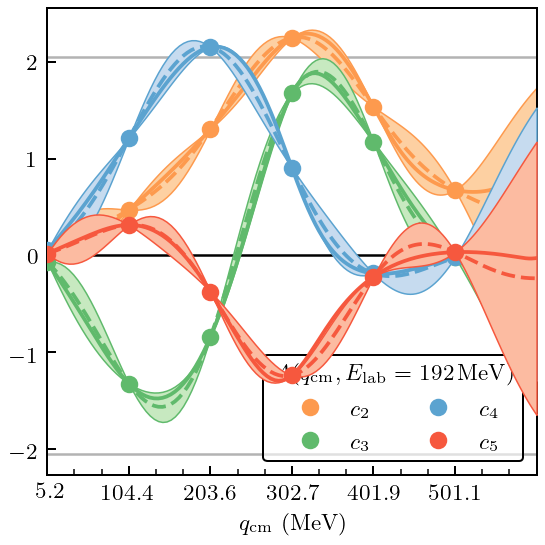

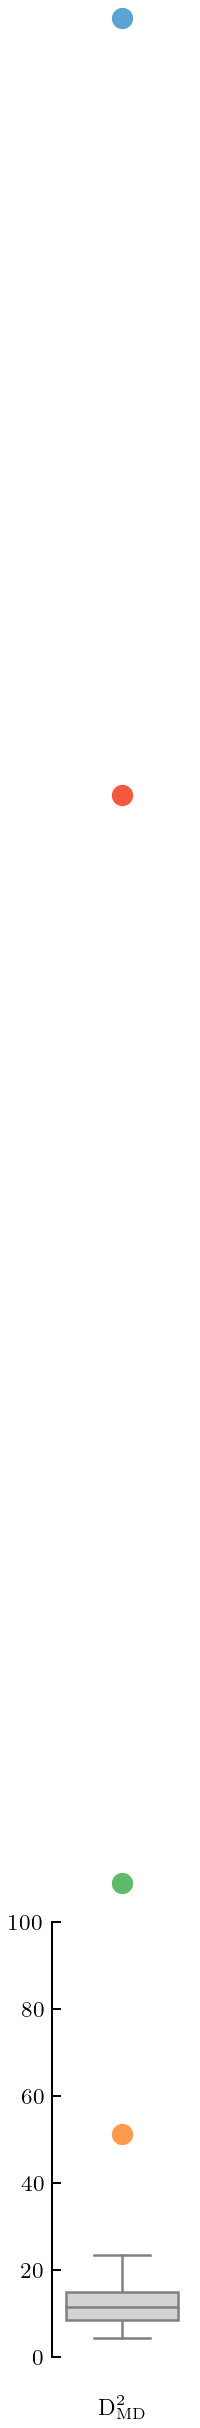

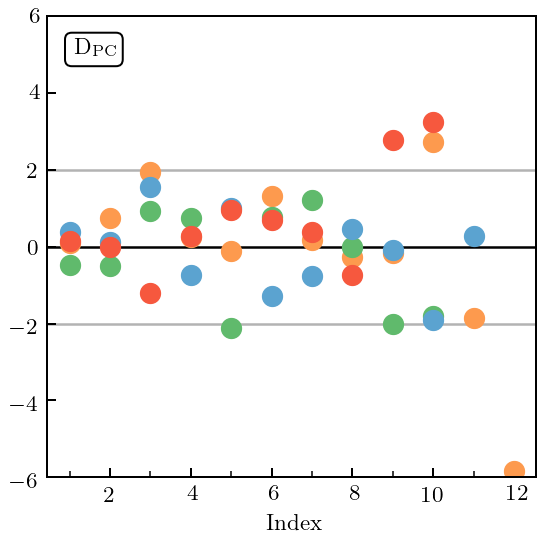

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 5.238075754853146 5.238075754853146
test last: 600.2240300237463 567.1692547865855
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 0.10884986 -0.49486658  0.39010342  0.14301329]
 [ 0.25812878 -0.94659139  0.77894251  0.25867621]
 [ 0.72559538 -1.48011925  1.63650987  0.24548989]
 [ 1.00056485 -1.32817008  1.98216925  0.01293101]
 [ 1.65076516 -0.05465013  2.05873885 -0.84786186]
 [ 1.99879419  0.9014861   1.62540639 -1.22919085]
 [ 2.26652905  1.87840539  0.25200157 -0.86673903]
 [ 2.00651446  1.61718475 -0.08223301 -0.47690187]
 [ 1.07536661  0.70085113 -0.17048673 -0.07228305]
 [ 0.79411997  0.29610002 -0.10085131  0.00490091]
 [ 0.66183558 -0.25599458  0.0558603   0.02816627]
 [ 0.7592444  -0.51347718  0.11704358 -0.00393287]]
RBF(length_scale=100) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


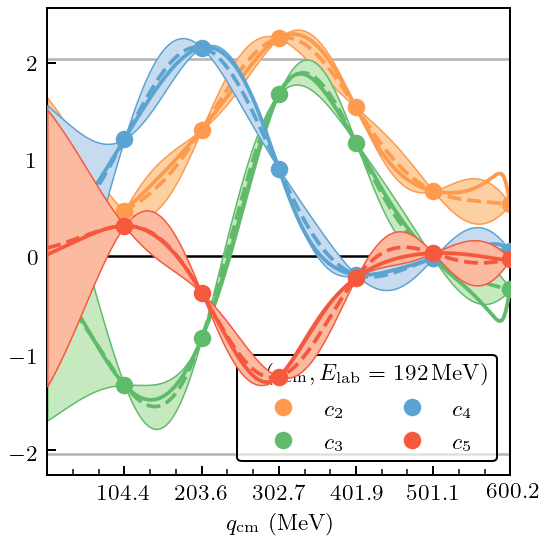

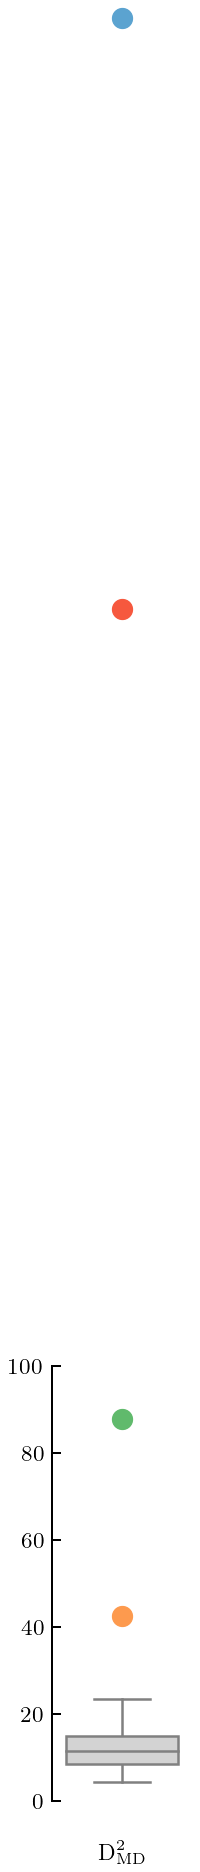

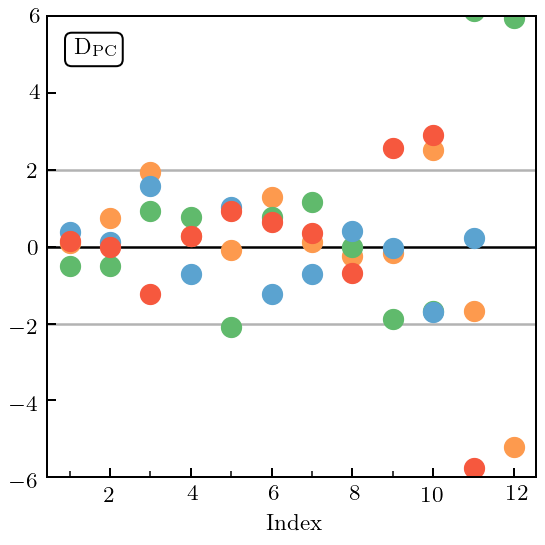

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 27.43743761358035 20040.851258743223
test last: 360268.8862179471 340255.47239681747
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[ 0.75845437 -1.47880732  1.68544742  0.22570818]
 [ 1.27474822 -0.90957987  2.14877545 -0.32908094]
 [ 2.12130606  1.26318359  1.35748092 -1.29251646]
 [ 2.29109547  1.83471054  0.60269178 -1.11241569]
 [ 1.93912283  1.55094671 -0.11178491 -0.42520834]
 [ 1.56423656  1.19970867 -0.18517946 -0.23157546]
 [ 0.94606817  0.53677754 -0.14762627 -0.03631811]
 [ 0.78731608  0.28304681 -0.09786491  0.0067304 ]
 [ 0.66395882 -0.08641655  0.00412362  0.03572303]
 [ 0.65829916 -0.22338863  0.04620837  0.0308526 ]
 [ 0.75286396 -0.50211412  0.11513674 -0.00231888]
 [ 0.84868045 -0.65427987  0.12777944 -0.02527476]]
RBF(length_scale=4.98e+04) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


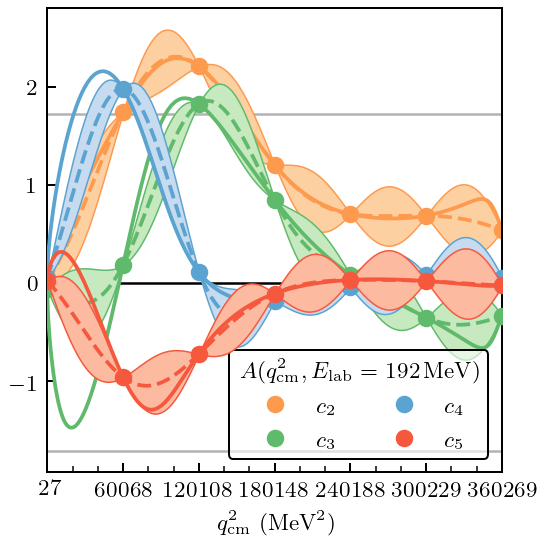

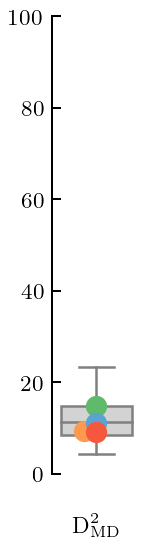

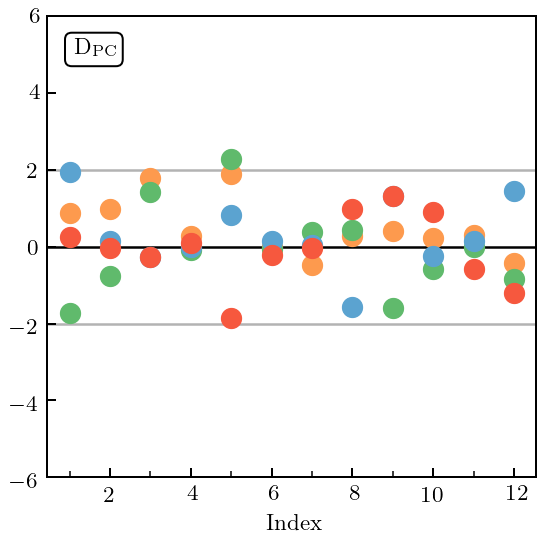

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 27.43743761358035 20040.851258743223
test last: 360268.8862179471 360268.8862179471
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 0.75845437 -1.47880732  1.68544742  0.22570818]
 [ 1.27474822 -0.90957987  2.14877545 -0.32908094]
 [ 2.12130606  1.26318359  1.35748092 -1.29251646]
 [ 2.29109547  1.83471054  0.60269178 -1.11241569]
 [ 1.93912283  1.55094671 -0.11178491 -0.42520834]
 [ 1.56423656  1.19970867 -0.18517946 -0.23157546]
 [ 0.94606817  0.53677754 -0.14762627 -0.03631811]
 [ 0.78731608  0.28304681 -0.09786491  0.0067304 ]
 [ 0.66395882 -0.08641655  0.00412362  0.03572303]
 [ 0.65829916 -0.22338863  0.04620837  0.0308526 ]
 [ 0.75286396 -0.50211412  0.11513674 -0.00231888]
 [ 0.84868045 -0.65427987  0.12777944 -0.02527476]]
RBF(length_scale=4.88e+04) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


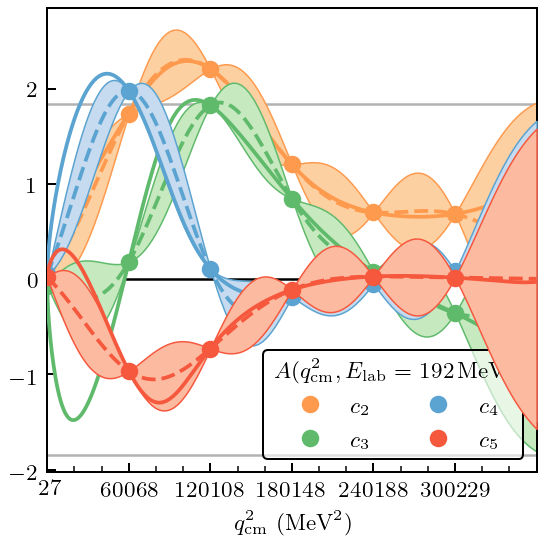

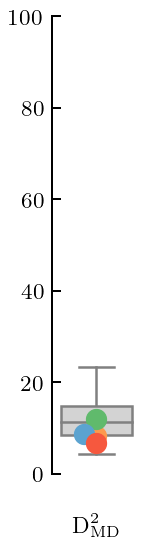

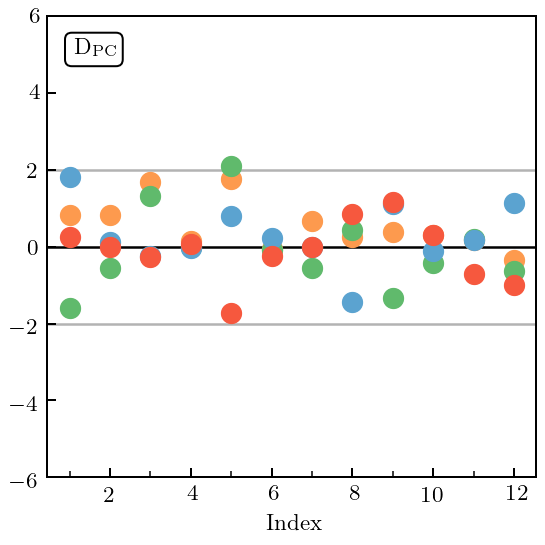

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 27.43743761358035 27.43743761358035
test last: 360268.8862179471 340255.47239681747
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 0.75845437 -1.47880732  1.68544742  0.22570818]
 [ 1.27474822 -0.90957987  2.14877545 -0.32908094]
 [ 2.12130606  1.26318359  1.35748092 -1.29251646]
 [ 2.29109547  1.83471054  0.60269178 -1.11241569]
 [ 1.93912283  1.55094671 -0.11178491 -0.42520834]
 [ 1.56423656  1.19970867 -0.18517946 -0.23157546]
 [ 0.94606817  0.53677754 -0.14762627 -0.03631811]
 [ 0.78731608  0.28304681 -0.09786491  0.0067304 ]
 [ 0.66395882 -0.08641655  0.00412362  0.03572303]
 [ 0.65829916 -0.22338863  0.04620837  0.0308526 ]
 [ 0.75286396 -0.50211412  0.11513674 -0.00231888]
 [ 0.84868045 -0.65427987  0.12777944 -0.02527476]]
RBF(length_scale=6.33e+04) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


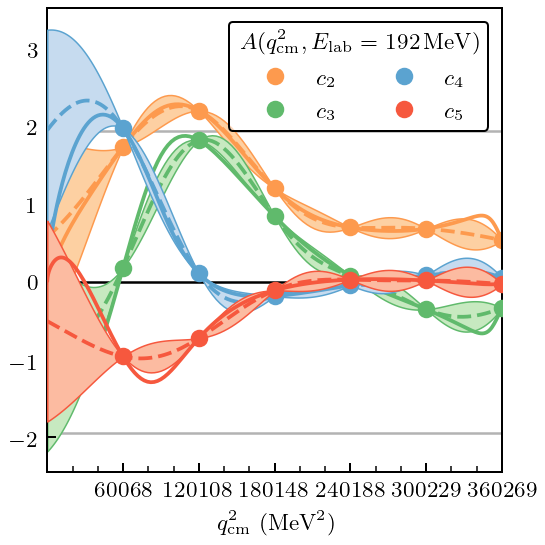

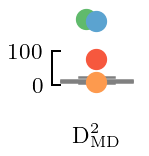

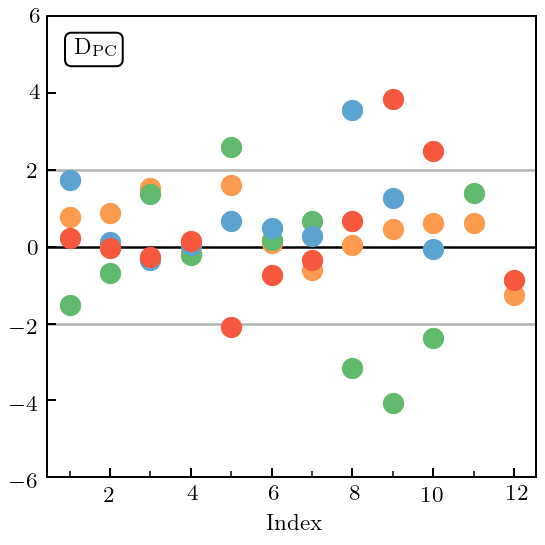

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 169.11111111111111
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[ 0.38221162 -0.95827952  0.57501972  0.5804759 ]
 [ 0.91841103 -1.71267749  1.23738241  1.00022492]
 [ 1.82200065 -0.88108355  1.62549589  0.30642706]
 [ 2.27244594  0.05612048  0.92450943 -0.10855101]
 [ 3.26842973  0.35925325  0.09756822  0.03083318]
 [ 3.22981288  0.12894573  0.09554651  0.06043934]
 [ 1.47097218 -0.02926147 -0.09330863 -0.00836603]
 [ 1.18389909 -0.14921843 -0.148297    0.12486259]
 [ 1.18665916 -0.84981417  0.44140765  0.11057339]
 [ 1.41617165 -1.50326962  0.96870521 -0.21002529]
 [ 2.32135701 -3.37811459  1.79007974 -1.18370175]
 [ 2.11659792 -2.62519104  1.33793802 -1.25837542]]
RBF(length_scale=24.1) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


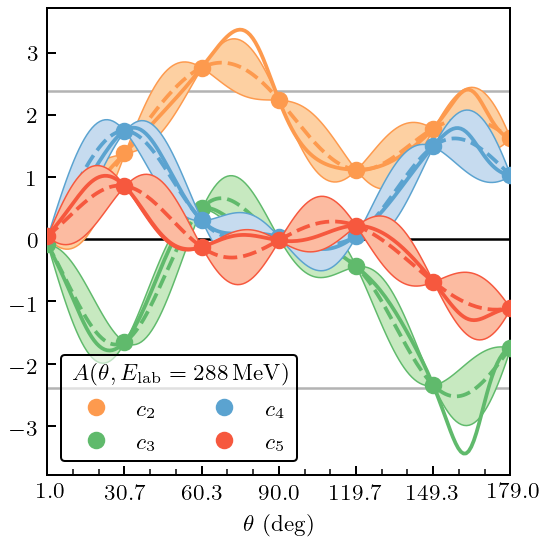

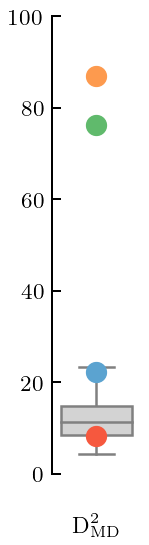

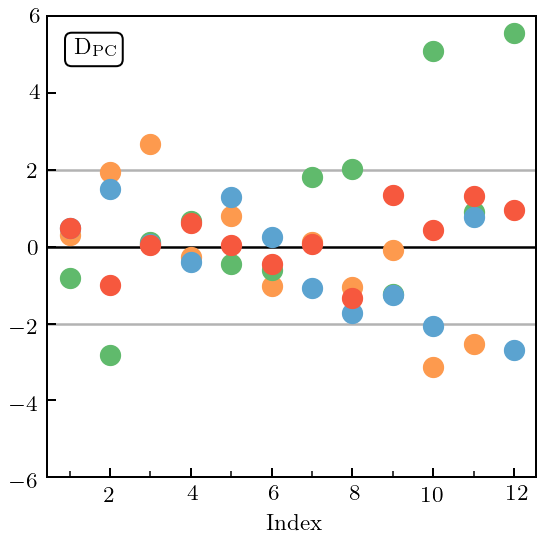

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 179.0
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 0.38221162 -0.95827952  0.57501972  0.5804759 ]
 [ 0.91841103 -1.71267749  1.23738241  1.00022492]
 [ 1.82200065 -0.88108355  1.62549589  0.30642706]
 [ 2.27244594  0.05612048  0.92450943 -0.10855101]
 [ 3.26842973  0.35925325  0.09756822  0.03083318]
 [ 3.22981288  0.12894573  0.09554651  0.06043934]
 [ 1.47097218 -0.02926147 -0.09330863 -0.00836603]
 [ 1.18389909 -0.14921843 -0.148297    0.12486259]
 [ 1.18665916 -0.84981417  0.44140765  0.11057339]
 [ 1.41617165 -1.50326962  0.96870521 -0.21002529]
 [ 2.32135701 -3.37811459  1.79007974 -1.18370175]
 [ 2.11659792 -2.62519104  1.33793802 -1.25837542]]
RBF(length_scale=22) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


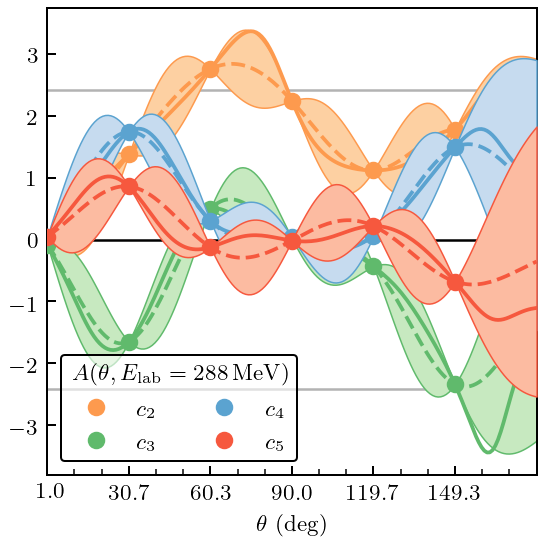

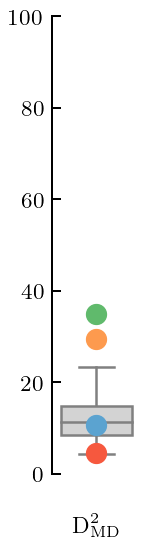

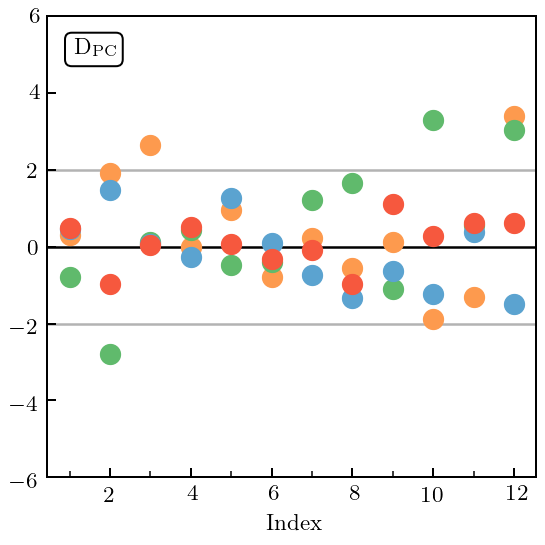

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 1.0
test last: 179 169.11111111111111
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 0.38221162 -0.95827952  0.57501972  0.5804759 ]
 [ 0.91841103 -1.71267749  1.23738241  1.00022492]
 [ 1.82200065 -0.88108355  1.62549589  0.30642706]
 [ 2.27244594  0.05612048  0.92450943 -0.10855101]
 [ 3.26842973  0.35925325  0.09756822  0.03083318]
 [ 3.22981288  0.12894573  0.09554651  0.06043934]
 [ 1.47097218 -0.02926147 -0.09330863 -0.00836603]
 [ 1.18389909 -0.14921843 -0.148297    0.12486259]
 [ 1.18665916 -0.84981417  0.44140765  0.11057339]
 [ 1.41617165 -1.50326962  0.96870521 -0.21002529]
 [ 2.32135701 -3.37811459  1.79007974 -1.18370175]
 [ 2.11659792 -2.62519104  1.33793802 -1.25837542]]
RBF(length_scale=27.4) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


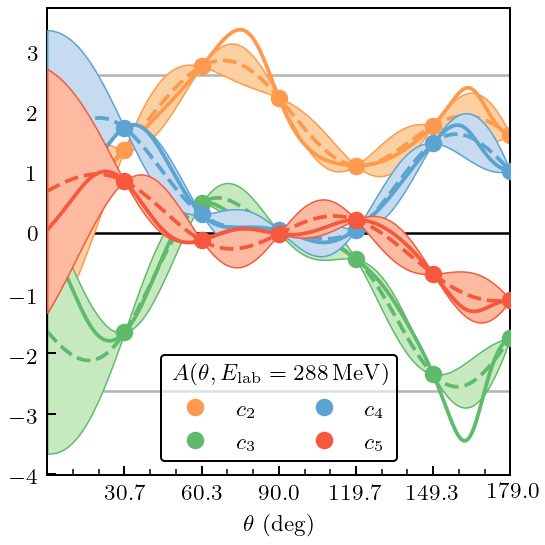

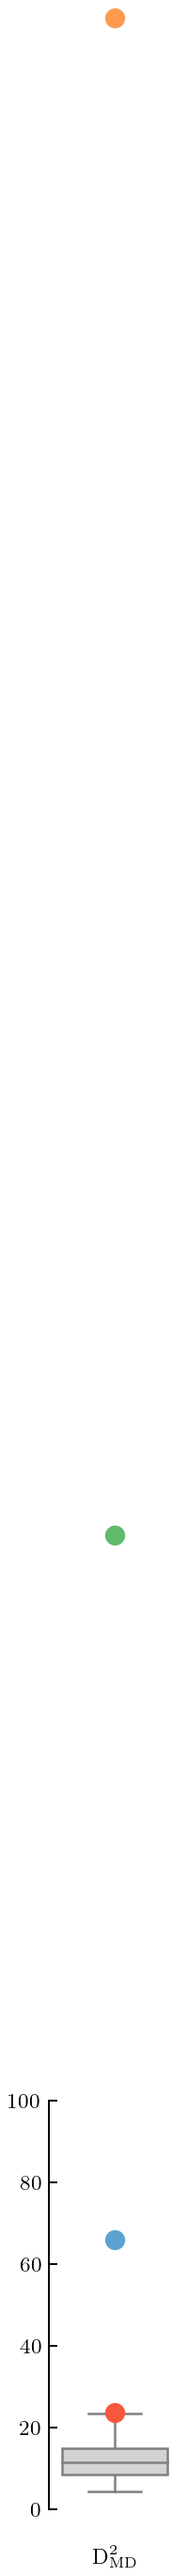

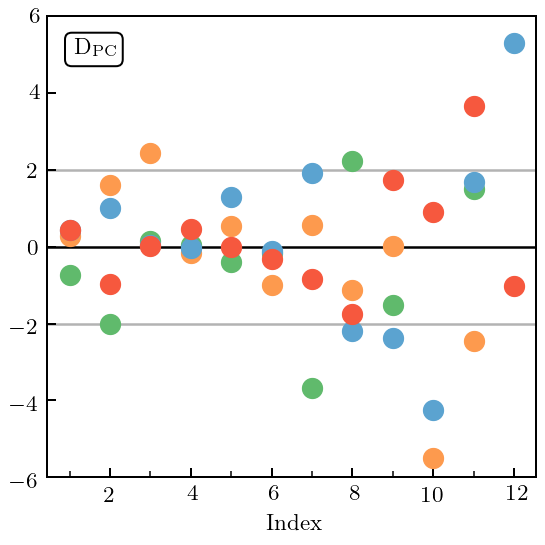

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.8887535068056811
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[ 1.23313584e+00 -1.76628586e+00  1.61777688e+00  9.74156269e-01]
 [ 1.74931363e+00 -1.03796398e+00  1.69870859e+00  4.01947899e-01]
 [ 2.46970587e+00  3.78553927e-01  4.85690988e-01 -1.45586064e-01]
 [ 2.56194656e+00  4.04273602e-01  1.45601777e-01 -5.17724691e-02]
 [ 2.15127968e+00  9.43512698e-02  3.91158153e-02  2.32406848e-02]
 [ 1.65523211e+00  3.35499653e-02  2.76041838e-02  8.23066740e-03]
 [ 7.53868595e-01 -4.56101750e-03 -8.40550541e-03 -3.78087736e-03]
 [ 5.50547671e-01 -1.23078198e-02 -2.18391207e-02  2.34003771e-03]
 [ 3.89667695e-01 -6.70364197e-02 -4.31665777e-03  1.45294289e-02]
 [ 3.62492784e-01 -1.06057004e-01  2.01910934e-02  1.17887889e-02]
 [ 4.11799890e-01 -2.42040969e-01  8.34887938e-02 -1.16393617e-02]
 [ 

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


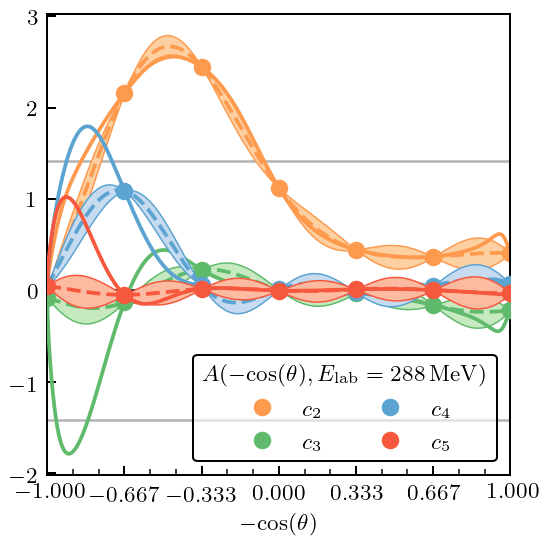

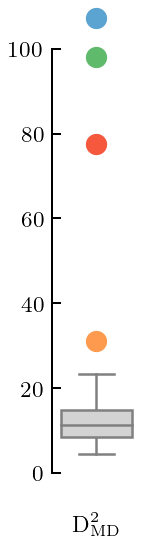

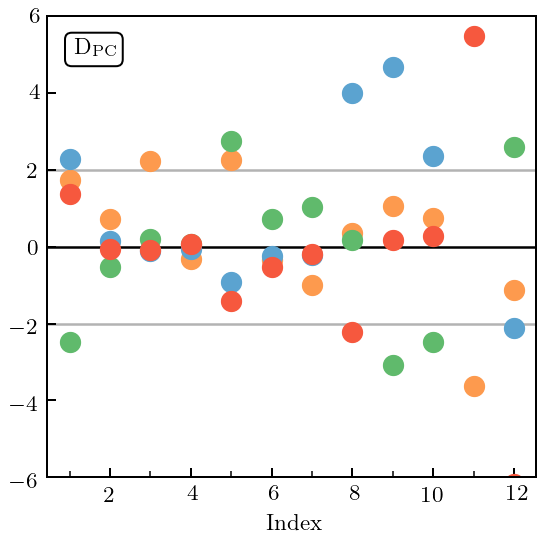

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.9998476951563913
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 1.23313584e+00 -1.76628586e+00  1.61777688e+00  9.74156269e-01]
 [ 1.74931363e+00 -1.03796398e+00  1.69870859e+00  4.01947899e-01]
 [ 2.46970587e+00  3.78553927e-01  4.85690988e-01 -1.45586064e-01]
 [ 2.56194656e+00  4.04273602e-01  1.45601777e-01 -5.17724691e-02]
 [ 2.15127968e+00  9.43512698e-02  3.91158153e-02  2.32406848e-02]
 [ 1.65523211e+00  3.35499653e-02  2.76041838e-02  8.23066740e-03]
 [ 7.53868595e-01 -4.56101750e-03 -8.40550541e-03 -3.78087736e-03]
 [ 5.50547671e-01 -1.23078198e-02 -2.18391207e-02  2.34003771e-03]
 [ 3.89667695e-01 -6.70364197e-02 -4.31665777e-03  1.45294289e-02]
 [ 3.62492784e-01 -1.06057004e-01  2.01910934e-02  1.17887889e-02]
 [ 4.11799890e-01 -2.42040969e-01  8.3488793

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


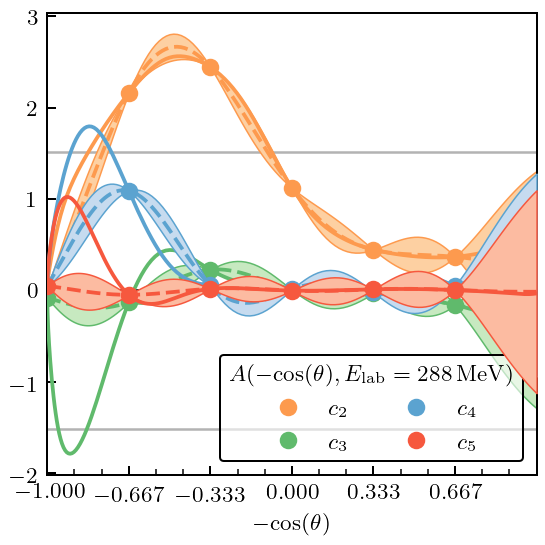

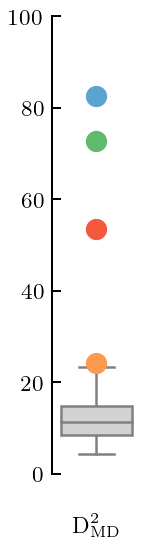

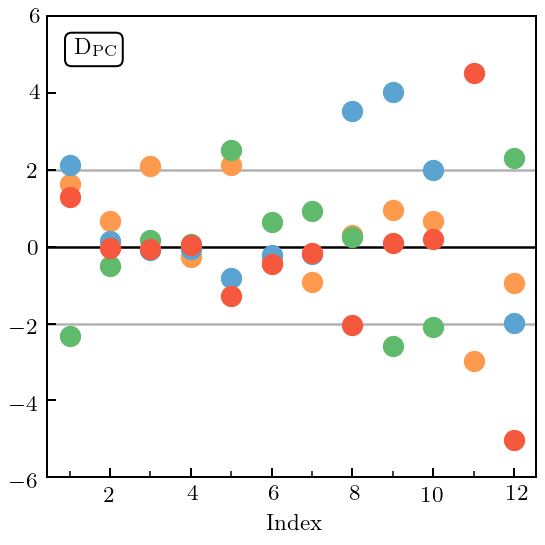

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.9998476951563913
test last: 0.9998476951563913 0.8887535068056811
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 1.23313584e+00 -1.76628586e+00  1.61777688e+00  9.74156269e-01]
 [ 1.74931363e+00 -1.03796398e+00  1.69870859e+00  4.01947899e-01]
 [ 2.46970587e+00  3.78553927e-01  4.85690988e-01 -1.45586064e-01]
 [ 2.56194656e+00  4.04273602e-01  1.45601777e-01 -5.17724691e-02]
 [ 2.15127968e+00  9.43512698e-02  3.91158153e-02  2.32406848e-02]
 [ 1.65523211e+00  3.35499653e-02  2.76041838e-02  8.23066740e-03]
 [ 7.53868595e-01 -4.56101750e-03 -8.40550541e-03 -3.78087736e-03]
 [ 5.50547671e-01 -1.23078198e-02 -2.18391207e-02  2.34003771e-03]
 [ 3.89667695e-01 -6.70364197e-02 -4.31665777e-03  1.45294289e-02]
 [ 3.62492784e-01 -1.06057004e-01  2.01910934e-02  1.17887889e-02]
 [ 4.11799890e-01 -2.42040969e-01  8.3488793

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


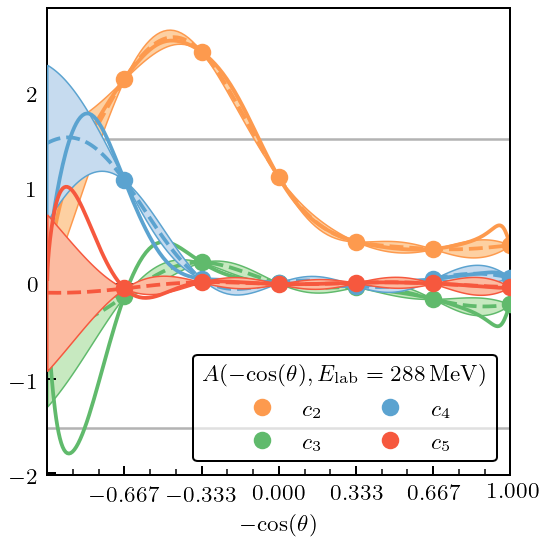

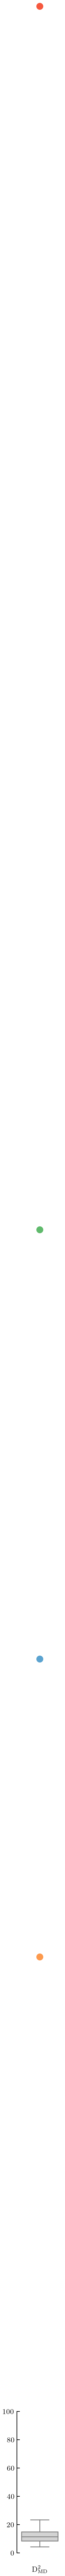

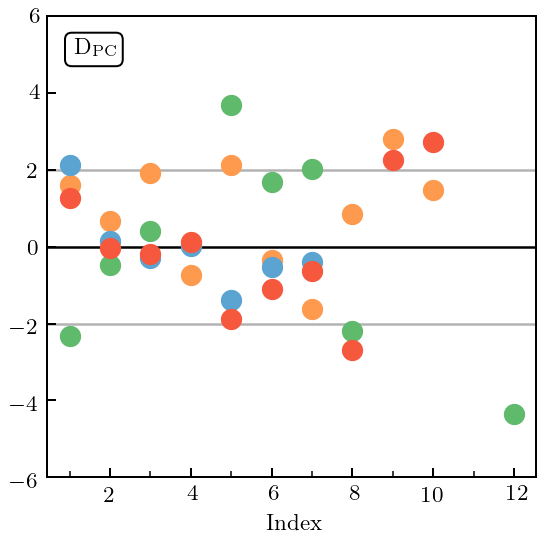

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 6.415306477871135 46.89897331049732
test last: 735.1213094651424 694.6376426325163
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[ 2.28469274e-01 -6.17474175e-01  3.65412261e-01  3.78476837e-01]
 [ 5.23867638e-01 -1.22209277e+00  7.53123560e-01  7.33187364e-01]
 [ 1.19669443e+00 -1.77990367e+00  1.57830909e+00  9.91989150e-01]
 [ 1.48512436e+00 -1.52304385e+00  1.79037689e+00  7.49001025e-01]
 [ 2.08357521e+00 -2.91287821e-01  1.22834062e+00  1.17840853e-02]
 [ 2.37343078e+00  2.51181437e-01  6.84890237e-01 -1.44905230e-01]
 [ 2.50625400e+00  2.92833270e-01  7.04225435e-02  2.60034981e-04]
 [ 2.22826685e+00  1.14282868e-01  4.08818736e-02  2.48784207e-02]
 [ 9.31725931e-01  2.84721300e-04  1.66404297e-03 -4.46228310e-03]
 [ 5.58966364e-01 -1.16543997e-02 -2.13702777e-02  1.88748823e-03]
 [ 3.60153775e-01 -1.17516525e-01  2.70671949e-02  1.00323002e-02]
 [ 4.1661

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


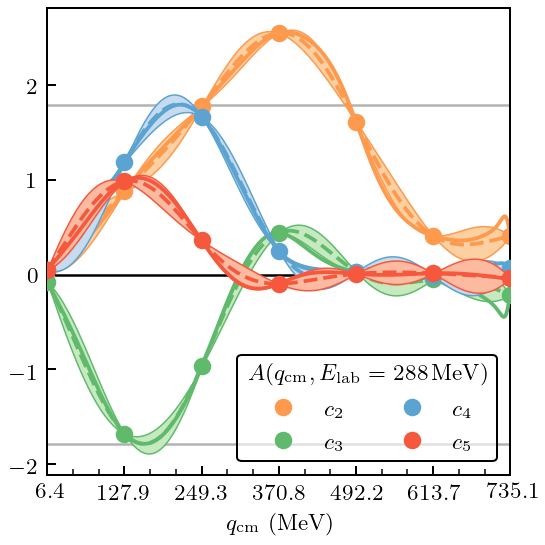

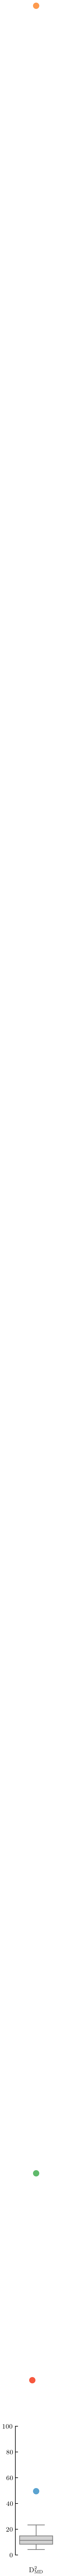

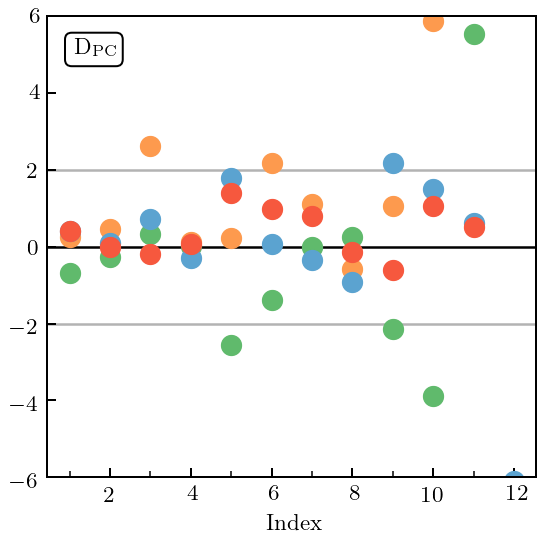

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 6.415306477871135 46.89897331049732
test last: 735.1213094651424 735.1213094651424
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 2.28469274e-01 -6.17474175e-01  3.65412261e-01  3.78476837e-01]
 [ 5.23867638e-01 -1.22209277e+00  7.53123560e-01  7.33187364e-01]
 [ 1.19669443e+00 -1.77990367e+00  1.57830909e+00  9.91989150e-01]
 [ 1.48512436e+00 -1.52304385e+00  1.79037689e+00  7.49001025e-01]
 [ 2.08357521e+00 -2.91287821e-01  1.22834062e+00  1.17840853e-02]
 [ 2.37343078e+00  2.51181437e-01  6.84890237e-01 -1.44905230e-01]
 [ 2.50625400e+00  2.92833270e-01  7.04225435e-02  2.60034981e-04]
 [ 2.22826685e+00  1.14282868e-01  4.08818736e-02  2.48784207e-02]
 [ 9.31725931e-01  2.84721300e-04  1.66404297e-03 -4.46228310e-03]
 [ 5.58966364e-01 -1.16543997e-02 -2.13702777e-02  1.88748823e-03]
 [ 3.60153775e-01 -1.17516525e-01  2.70671949e-02 

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


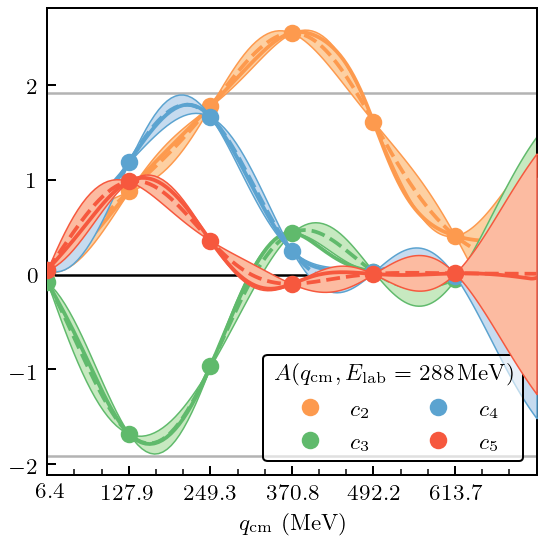

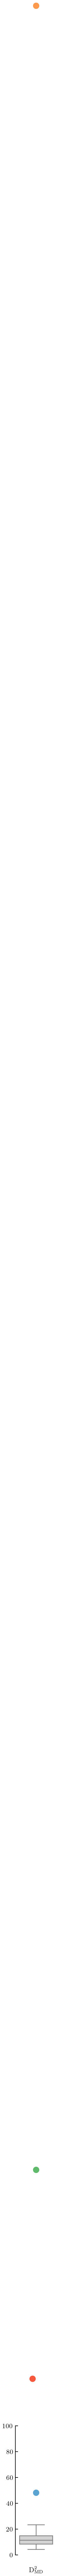

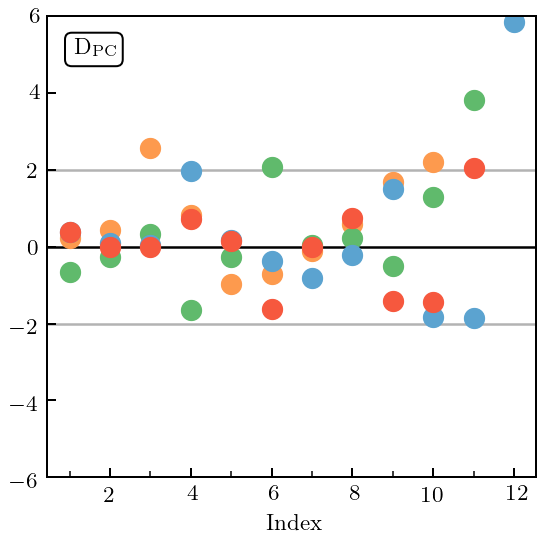

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 6.415306477871135 6.415306477871135
test last: 735.1213094651424 694.6376426325163
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 2.28469274e-01 -6.17474175e-01  3.65412261e-01  3.78476837e-01]
 [ 5.23867638e-01 -1.22209277e+00  7.53123560e-01  7.33187364e-01]
 [ 1.19669443e+00 -1.77990367e+00  1.57830909e+00  9.91989150e-01]
 [ 1.48512436e+00 -1.52304385e+00  1.79037689e+00  7.49001025e-01]
 [ 2.08357521e+00 -2.91287821e-01  1.22834062e+00  1.17840853e-02]
 [ 2.37343078e+00  2.51181437e-01  6.84890237e-01 -1.44905230e-01]
 [ 2.50625400e+00  2.92833270e-01  7.04225435e-02  2.60034981e-04]
 [ 2.22826685e+00  1.14282868e-01  4.08818736e-02  2.48784207e-02]
 [ 9.31725931e-01  2.84721300e-04  1.66404297e-03 -4.46228310e-03]
 [ 5.58966364e-01 -1.16543997e-02 -2.13702777e-02  1.88748823e-03]
 [ 3.60153775e-01 -1.17516525e-01  2.70671949e-02 

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


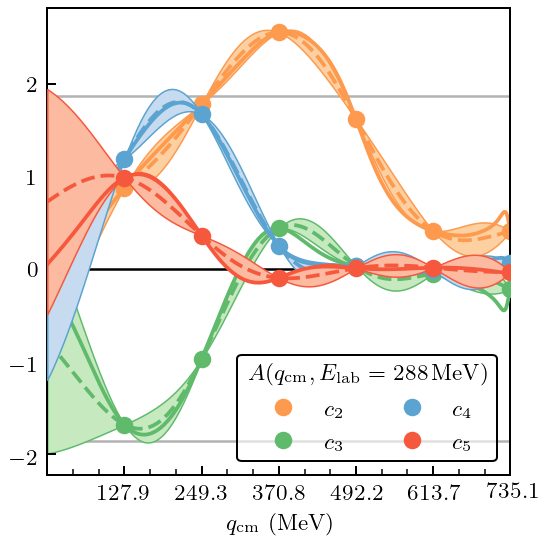

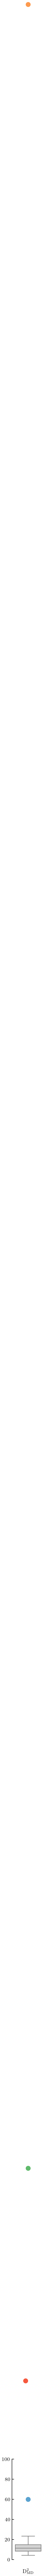

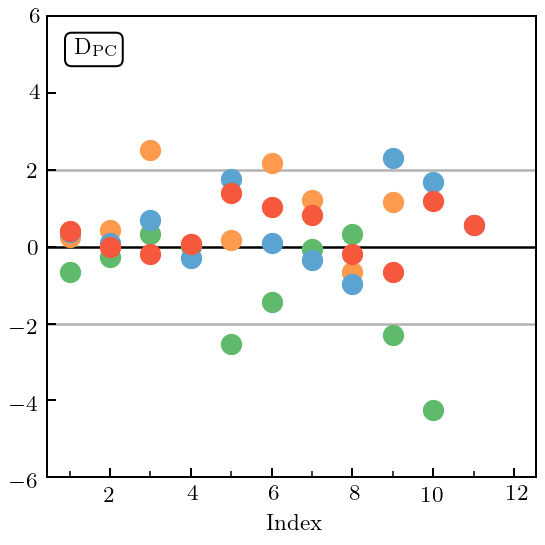

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 41.15615720501535 30061.277461235055
test last: 540403.3396297457 510383.2183257157
dsg_vs_theta has shape (179, 5)
X_train has shape (7,)
y_train has shape (7, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(7, 5)
(7,)
(7,)
coeffs_test = [[ 1.23313584e+00 -1.76628586e+00  1.61777688e+00  9.74156269e-01]
 [ 1.74931363e+00 -1.03796398e+00  1.69870859e+00  4.01947899e-01]
 [ 2.46970587e+00  3.78553927e-01  4.85690988e-01 -1.45586064e-01]
 [ 2.56194656e+00  4.04273602e-01  1.45601777e-01 -5.17724691e-02]
 [ 2.15127968e+00  9.43512698e-02  3.91158153e-02  2.32406848e-02]
 [ 1.65523211e+00  3.35499653e-02  2.76041838e-02  8.23066740e-03]
 [ 7.53868595e-01 -4.56101750e-03 -8.40550541e-03 -3.78087736e-03]
 [ 5.50547671e-01 -1.23078198e-02 -2.18391207e-02  2.34003771e-03]
 [ 3.89667695e-01 -6.70364197e-02 -4.31665777e-03  1.45294289e-02]
 [ 3.62492784e-01 -1.06057004e-01  2.01910934e-02  1.17887889e-02]
 [ 4.11799890e-01 -2.42040969e-01  8.34887938e-02 -1.16393617e-02]
 [ 5.167

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


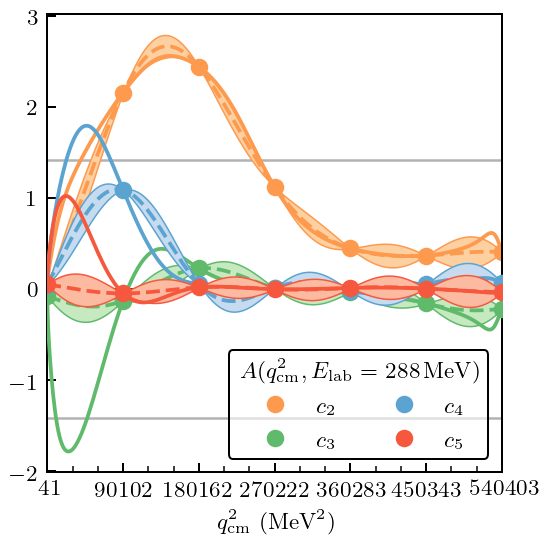

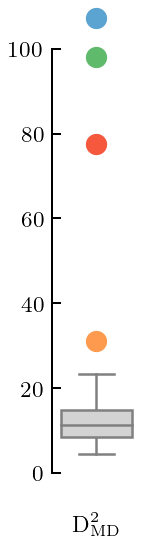

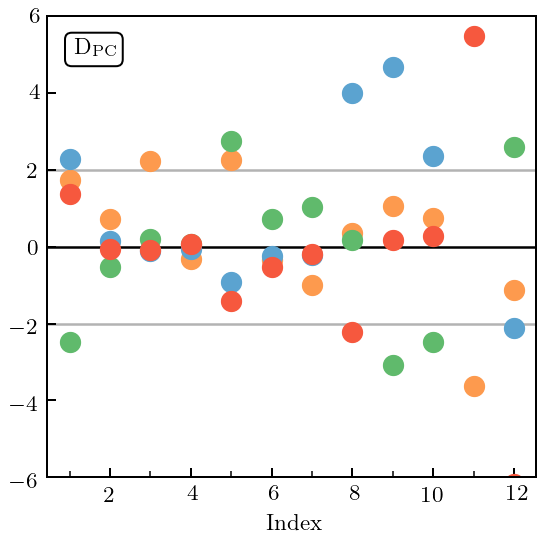

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 41.15615720501535 30061.277461235055
test last: 540403.3396297457 540403.3396297457
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 1.23313584e+00 -1.76628586e+00  1.61777688e+00  9.74156269e-01]
 [ 1.74931363e+00 -1.03796398e+00  1.69870859e+00  4.01947899e-01]
 [ 2.46970587e+00  3.78553927e-01  4.85690988e-01 -1.45586064e-01]
 [ 2.56194656e+00  4.04273602e-01  1.45601777e-01 -5.17724691e-02]
 [ 2.15127968e+00  9.43512698e-02  3.91158153e-02  2.32406848e-02]
 [ 1.65523211e+00  3.35499653e-02  2.76041838e-02  8.23066740e-03]
 [ 7.53868595e-01 -4.56101750e-03 -8.40550541e-03 -3.78087736e-03]
 [ 5.50547671e-01 -1.23078198e-02 -2.18391207e-02  2.34003771e-03]
 [ 3.89667695e-01 -6.70364197e-02 -4.31665777e-03  1.45294289e-02]
 [ 3.62492784e-01 -1.06057004e-01  2.01910934e-02  1.17887889e-02]
 [ 4.11799890e-01 -2.42040969e-01  8.34887938e-02

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


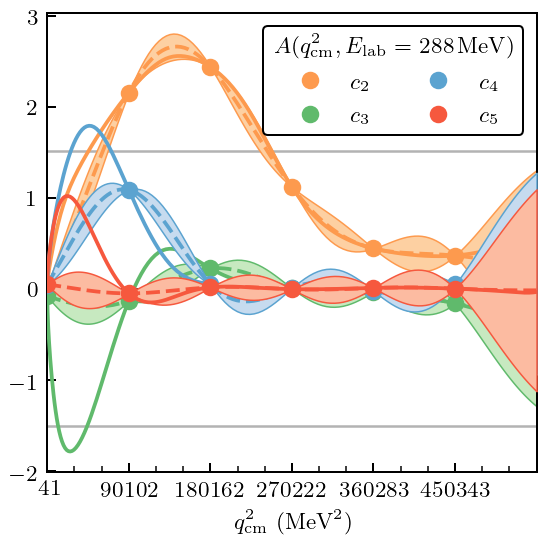

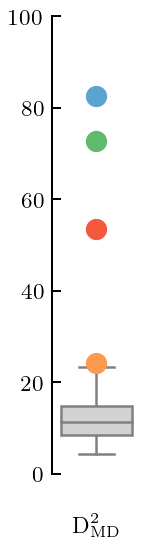

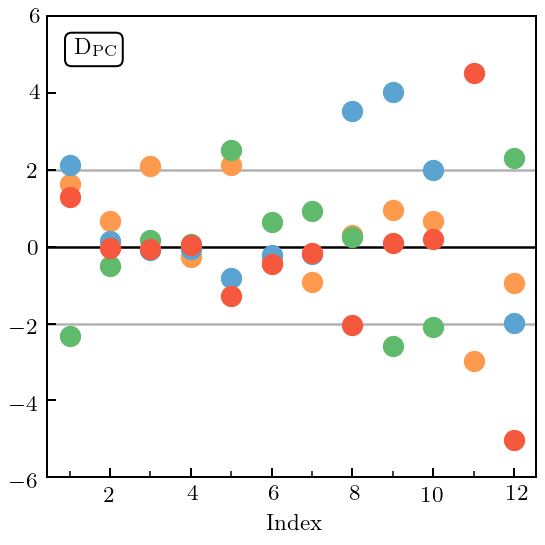

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 41.15615720501535 41.15615720501535
test last: 540403.3396297457 510383.2183257157
(5, 350, 13)
(5, 350, 12)
dsg_vs_theta has shape (179, 5)
X_train has shape (6,)
y_train has shape (6, 5)
X_test has shape (12,)
y_test has shape (12, 5)
(6, 5)
(6,)
(6,)
coeffs_test = [[ 1.23313584e+00 -1.76628586e+00  1.61777688e+00  9.74156269e-01]
 [ 1.74931363e+00 -1.03796398e+00  1.69870859e+00  4.01947899e-01]
 [ 2.46970587e+00  3.78553927e-01  4.85690988e-01 -1.45586064e-01]
 [ 2.56194656e+00  4.04273602e-01  1.45601777e-01 -5.17724691e-02]
 [ 2.15127968e+00  9.43512698e-02  3.91158153e-02  2.32406848e-02]
 [ 1.65523211e+00  3.35499653e-02  2.76041838e-02  8.23066740e-03]
 [ 7.53868595e-01 -4.56101750e-03 -8.40550541e-03 -3.78087736e-03]
 [ 5.50547671e-01 -1.23078198e-02 -2.18391207e-02  2.34003771e-03]
 [ 3.89667695e-01 -6.70364197e-02 -4.31665777e-03  1.45294289e-02]
 [ 3.62492784e-01 -1.06057004e-01  2.01910934e-02  1.17887889e-02]
 [ 4.11799890e-01 -2.42040969e-01  8.34887938e-02 

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:207: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


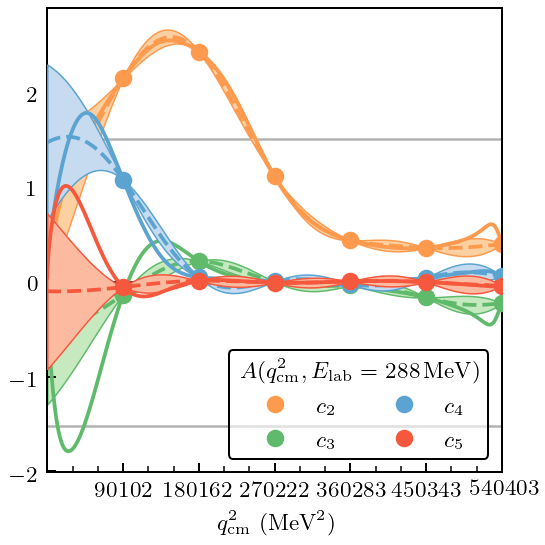

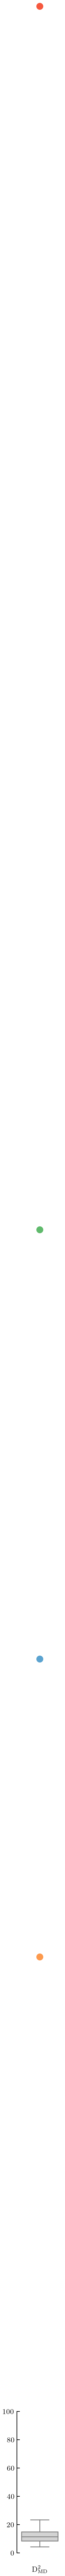

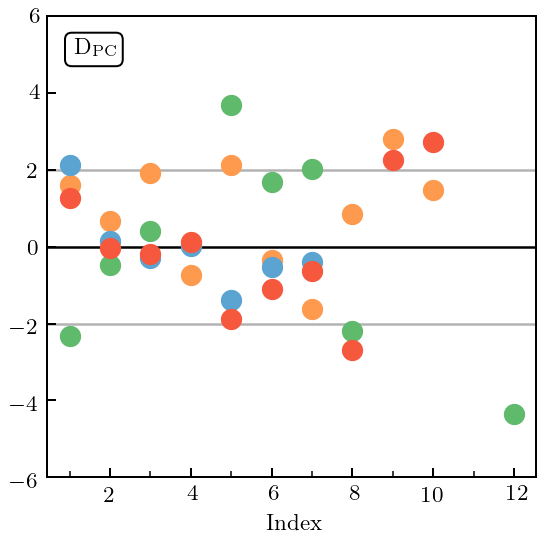

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/524394996.py:239: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


In [25]:
# runs through the observables
for m, observable in enumerate(vsangle_observable_array):
    # runs through the energies at which to evaluate the observables
    for j, E_lab in enumerate(observable.energies):
        # creates the bunches for the input spaces
        DegBunch = InputSpaceBunch("deg", \
                            degrees, \
                            E_to_p(E_lab, "np"), \
                            r'$\theta$ (deg)', \
                            [r'$', observable.title, r'(\theta, E_{\mathrm{lab}}= ', E_lab, \
                             '\,\mathrm{MeV})$'])
        
        # note that the input space here is -cos(theta), not cos(theta) (as it once was)
        CosBunch = InputSpaceBunch("cos", \
                            -np.cos(np.radians(degrees)), \
                            np.array( [softmax_mom(E_to_p(E_lab, "np"), q) \
                                      for q in deg_to_qcm(E_to_p(E_lab, "np"), degrees)] ), \
                            r'$-\mathrm{cos}(\theta)$', \
                            [r'$', observable.title, r'(-\mathrm{cos}(\theta), E_{\mathrm{lab}}= ', \
                             E_lab, '\,\mathrm{MeV})$'])

        QcmBunch = InputSpaceBunch("qcm", \
                            deg_to_qcm(E_to_p(E_lab, "np"), degrees), \
                            np.array( [softmax_mom(E_to_p(E_lab, "np"), q) \
                                      for q in deg_to_qcm(E_to_p(E_lab, "np"), degrees)] ), \
                            r'$q_{\mathrm{cm}}$ (MeV)', \
                            [r'$', observable.title, r'(q_{\mathrm{cm}}, E_{\mathrm{lab}}= ', \
                             E_lab, '\,\mathrm{MeV})$'])

        Qcm2Bunch = InputSpaceBunch("qcm2", \
                            deg_to_qcm2(E_to_p(E_lab, "np"), degrees), \
                            np.array( [softmax_mom(E_to_p(E_lab, "np"), q) \
                                      for q in deg_to_qcm(E_to_p(E_lab, "np"), degrees)] ), \
                            r'$q_{\mathrm{cm}}^{2}$ (MeV$^{2}$)', \
                            [r'$', observable.title, r'(q_{\mathrm{cm}}^{2}, E_{\mathrm{lab}}= ', \
                             E_lab, '\,\mathrm{MeV})$'])
    
        vsangle_quantity_array = [DegBunch, CosBunch, QcmBunch, Qcm2Bunch]
        # creates each bunch's title. This eventually will be outside of the for-loop
        for bunch in vsangle_quantity_array: bunch.make_title()

        # runs through the parametrization methods
        for k, Q_param_method in enumerate(Q_param_method_array):
            # runs through the input spaces
            for i, vs_quantity in enumerate(vsangle_quantity_array):
                # runs through the training and testing masks
                for l, traintestsplit in enumerate(traintestsplit_vsangle_array):
                    # conforms the training and testing masks to each input space
                    traintestsplit.make_masks(vs_quantity.input_space, observable.data)
    
                    # chooses a starting guess for the GP length scale optimization procedure
                    length_scale_guess = observable.ls_guesses[i, j]
                    
                    # creates the GP with all its hyperparameters
                    ratio_dsg = Q_approx(vs_quantity.mom, Q_param_method, Lambda_b = Lambdab)
                    center = 0
                    df = 1
                    disp = 0
                    scale = 1
                    GPHyper_DSG = GPHyperparameters(length_scale_guess, center, ratio_dsg, \
                                    df = df, disp = 0, scale = scale)

                    # information for naming the savefiles
                    FileName_DSG = FileNaming(potential_string, cutoff_string, \
                                              Q_param_method)

                    # information on the orders for each potential
                    Orders_DSG = OrderInfo(nn_orders, nn_orders_mask, colors, light_colors)

                    # creates the object used to generate and plot statistical diagnostics
                    MyDSG = VsAngleObj(observable, E_lab, Lambdab, t_lab, vs_quantity, \
                            traintestsplit, GPHyper_DSG, Orders_DSG, FileName_DSG)

                    # plots figures
                    MyDSG.PlotCoefficients()
                    MyDSG.PlotMD()
                    MyDSG.PlotPC()
                    if vs_quantity.name == "deg":
                        MyDSG.PlotPosteriorPDF(PosteriorBounds_deg)
                    elif vs_quantity.name == "cos":
                        MyDSG.PlotPosteriorPDF(PosteriorBounds_cos)

And then things follow as before: print out the kernel, define the mean and covariance, do the diagnostics, and plot Mahalanobis distance and Pivoted Cholesky errors.

### Angle-independent observables

In [26]:
# creates the training and testing masks for the total cross section
Energysplit = TrainTestSplit("energy", 3, 4, \
                            offset_train_min_factor = 100/350, xmin_train_factor = 100/350, \
                            offset_test_min_factor = 100/350, xmin_test_factor = 100/350, \
                            offset_train_max_factor = -50/350, offset_test_max_factor = -50/350)
traintestsplit_vsenergy_array = [Energysplit]

In [27]:
# creates the bunch for each observable to be plotted against energy
SGTBunch = ObservableBunch("SGT", SGT, None, [100, 200], '\sigma_{\mathrm{tot}}', \
                           "dimensionful")

vsenergy_observable_array = [SGTBunch]

test first: 1 125.64285714285714
test last: 350 350.0
(5, 8)
(5, 7)
X_train has shape (3,)
y_train has shape (3, 5)
X_test has shape (7,)
y_test has shape (7, 5)
ref has shape (350,)
ref_train = [74.24326915 42.62149134 34.10992805]and has shape (3,)
ref_test = [60.09313234 51.77867096 46.39540804 39.79484556 37.55746417 35.7037671
 32.69839195]and has shape (7,)
(3, 5)
(3,)
coeffs_test = [[-0.55839306  1.16384226 -0.44509039  0.49056899]
 [-0.26149984  1.22284079 -0.20194177  0.08468837]
 [-0.05131461  1.22015723  0.02600935 -0.18846277]
 [ 0.1819414   1.10797273  0.38677834 -0.47372228]
 [ 0.23815611  1.02524232  0.51907125 -0.53288009]
 [ 0.26977278  0.93642676  0.62354561 -0.55798509]
 [ 0.28736892  0.7602328   0.76334315 -0.54585448]]
RBF(length_scale=100) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


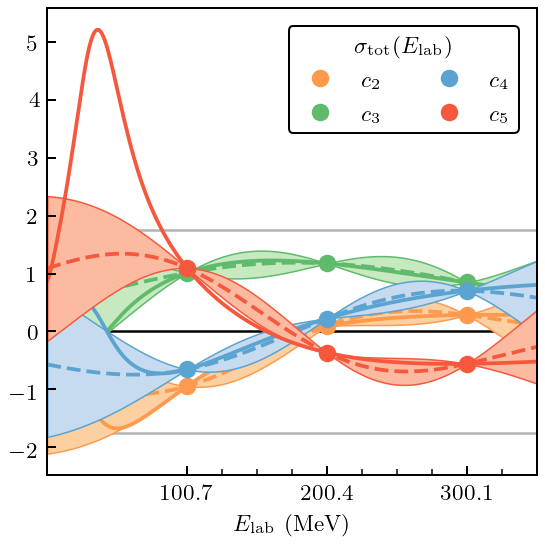

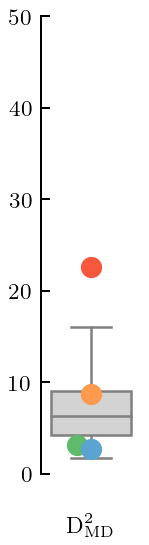

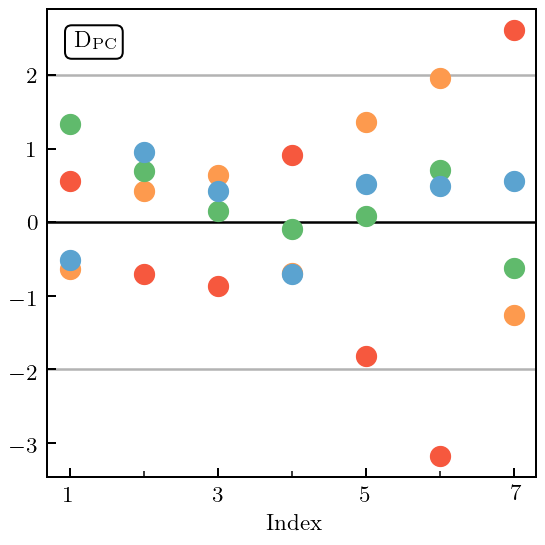

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/2395435347.py:192: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \


test first: 21.65954333733149 158.64290880622784
test last: 405.2129666502413 405.21296665024124
(5, 8)
(5, 7)
X_train has shape (3,)
y_train has shape (3, 5)
X_test has shape (7,)
y_test has shape (7, 5)
ref has shape (350,)
ref_train = [243.77057808  60.9607216   36.66650181]and has shape (3,)
ref_test = [153.75472685 104.7303174   77.10444462  51.06370193  44.61268383
  40.09243414  33.86505614]and has shape (7,)
(3, 5)
(3,)
coeffs_test = [[-1.66963365  0.27790898 -0.3798467   3.89091938]
 [-1.42026431  0.69583724 -0.70558552  2.22350969]
 [-1.00922343  0.98289336 -0.6787579   1.20782627]
 [-0.23396226  1.22516253 -0.1752101   0.04832854]
 [ 0.01727078  1.20533507  0.11544194 -0.27518532]
 [ 0.17322243  1.11699162  0.36916569 -0.4638571 ]
 [ 0.28558581  0.83228428  0.71506574 -0.55837052]]
RBF(length_scale=79.5) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


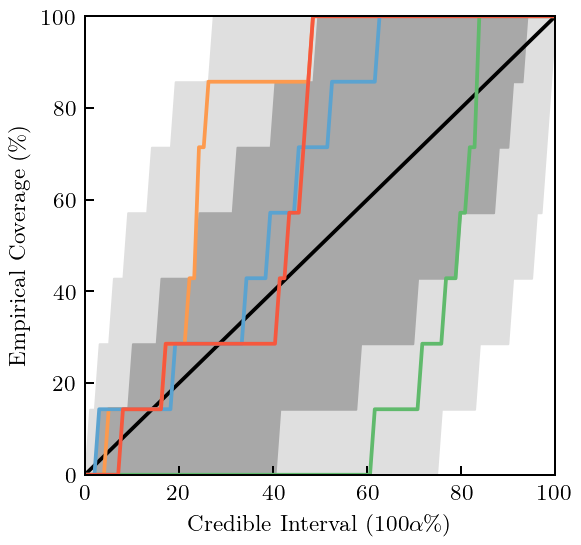

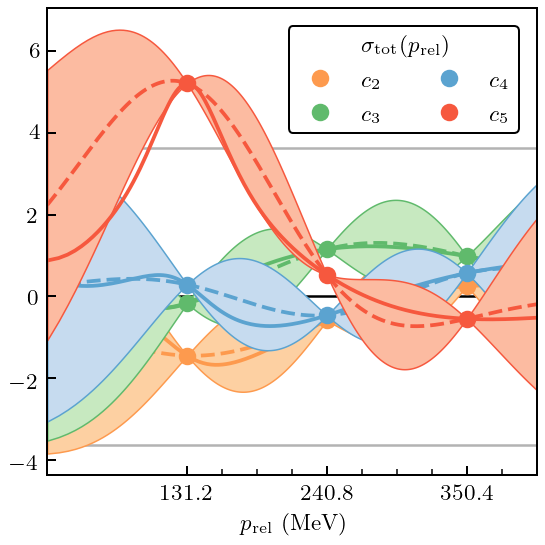

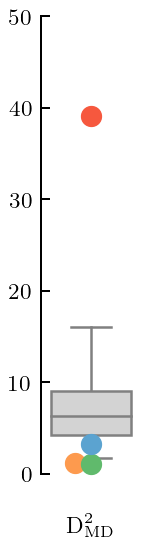

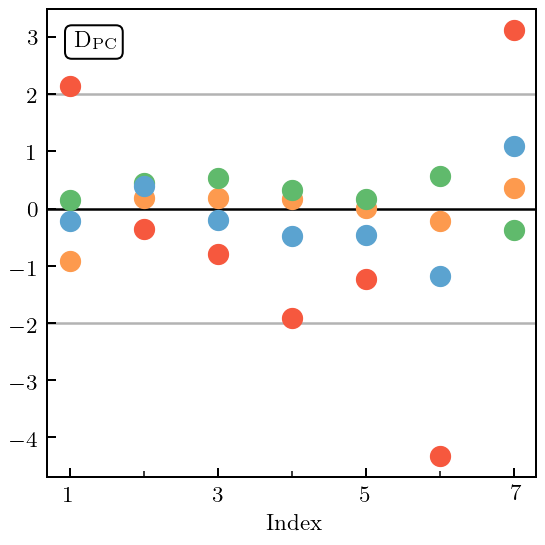

C:\Users\pjmil\AppData\Local\Temp/ipykernel_18792/2395435347.py:192: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \


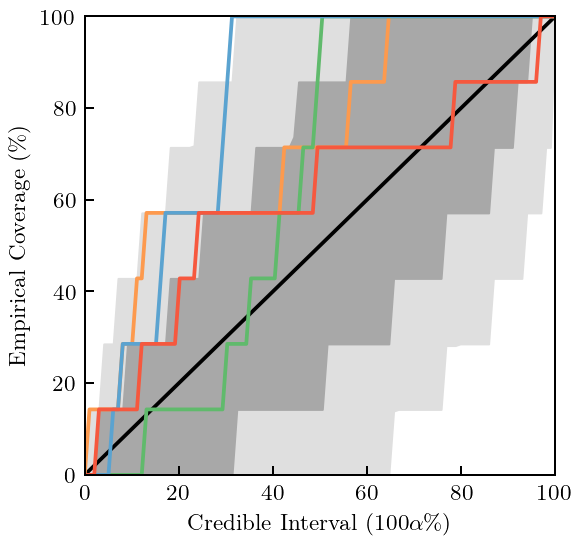

In [28]:
# runs through the observables
for m, observable in enumerate(vsenergy_observable_array):
    # creates the bunches for the input spaces
    ElabBunch = InputSpaceBunch("Elab", \
                        t_lab, \
                        E_to_p(t_lab, "np"), \
                        r'$E_{\mathrm{lab}}$ (MeV)', \
                        [r'$', observable.title, r'(E_{\mathrm{lab}})$'])

    PrelBunch = InputSpaceBunch("prel", \
                        E_to_p(t_lab, "np"), \
                        E_to_p(t_lab, "np"), \
                        r'$p_{\mathrm{rel}}$ (MeV)', \
                        [r'$', observable.title, r'(p_{\mathrm{rel}})$'])

    vsenergy_quantity_array = [ElabBunch, PrelBunch]
    # creates each bunch's title. This eventually will be outside of the for-loop
    for bunch in vsenergy_quantity_array: bunch.make_title()
    
    # runs through the parametrization methods
    for k, Q_param_method in enumerate(Q_param_method_array):
        # runs through the input spaces
        for i, vs_quantity in enumerate(vsenergy_quantity_array):
            # runs through the training and testing masks
            for l, traintestsplit in enumerate(traintestsplit_vsenergy_array):
                # conforms the training and testing masks to each input space
                traintestsplit.make_masks(vs_quantity.input_space, observable.data)
                
                # chooses a starting guess for the GP length scale optimization procedure
                length_scale_guess = observable.ls_guesses[i]
                
                # creates the GP with all its hyperparameters
                center = 0
                ratio_sgt = Q_approx(vs_quantity.mom, Q_param_method, Lambda_b = Lambdab)
                df = 1
                disp = 0
                scale = 1
                GPHyper_SGT = GPHyperparameters(length_scale_guess, center, ratio_sgt, \
                                df = df, disp = 0, scale = scale, seed = 4)
                
                # information for naming the savefiles
                FileName_SGT = FileNaming(potential_string, cutoff_string, Q_param_method)
                
                # information on the orders for each potential
                Orders_SGT = OrderInfo(nn_orders, nn_orders_mask, colors, light_colors)
                
                # creates the object used to generate and plot statistical diagnostics
                MySGT = VsEnergyObj(observable, Lambdab, vs_quantity, traintestsplit, \
                                    GPHyper_SGT, Orders_SGT, FileName_SGT)
                
                # plots figures
                MySGT.PlotCoefficients()
                MySGT.PlotMD()
                MySGT.PlotPC()
                MySGT.PlotCredibleIntervals()

### This will plot the three parametrizations of $Q$ against relative momentum

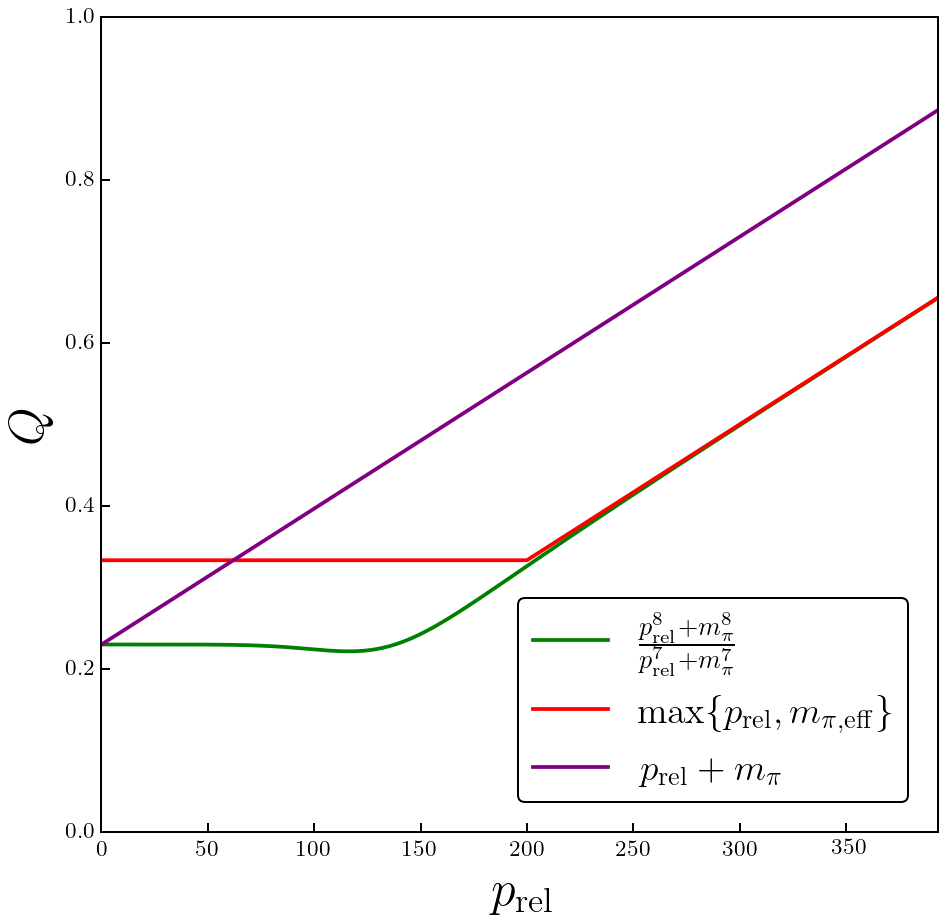

In [29]:
Elab_array = np.linspace(0, 330, 330)

fig, ax = plt.subplots(figsize = (6, 6))

ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "poly", Lambdab), \
        c = 'green', label = r'$\frac{p_{\mathrm{rel}}^{8} + m_{\pi}^{8}}{p_{\mathrm{rel}}^{7} + m_{\pi}^{7}}$')
ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "max", Lambdab), \
        c = 'red', label = r'$\mathrm{max} \{p_{\mathrm{rel}}, m_{\pi, \mathrm{eff}}\}$')
ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "sum", Lambdab), \
        c = 'purple', label = r'$p_{\mathrm{rel}} + m_{\pi}$')

axis_font = {'size':'20'}
ax.set_xlabel(r'$p_{\mathrm{rel}}$', **axis_font)
ax.set_ylabel(r'$Q$', **axis_font)
ax.set_ylim(0, 1)
ax.legend(loc = 'lower right', prop={'size': 15})

fig.savefig('figures/Qparamvsprel.pdf')

### Plots the PWA93 values for observables against default input space

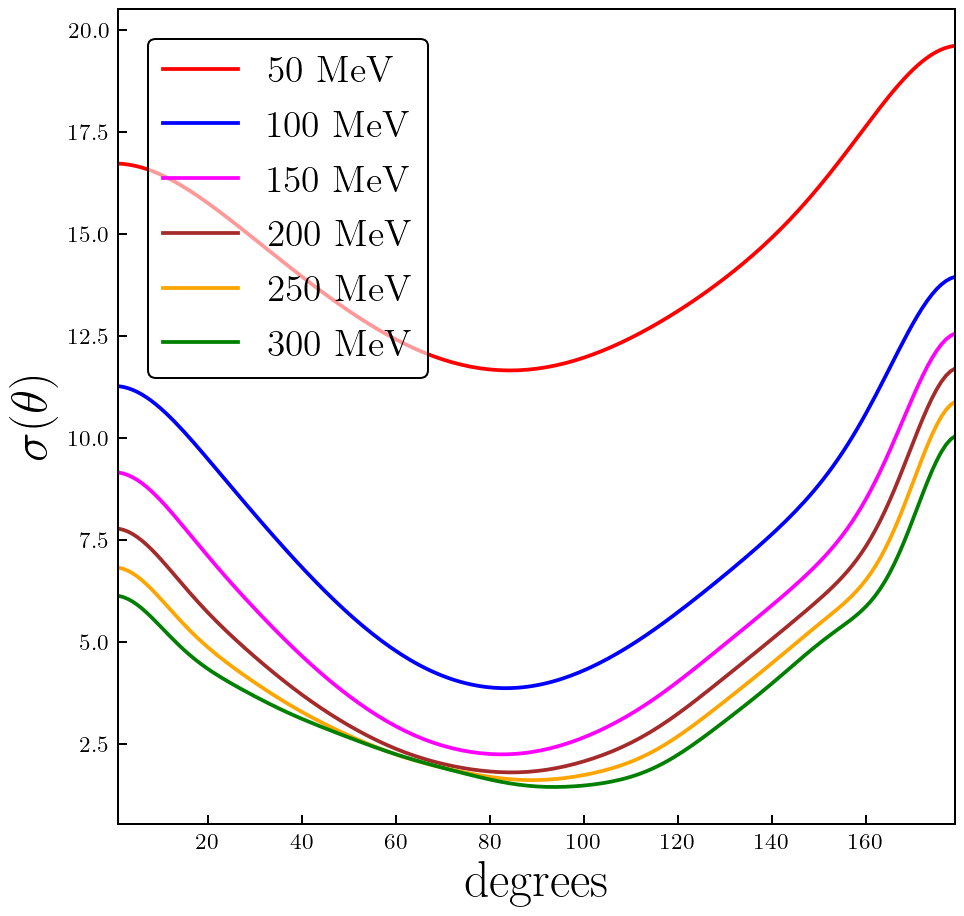

In [30]:
Elab_array = [50, 100, 150, 200, 250, 300]
color_array = ['red', 'blue', 'magenta', 'brown', 'orange', 'green']

fig, ax = plt.subplots(figsize = (6, 6))

for i, Elab in enumerate(Elab_array):
    t_lab_idx_dsg = np.nonzero(Elab == t_lab)[0][0]
    ax.plot(degrees, DSG.T[:, t_lab_idx_dsg, 4], \
            c = color_array[i], label = str(Elab) + ' MeV')

axis_font = {'size':'20'}
ax.set_xlabel('degrees', **axis_font)
ax.set_ylabel(r'$\sigma(\theta)$', **axis_font)
# ax.set_ylim(0, 1)
ax.legend(loc = 'upper left', prop={'size': 15})

fig.savefig('figures/diffcs_n4lo_pwa93_deg.pdf')

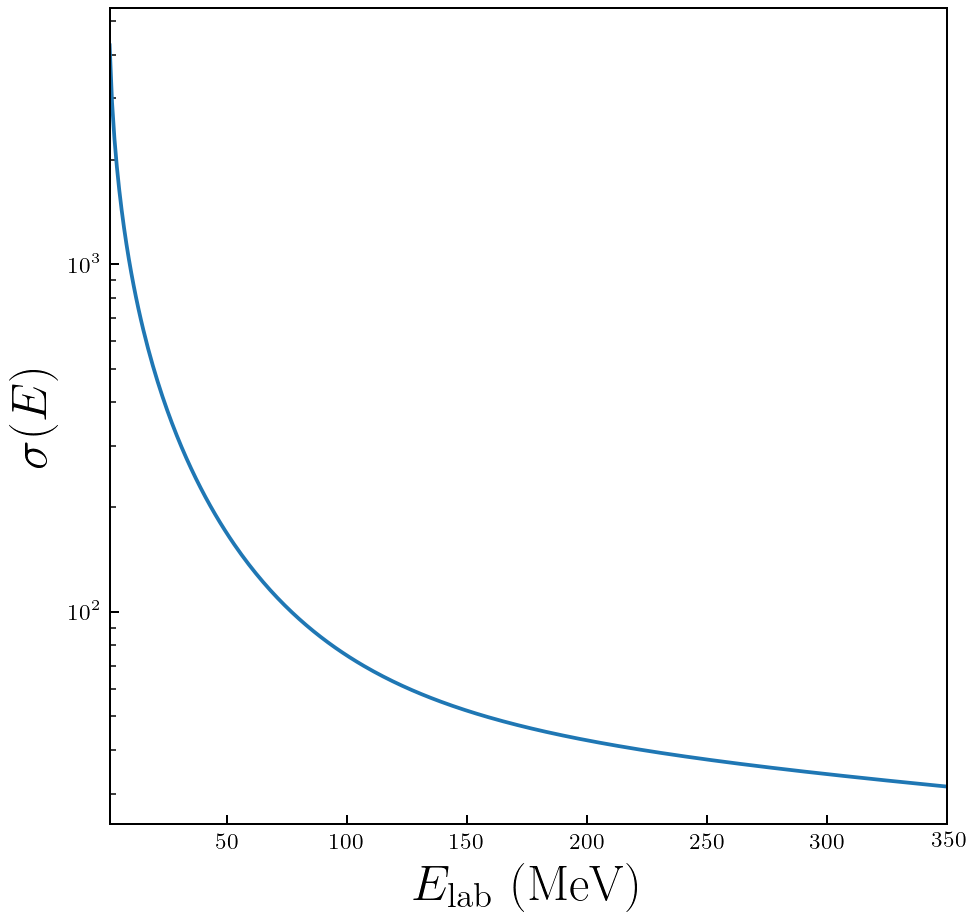

In [32]:
# Elab_array = [50, 100, 150, 200, 250, 300]
# color_array = ['red', 'blue', 'magenta', 'brown', 'orange', 'green']

fig, ax = plt.subplots(figsize = (6, 6))

ax.plot(t_lab, SGT[4, :])
axis_font = {'size':'20'}
ax.set_xlabel(r'$E_{\mathrm{lab}}$ (MeV)', **axis_font)
ax.set_ylabel(r'$\sigma(E)$', **axis_font)
ax.semilogy()

fig.savefig('figures/totalcs_n4lo_pwa93_Elab.pdf')

In [ ]:
# I = np.linspace(0, 3, 5)
# print(I)
# print(I[::-1])
# print(I[:-1])